In [ ]:
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng -qq 2>/dev/null >/dev/null;
!mkdir -p figs
!mkdir -p tables
!pip install scienceplots cartopy geopandas imantics -q 2>/dev/null >/dev/null;

In [3]:
!unzip -o -qq data

In [8]:
import os
import numpy as np
import matplotlib
import pylab as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import scienceplots
from PIL import Image
import geopandas as gpd
import cartopy.crs as ccrs
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from imantics import Mask
from matplotlib.gridspec import GridSpec
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression

In [9]:
def adjusted_r2(xp,yp):
    model = LinearRegression()
    model.fit(xp.reshape(-1, 1),yp)
    return 1 - (1-model.score(xp.reshape(-1, 1), yp))*(len(yp)-1)/(len(yp)-xp.reshape(-1, 1).shape[1]-1)

seednumber = 1

np.random.seed(seednumber)

avgcol = (1,0.6,0)
ntry = 100000
keep_out = 0.5
cl=99.7
cl=95
# Our center
c2p = 35552/4804 #7.4
p2s = 237179/35552 #6.67

# 7.4*6.67 = 49.36
# 13.7*3.2 = 43.84

def latex_float(f,nd=1):
    return f'${f:1.{nd}f}$'
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"${0} \times 10^{{{1}}}$".format(base, int(exponent))
    else:
        return f'${float_str}$'

def change_width(ax, new_value=None,shiftx=None,wrt=False,fontsize=60,t_shift=0.2,nd=1):
    for patch in ax.patches :

        if not new_value is None:
            current_width = patch.get_width()
            diff = current_width - new_value
            # we change the bar width
            patch.set_width(new_value)
            # we recenter the bar
            patch.set_x(patch.get_x() + diff * .5)

        if not shiftx is None:
            cx = patch.get_x()
            patch.set_x(cx+shiftx)

        if wrt:
            x = patch.get_x()+t_shift
            y = patch.get_y()
            h = patch.get_height()
            t = latex_float(h,nd=nd)
            ax.text(x,h,t,va='bottom',ha='center',ma='center',fontsize=fontsize,rotation=0)

class StatFit(object):
    def __init__(self,ntry,keep_out):
        self.ntry = ntry
        self.keep_out = keep_out
        self.models = []

    def fit(self,x_all, y_all, n=1):
        np.random.seed(seednumber)
        n_data = len(x_all)
        for i in range(self.ntry):
            inds = np.arange(n_data)

            inds = np.random.choice(inds, size=n_data, replace=True)

            x_all_p, y_all_p = x_all[inds], y_all[inds]
            p, C_p = np.polyfit(x_all_p, y_all_p, n, cov=True)  # C_z is estimated covariance matrix
            self.models.append(np.poly1d(p))

    def __call__(self,x, cl=68):
        ys = []
        for m in self.models:
            ys.append(m(x))
        ys = np.array(ys)
        cl = (100-cl)/2
        mm = np.mean(ys,axis=0)
        ll = np.percentile(ys,cl,axis=0)
        uu = np.percentile(ys,100-cl,axis=0)
        return ll,mm,uu

def correct_df(df_):
    df_ = df_.reset_index()
    def fun1(x):
        if 'Tissue' in x:
            return 'Tissue'
        elif 'ROI' in x:
            return 'ROI'
        else:
            return 'WSI'
    df_['Input'] = df_['Scenario'].apply(fun1)
    def fun1(x):
        if 'LowAI' in x:
            return 1
        elif 'MedAI' in x:
            return 2
        else:
            return 7
    df_['ntask'] = df_['Scenario'].apply(fun1)
    def fun1(x):
        if 'LowAI' in x:
            return '1-task'
        elif 'MedAI' in x:
            return '2-task'
        else:
            return '7-task'
    df_['Scenario'] = df_['Scenario'].apply(fun1)

    def fun1(x):
        y = 0*(x['CO$_2$eq FP']=='LCF')+1*(x['CO$_2$eq FP']=='MCF')+2*(x['CO$_2$eq FP']=='HCF')
        y = y+ (-0.2*(x['Input']=='ROI')+0.0*(x['Input']=='Tissue')+0.2*(x['Input']=='WSI'))
        return y
    df_['DLs'] = df_[['CO$_2$eq FP','Input']].apply(fun1,axis=1)
    df_ = df_.drop(columns=['DLs'])
    return df_

In [10]:
df_renew_pc = pd.read_html('https://www.destatis.de/EN/Themes/Economic-Sectors-Enterprises/\
Energy/Production/Tables/gross-electricity-production.html')[0][['Energy sources','2019']]
df_renew_pc = df_renew_pc.droplevel(0, axis=1)[['Energy sources','%']].iloc[:-1]
df_renew_pc['%'] = df_renew_pc['%'].astype(float)

In [11]:
labels_sources = {'Lignite':'Coal',
'Hard coal':'Coal',
'Nuclear energy':'Nuclear',
'Natural gas':'Gas',
'Mineral oil products':'Other',
'Wind power':'Wind',
'Water power3':'Hydro',
'Biomass energy':'Biomass',
'Photovoltaic energy':'Solar',
'Household waste4':'Other',
'Geothermal':'Other',
'Other energy sources':'Other'}
df_renew_pc = df_renew_pc.replace(labels_sources)
def_sel = df_renew_pc.groupby('Energy sources').sum().loc[['Nuclear','Other','Coal','Gas','Wind','Solar','Biomass','Hydro']]

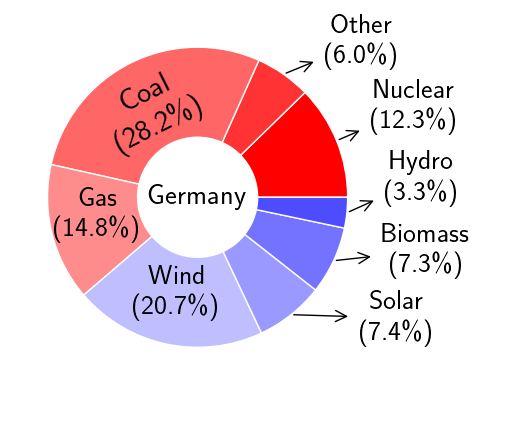

In [12]:
if not os.path.exists('figs'):
    os.mkdir('figs')

with plt.style.context(['science', 'nature']):
    fig,ax = plt.subplots(1,1,figsize=(5.2,5))

    size = 0.6
    data = (360*def_sel.values/def_sel.values.sum()).reshape(-1)
    outer_colors = [(1,0,0),(1,0.2,0.2),(1,0.4,0.4),(1,0.55,0.55),(0.75,0.75,1),
             (0.6,0.6,1),(0.45,0.45,1),(0.3,0.3,1),(0.15,0.15,1),(0,0,1)]#[::-1]
    wedges, texts = ax.pie(data, radius=1, colors=outer_colors,
           wedgeprops=dict(width=size, edgecolor='w'))

    recipe = list(def_sel.index)

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="w", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="<-"),
              bbox=bbox_props, zorder=0, va="center")
    rec0 = [f'{i}\n({j:2.1f}\%)' for i,j in zip(recipe,100*(def_sel.values/def_sel.values.sum()).reshape(-1))]
    offset = [-0.21,0.18,0.61]
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        if i==0:
          # ax.text(0.67*x,0.67*y,rec0[i],va='center',ha='center',fontsize=20,rotation=0)
          ax.annotate(rec0[i], xy=(x, y), xytext=(1.45*np.sign(x), 1.6*y),
            horizontalalignment={-1: "center", 1: "center"}[int(np.sign(x))],fontsize=20, **kw)
        elif i==1:
          ax.annotate(rec0[i], xy=(x, y), xytext=(1.*np.sign(x)+0.1, 1.3*y-0.03),
            horizontalalignment={-1: "center", 1: "center"}[int(np.sign(x))],fontsize=20, **kw)
        elif i==2:
          ax.text(0.65*x,0.65*y,rec0[i],va='center',ha='center',fontsize=22,rotation=(ang+90)+180)
        elif i==3:
          ax.text(0.68*x,0.68*y+0.05,rec0[i],va='center',ha='center',fontsize=20,rotation=0)#(ang+90)+180)
        elif i==4:
          ax.text(0.65*x,0.65*y,rec0[i],va='center',ha='center',fontsize=20,rotation=0)#(ang+90))
        elif i==5:
          ax.annotate(rec0[i], xy=(x, y), xytext=(1.*np.sign(x)+0.33, 1.45*y+0.33),
            horizontalalignment={-1: "center", 1: "center"}[int(np.sign(x))],fontsize=20, **kw)
        elif i==6:
          ax.annotate(rec0[i], xy=(x, y), xytext=(1.43*np.sign(x)+0.1, 1.43*y+0.25),
            horizontalalignment={-1: "center", 1: "center"}[int(np.sign(x))],fontsize=20, **kw)
        elif i==7:
          ax.annotate(rec0[i], xy=(x, y), xytext=(1.5*np.sign(x), 1.5*y+0.28),
            horizontalalignment={-1: "center", 1: "center"}[int(np.sign(x))],fontsize=20, **kw)

    ax.text(0,0,"Germany",va='center',ha='center',fontsize=20.5)
    ax.text(2.1,-1.39,".",va='center',ha='center',fontsize=10,color='w')

    fname = 'Germany_power_mix'
    plt.tight_layout()
    fig.savefig(f'figs/{fname}.pdf')
    fig.savefig(f'figs/{fname}.svg')
    fig.savefig(f'figs/{fname}.jpg', dpi=300)

In [13]:
dfrep2 = pd.read_csv('data/1-b.csv')
def f1(x):
    if x=='breast-biopsy':
        return 1
    if x=='breast-resection':
        return 2
    if x=='prostate-resection':
        return 3
    if x=='prostate-biopsy':
        return 4

dfrep2['sortind'] = dfrep2['organ2'].apply(f1)
dfrep2p = dfrep2.sort_values(by='sortind').reset_index().drop(columns=['index'])

In [14]:
with plt.style.context(['science', 'nature']):
    axs = sns.jointplot(data=dfrep2, x="\# pixels (Giga pixels)", y="file sizes (GB)", hue="organ2",
                        palette=[(0,0,1),(0.6,0.6,0.9),(0.9,0.6,0.6),(1,0,0)])
    axs.ax_marg_x.axis('off')
    axs.ax_marg_y.axis('off')
    axs.ax_joint.clear()
    ax = axs.ax_joint
    ax = sns.scatterplot(x="\# pixels (Giga pixels)", y="file sizes (GB)", hue="organ2", size="tissue (\%)",
                sizes=(20, 330), alpha=.6, palette=[(0,0,1),(0.6,0.6,0.9),(0.9,0.6,0.6),(1,0,0)],
                data=dfrep2p,ax=ax)

    ax = sns.scatterplot(x="\# pixels (Giga pixels)", y="file sizes (GB)", hue="organ2", size="tissue (\%)",
                sizes=(20, 330), alpha=.6, palette=[(0,0,1),(1,0,0)],
                data=dfrep2p[ (dfrep2p['sortind']==1) | (dfrep2p['sortind']==4) ],ax=ax)

    ax.set_xlabel('\# Pixels [Giga pixels]',fontsize=20)
    ax.set_ylabel('File sizes [GB]',fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)

    h,l = ax.get_legend_handles_labels()
    l[0] = ' '
    l[5] = ' '
    for hi in h[1:5]:
        hi.set_sizes([50])
        hi.set_alpha(.7)
    l = l[:11]
    h = h[:11]
    ax.legend(h,l,loc=(-0.02,0.19),fontsize=17,facecolor='none',edgecolor='none',handletextpad=0.05)

    t = plt.text(0.03, 0.93, 'organ        ', transform=ax.transAxes, fontsize=17)
    t.set_bbox(dict(facecolor='w', alpha=1, edgecolor='w'))
    t = plt.text(0.03, 0.58, 'tissue (\%)    ', transform=ax.transAxes, fontsize=17)
    t.set_bbox(dict(facecolor='w', alpha=1, edgecolor='w'))

    ax.set_xlim(-0.3,23)
    ax.set_ylim(-0.2,7)
    plt.subplots_adjust(left=0.11,
        bottom=None,
        right=0.9999,
        top=0.9999,
        wspace=0.0,
        hspace=0)
    fig = axs.fig

    fname = 'slides_stat_pix2'
    fig.savefig(f'figs/{fname}.pdf')
    fig.savefig(f'figs/{fname}.svg')
    fig.savefig(f'figs/{fname}.jpg', dpi=300)

In [15]:
dimg = np.load('data/1-c.npz')
image = dimg['image']
wsi = dimg['wsi']
tissue = dimg['tissue']
roi = dimg['roi']

In [16]:
with plt.style.context(['science', 'nature']):
    fig,ax = plt.subplots(1,1,figsize=(8,6))
    ax.imshow(image,origin='lower')
    ax.axis('off')
    fname = 'DRS_example'
    plt.tight_layout()
    fig.savefig(f'figs/{fname}.pdf')
    fig.savefig(f'figs/{fname}.svg')
    fig.savefig(f'figs/{fname}.jpg', dpi=300)

In [17]:
with plt.style.context(['science', 'nature']):
    fig,ax = plt.subplots(1,1,figsize=(8,6))
    ax.imshow(image,origin='lower',alpha=0.7)
    plt.imshow(wsi,cmap=ListedColormap([(0,0,0,0),(0,0,1,0.5)]),origin='lower')
    ax.axis('off')

    fname = 'DRS_example_wsi'
    plt.tight_layout()
    fig.savefig(f'figs/{fname}.pdf')
    fig.savefig(f'figs/{fname}.svg')
    fig.savefig(f'figs/{fname}.jpg', dpi=300)

In [18]:
with plt.style.context(['science', 'nature']):
    fig,ax = plt.subplots(1,1,figsize=(8,6))
    ax.imshow(image,origin='lower',alpha=0.7)
    plt.imshow(tissue,cmap=ListedColormap([(0,0,0,0),(1,0,0,0.5)]),origin='lower')
    ax.axis('off')

    fname = 'DRS_example_tissue'
    plt.tight_layout()
    fig.savefig(f'figs/{fname}.pdf')
    fig.savefig(f'figs/{fname}.svg')
    fig.savefig(f'figs/{fname}.jpg', dpi=300)

In [19]:
with plt.style.context(['science', 'nature']):
    fig,ax = plt.subplots(1,1,figsize=(8,6))
    ax.imshow(image,origin='lower',alpha=0.7)
    plt.imshow(roi,cmap=ListedColormap([(0,0,0,0),(1,0,1,0.5)]),origin='lower')
    ax.axis('off')

    fname = 'DRS_example_roi'
    plt.tight_layout()
    fig.savefig(f'figs/{fname}.pdf')
    fig.savefig(f'figs/{fname}.svg')
    fig.savefig(f'figs/{fname}.jpg', dpi=300)

In [20]:
dftplot = pd.read_csv('data/1-d.csv')

cls_names = {
0: 'DenseNet121',
1: 'DenseNet169',
2: 'DenseNet201',
3: 'EfficientNetB0',
4: 'EfficientNetB1',
5: 'EfficientNetB2',
6: 'EfficientNetB3',
7: 'EfficientNetB4',
8: 'EfficientNetB5',
9: 'EfficientNetB6',
10: 'EfficientNetB7',
11: 'EfficientNetV2B0',
12: 'EfficientNetV2B1',
13: 'EfficientNetV2B2',
14: 'EfficientNetV2B3',  # med
15: 'EfficientNetV2L',
16: 'EfficientNetV2M',
17: 'EfficientNetV2S',
18: 'InceptionResNetV2',
19: 'InceptionV3',
20: 'MobileNet',
21: 'MobileNetV2',
22: 'MobileNetV3Large',
23: 'MobileNetV3Small',  #low
24: 'NASNetLarge',
25: 'NASNetMobile',
26: 'ResNet101',
27: 'ResNet101V2',
28: 'ResNet152',
29: 'ResNet152V2',
30: 'ResNet50',
31: 'ResNet50V2',
32: 'VGG16',
33: 'VGG19',
34: 'Xception',
100: 'ConvNeXtBase',
101: 'ConvNeXtXL'  #high
}

seg_names = {
0: 'unet_2d',
1: 'vnet_2d',  #low
2: 'att_unet_2d',
3: 'unet_plus_2d',  #med
4: 'unet_3plus_2d',
5: 'unet_3plus_2d',
6: 'r2_unet_2d',
7: 'resunet_a_2d',
8: 'u2net_2d',
9: 'transunet_2d',  #high
10: 'swin_unet_2d'
}

x_all, y_all = dftplot[["# parameters",'CO2$_{eq}$']].apply(np.log).values.T
f_model_co2 = StatFit(ntry=100,keep_out=0.4)
f_model_co2.fit(x_all, y_all)
t = np.log(540350000000)
ll,mm,uu = f_model_co2(t,cl=95)
ll,mm,uu = np.exp(ll),np.exp(mm),np.exp(uu)
plmll,plmmm,plmuu = ll,mm,uu


dftplot = dftplot.set_index(['task','imodel','ntry']).groupby(level=[0,1]).mean(numeric_only=True) #breaks
print(dftplot)
#for key, item in dftplot:
#    print(dftplot.get_group(key), "\n\n")
dftplot2 = dftplot.copy(deep=1).reset_index()

dftplot2['model'] = dftplot2[['task','imodel']].apply(lambda x: cls_names[x[1]] if x[0]=='classification' else seg_names[x[1]],axis=1)

xtt = dftplot['# parameters'].apply(np.log).values
ytt = dftplot['CO2$_{eq}$'].apply(np.log).values
z = np.polyfit(xtt,ytt,deg=1)
poly = np.poly1d(z)
PaLM_par = 540350000000
PaLM_co2 = np.exp(poly(np.log(PaLM_par)))
PaLM_co2 = plmmm

nend = dftplot2.shape[0]
dftplot2
dftplot2.loc[nend] = 'multi-task', 0, PaLM_co2, PaLM_par, 118, 'PaLM'

dftplot2 = dftplot2.set_index(['task','imodel'])

xmodel = []
ymodel = []
models = ['MobileNet','EfficientNet','ConvNeXt','Vnet','Unet+','TransUnet','PaLM']
for mm in [23,14,101]:
    xx = dftplot2.loc[('classification',mm)]["# parameters"]
    yy = dftplot2.loc[('classification',mm)][r'CO2$_{eq}$']
    xmodel.append(xx)
    ymodel.append(yy)
for mm in [1,3,9]:
    xx = dftplot2.loc[('segmentation',mm)]["# parameters"]
    yy = dftplot2.loc[('segmentation',mm)][r'CO2$_{eq}$']
    xmodel.append(xx)
    ymodel.append(yy)

xmodel.append(PaLM_par)
ymodel.append(PaLM_co2)

dftplot2 = dftplot2.reset_index()
dftplot2 = dftplot2.rename(columns={'# parameters':'\# parameters','# layers':'\# layers'})
# dftplot2

                       CO2$_{eq}$  # parameters  # layers
task           imodel                                    
classification 0         0.259785     7334690.0     432.0
               2         0.337690    18877218.0     712.0
               3         0.237381     4420485.0     242.0
               10        0.682208    64837241.0     818.0
               11        0.174551     6290226.0     260.0
               14        0.289900    13375264.0     388.0
               15        0.686006   118117762.0     961.0
               17        0.255233    20702274.0     484.0
               18        0.438660    54781378.0     785.0
               19        0.253257    22394882.0     316.0
               22        0.105705     3275106.0     268.0
               23        0.084869     1107282.0     234.0
               24        0.606063    86080308.0    1044.0
               29        0.364864    58923746.0     569.0
               31        0.305471    24156898.0     195.0
              

In [21]:
with plt.style.context(['science', 'nature']):
    fig,ax = plt.subplots(figsize=(10,6))
    ax = sns.scatterplot(x="\# parameters", y=r'CO2$_{eq}$', hue="task", size="\# layers",
                sizes=(50, 400), alpha=.5, palette=[(0,0,1),(1,0,0),(1,0,1)],linewidth=0,
                data=dftplot2,ax=ax)

    ax.plot(2*[PaLM_par],[plmll,plmuu],lw=2,color=(1,0,1))
    xs,ys = dftplot2[
    dftplot2['model'].isin(['MobileNetV3Small',
                            'EfficientNetV2B3',
                            'ConvNeXtXL',
                            'vnet_2d',
                            'unet_plus_2d',
                            'transunet_2d',
                            # 'PaLM'
                           ])][['\# parameters',r'CO2$_{eq}$']].values.T
    ax.scatter(xs,ys, s=200, facecolors='none', edgecolors='k',
            linestyle='--',lw=2,zorder=100)

    xs,ys = dftplot2[
    dftplot2['model'].isin(['PaLM'])][['\# parameters',r'CO2$_{eq}$']].values.T
    ax.scatter(xs,ys, s=200, facecolors='none', edgecolors='k',
            linestyle='-.',lw=2,zorder=100)

    ax.set_xscale('log')
    ax.set_yscale('log')
    h,l = ax.get_legend_handles_labels()
    h = h[:10]
    l = l[:10]
    h = h[:8]
    l = l[:8]
    l[0] = ''
    l[4] = ''
    for hi in h[1:4]:
        hi.set_sizes([80])
        hi.set_alpha(.7)
    ax.legend(h,l,loc=(1.00,0.185),fontsize=25,facecolor='none',edgecolor='none',
              handletextpad=-0.3,labelspacing=0.53) #(0.28,0.43)

    t = plt.text(1.055, 0.96, 'task     ', transform=ax.transAxes, fontsize=25)
    t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))

    t = plt.text(1.055, 0.55, '\# layers  ', transform=ax.transAxes, fontsize=25)
    t.set_bbox(dict(facecolor='w', alpha=1, edgecolor='w'))


    ax.scatter([1.084], [0.15], s=250, facecolors='none', edgecolors='k',linestyle='--',lw=2,zorder=100,
               transform=ax.transAxes, clip_on=False)
    t = plt.text(1.12, 0.15, 'calculated', transform=ax.transAxes, fontsize=25,va='center',ha='left')
    t.set_bbox(dict(facecolor='w', alpha=1, edgecolor='w'))
    ax.scatter([1.084], [0.06], s=250, facecolors='none', edgecolors='k',linestyle='-.',lw=2,zorder=100,
               transform=ax.transAxes, clip_on=False)
    t = plt.text(1.12, 0.06, 'estimated', transform=ax.transAxes, fontsize=25,va='center',ha='left')
    t.set_bbox(dict(facecolor='w', alpha=1, edgecolor='w'))

    i = 0 # 'MobileNet'
    ax.text(1.15*xmodel[i],0.8*ymodel[i],models[i],va='top',ha='center',fontsize=18, weight='bold')
    i = 1 # 'EfficientNet'
    ax.text(0.7*xmodel[i],0.7*ymodel[i],models[i],va='top',ha='left',fontsize=18, weight='bold')
    i = 2 # 'ConvNeXt'
    ax.text(xmodel[i],0.82*ymodel[i],models[i],va='top',ha='center',fontsize=18, weight='bold')
    i = 3 # 'Vnet'
    ax.text(1.2*xmodel[i],1.2*ymodel[i],models[i],va='bottom',ha='center',fontsize=18, weight='bold')
    i = 4 # 'Unet+'
    ax.text(xmodel[i],1.2*ymodel[i],models[i],va='bottom',ha='center',fontsize=18, weight='bold')
    i = 5 # 'TransUnet'
    ax.text(xmodel[i],1.2*ymodel[i],models[i],va='bottom',ha='center',fontsize=18, weight='bold')
    # 'PaLM'
    ax.text(0.3*xmodel[6],1.2*ymodel[6],models[6],va='top',ha='center',fontsize=18, weight='bold')
    ax.set_xlim(3e5,1*1e12)
    ax.set_ylim(0.048,250)

    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)
    ax.set_ylabel(r'CO$_2$ [kg/$10^7$ tiles]',fontsize=20)
    ax.yaxis.set_label_coords(-0.07,0.5)
    ax.set_xlabel('\# Parameters',fontsize=20)

    fname = 'models_co2'
    plt.tight_layout()
    fig.savefig(f'figs/{fname}.pdf')
    fig.savefig(f'figs/{fname}.svg')
    fig.savefig(f'figs/{fname}.jpg', dpi=300)

In [22]:
df_co2_dev = pd.read_csv('data/1-e.csv')

In [23]:
with plt.style.context(['science', 'nature']):

    fig,ax = plt.subplots(1,1,figsize=(6,3))

    ax = sns.barplot(x='model',y='CO$_2$eq',hue=r'dev',data=df_co2_dev,
                     alpha=0.9, ax=ax, palette=[(0,0,1),
                                                (0.3,0.35,0.9),
                                                (0.9,0.35,0.3),
                                                (1,0,0)],linewidth=3, edgecolor=(1,1,1))

    ax.set_yscale('log')
    ax.set_ylim(0.03,200)
    ax.tick_params(axis='x', which='both', labelsize=18)
    ax.tick_params(axis='y', which='both', labelsize=15)
    ax.set_xticklabels(['MobileNet','EfficientNet','ConvNeXt'])
    for i,t in enumerate(['Small-DL','Medium-DL','Large-DL']):
        ax.text(i,0.008,t,fontsize=14,va='center',ha='center')

    ax.set_xlabel('',fontsize=16)
    ax.set_ylabel(r'CO$_2$ [kg/$10^7$ tiles]',fontsize=18)
    ax.legend(fontsize=14)
    plt.tight_layout()

    fname = 'co2_dev'
    plt.tight_layout()
    fig.savefig(f'figs/{fname}.pdf')
    fig.savefig(f'figs/{fname}.svg')
    fig.savefig(f'figs/{fname}.jpg', dpi=300)


/tmp/ipykernel_283597/2428875751.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


# Figure 2

In [24]:
dfn = pd.read_csv(r'data/slides_info.csv')

In [25]:
dfn.head(3)

ORGAN  Nslide
0  prostate_ac       2
1  prostate_ac       2
2  prostate_ac       2

In [26]:
dfp = pd.read_csv('data/tper_sus.csv')
dfp_anno = pd.read_csv('data/slides_anno.csv')
dfp['pixper'] = dfp['tissue_perc']*dfp['npixel']/100
dfp.head(3)

Unnamed: 0                 file_name        organ     file_size  \
0           0   ai4stainability-001.svs  prostate_ac  1.849369e+09   
1           1   ai4stainability-002.svs  prostate_ac  2.088589e+09   
2           2   ai4stainability-003.svs  prostate_ac  2.490141e+09   

         npixel  tissue_perc        pixper  
0  2.593121e+10        72.26  1.873789e+10  
1  2.865375e+10        59.05  1.692004e+10  
2  2.719459e+10        58.05  1.578646e+10

In [27]:
all_organs = ['prostate_ac','breast_ac']
df_np = pd.DataFrame(columns=['trial','nside','organ','specimen','npatch_WSI','npatch_tissue','npatch_ROI'])

ntrial = 50
ii = 0

for itrial in range(ntrial):
    for nside in [128,256]:
        # print(nside)
        for organ in all_organs: #['prostate_ac','breast_ac']:
            for specimen in ['']: #['Biopsy','Resection']:

                filt = (dfn['ORGAN']==organ) #& (dfn['specimen']==specimen)
                num = dfn[filt].shape[0]


                filt = (dfp['organ']==organ) #& (dfp['specimen']==specimen)
                npixels = dfp[filt]['npixel'].sample(num,replace=True).values
                patchs = npixels//nside**2
                npatches_w = int(np.sum(patchs))

                filt = (dfp_anno['organ']==organ) & (dfp_anno['class']=='Tissue')
                npixels = dfp_anno[filt]['pixper'].sample(num,replace=True).values
                patchs = npixels//nside**2
                npatches_t = int(np.sum(patchs))

                filt = (dfp_anno['organ']==organ) & (dfp_anno['class']=='ROI')
                npixels = dfp_anno[filt]['pixper'].sample(num,replace=True).values
                patchs = npixels//nside**2
                npatches_r = int(np.sum(patchs))



                # percs = dfp[filt]['tissue_perc']*dfp[filt]['npixel']


                # print('{:10s}, {:10s}: {:d}'.format(organ,specimen,npatches))
                df_np.loc[ii,'trial'] = itrial
                df_np.loc[ii,'nside'] = nside
                df_np.loc[ii,'organ'] = organ
                df_np.loc[ii,'specimen'] = specimen
                df_np.loc[ii,'npatch_WSI'] = npatches_w
                df_np.loc[ii,'npatch_tissue'] = npatches_t
                df_np.loc[ii,'npatch_ROI'] = npatches_r
                ii = ii+1

def fun(x1,x2,x3):
    return '{}-{}-{}'.format(x1,x2,x3)
df_np['osn'] = df_np[['organ','nside','trial']].apply(lambda x: fun(*x), axis=1)
df_np[["nside", "npatch_WSI", "npatch_tissue"]] = df_np[["nside", "npatch_WSI", "npatch_tissue"]].apply(pd.to_numeric)

df_np.head(3)

trial  nside        organ specimen   npatch_WSI  npatch_tissue npatch_ROI  \
0     0    128  prostate_ac           12145194261     1486764196  195293392   
1     0    128    breast_ac           24059663319     3277939748  190750827   
2     0    256  prostate_ac            3045510875      370285510   47601001   

                 osn  
0  prostate_ac-128-0  
1    breast_ac-128-0  
2  prostate_ac-256-0

In [28]:
reading_load = {}

for nside in [256]:
    total_power,kg_carbon,total_wall_clock_time,n_patchs = np.load(f'data/reading_time_{nside}.npy')
    reading_load[nside] = {}
    reading_load[nside]['kg_carbon'] = kg_carbon
    reading_load[nside]['n_patchs'] = n_patchs

In [29]:
df_read = pd.DataFrame(columns=['trial','nside',
                                'tco2','n_trees','car'])

ii = 0
for itrial in tqdm(range(ntrial)):
    for nside in [256]:

        df_read.loc[ii,'trial'] = itrial
        df_read.loc[ii,'nside'] = nside

        # nnn = int(npatch_w[organ+'-'+specimen+str(nside)]/dsize)
        nnn = int(df_np[df_np['osn']==organ+'-'+str(nside)+'-'+str(itrial)]['npatch_WSI'].values[0])
        total_co2 = nnn*reading_load[nside]['kg_carbon']/reading_load[nside]['n_patchs']
        n_trees = total_co2/21.8
        car = total_co2/4600
        # print(total_co2)

        df_read.loc[ii,'tco2'] = total_co2/1000
        df_read.loc[ii,'n_trees'] = np.round(n_trees,4)
        df_read.loc[ii,'car'] = np.round(car,4)
        ii = ii+1
df_read = df_read.set_index(['nside','trial'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1390.83it/s]


In [30]:
df_test = pd.read_csv('data/df_test.csv')
# For a year, our human produces about 365 x 0.7 kilograms a year, or 255 kilograms.
# A mature tree is said to take up 21.8 kilograms of carbon dioxide a year.
# sel_org = all_organs
sel_org = ['prostate_ac','breast_ac']

specimen = ''

df_res = pd.DataFrame(columns=['task','organ','specimen','imodel', 'model','trial',
                               'tco2_w','n_trees_w','car_w',
                               'tco2_t','n_trees_t','car_t',
                               'tco2_r','n_trees_r','car_r'])
ntrial = 50
ii = 0
for itrial in tqdm(range(ntrial)):
    for task in ['cls','seg']:
        # print(nside)
        for organ in sel_org:#['prostate_ac','breast_ac']:
            imodels = df_test[df_test['task']==task]['imodel'].unique()
            for imodel in imodels:
                filt = (df_test['task']==task) & (df_test['imodel']==imodel)
                dfpp = df_test[filt]
                dsize = dfpp['dsize'].values[0]
                batch_size = dfpp['batch_size'].values[0]
                kg_carbon = dfpp['kg_carbon']
                power = dfpp['total_power']
                # kg_carbon.sample(3)
                nside = dfpp['nside'].values[0]

                df_res.loc[ii,'task'] = task
                df_res.loc[ii,'organ'] = organ
                df_res.loc[ii,'specimen'] = specimen
                df_res.loc[ii,'imodel'] = imodel
                if task=='cls':
                    df_res.loc[ii,'model'] = cls_names[imodel]
                elif task=='seg':
                    df_res.loc[ii,'model'] = seg_names[imodel]
                else:
                    assert 0,''
                df_res.loc[ii,'trial'] = itrial

                # nnn = int(npatch_w[organ+'-'+specimen+str(nside)]/dsize)
                nnn = int(df_np[df_np['osn']==organ+'-'+str(nside)+'-'+str(itrial)]['npatch_WSI'].values[0]/dsize)
                samples = kg_carbon.sample(nnn,replace=True).values
                total_co2 = np.sum(samples)
                n_trees = total_co2/21.8
                car = total_co2/4600
                # print(total_co2)

                df_res.loc[ii,'tco2_w'] = total_co2/1000
                df_res.loc[ii,'n_trees_w'] = np.round(n_trees,4)
                df_res.loc[ii,'car_w'] = np.round(car,4)

                # nnn = int(npatch_t[organ+'-'+specimen+str(nside)]/dsize)
                nnn = int(df_np[df_np['osn']==organ+'-'+str(nside)+'-'+str(itrial)]['npatch_tissue'].values[0]/dsize)
                samples = kg_carbon.sample(nnn,replace=True).values
                total_co2 = np.sum(samples)
                n_trees = total_co2/21.8
                car = total_co2/4600
                # print(total_co2)

                df_res.loc[ii,'tco2_t'] = total_co2/1000
                df_res.loc[ii,'n_trees_t'] = np.round(n_trees,4)
                df_res.loc[ii,'car_t'] = np.round(car,4)

                # nnn = int(npatch_t[organ+'-'+specimen+str(nside)]/dsize)
                nnn = int(df_np[df_np['osn']==organ+'-'+str(nside)+'-'+str(itrial)]['npatch_ROI'].values[0]/dsize)
                samples = kg_carbon.sample(nnn,replace=True).values
                total_co2 = np.sum(samples)
                n_trees = total_co2/21.8
                car = total_co2/4600
                # print(total_co2)

                df_res.loc[ii,'tco2_r'] = total_co2/1000
                df_res.loc[ii,'n_trees_r'] = np.round(n_trees,4)
                df_res.loc[ii,'car_r'] = np.round(car,4)

                ii = ii+1

df_res['task'] = df_res['task'].map({'cls': 'classification', 'seg': 'segmentation'})
df_res.head(10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:27<00:00,  6.54s/it]


task        organ specimen imodel              model trial  \
0  classification  prostate_ac              32              VGG16     0   
1  classification  prostate_ac              24        NASNetLarge     0   
2  classification  prostate_ac              18  InceptionResNetV2     0   
3  classification  prostate_ac               2        DenseNet201     0   
4  classification  prostate_ac             101         ConvNeXtXL     0   
5  classification  prostate_ac               0        DenseNet121     0   
6  classification  prostate_ac             100       ConvNeXtBase     0   
7  classification  prostate_ac               3     EfficientNetB0     0   
8  classification  prostate_ac              10     EfficientNetB7     0   
9  classification  prostate_ac              33              VGG19     0   

     tco2_w n_trees_w   car_w    tco2_t n_trees_t   car_t    tco2_r n_trees_r  \
0  0.318283   14.6001  0.0692   0.03871    1.7757  0.0084  0.004959    0.2275   
1  0.738365     33.87  0.1605  0.089797    4.1191  0.0195  0.011553      0.53   
2  0.534313   24.5098  0.1162  0.064975    2.9805  0.0141  0.008359    0.3834   
3  0.411228   18.8636  0.0894  0.050005    2.2938  0.0109  0.006427    0.2948   
4  2.533132  116.1987  0.5507  0.307978   14.1275   0.067    0.0396    1.8165   
5  0.316398   14.5137  0.0688  0.038494    1.7658  0.0084  0.004946    0.2269   
6  1.162213   53.3125  0.2527  0.141308     6.482  0.0307   0.01816     0.833   
7  0.289214   13.2667  0.0629  0.035148    1.6123  0.0076  0.004517    0.2072   
8  0.831164   38.1268  0.1807  0.101082    4.6368   0.022  0.013001    0.5964   
9  0.564712   25.9042  0.1228  0.068634    3.1484  0.0149  0.008834    0.4052   

    car_r  
0  0.0011  
1  0.0025  
2  0.0018  
3  0.0014  
4  0.0086  
5  0.0011  
6  0.0039  
7   0.001  
8  0.0028  
9  0.0019

In [31]:
scenarios = {
'LowAI' : ['0classificationw'],
'LowAI-Tissue' : ['0segmentationw']+['0classificationt'],
'LowAI-ROI' : ['0segmentationw']+['0classificationr'],
'MedAI' : ['0classificationw','0segmentationw'],
'MedAI-Tissue' : ['0segmentationw']+['0classificationt','0segmentationt'],
'MedAI-ROI' : ['0segmentationw']+['0classificationr','0segmentationr'],
'HighAI' : 5*['0classificationw']+2*['0segmentationw'],
'HighAI-Tissue' : ['0segmentationw']+5*['0classificationt']+2*['0segmentationt'],
'HighAI-ROI' : ['0segmentationw']+5*['0classificationr']+2*['0segmentationr'],
}

df_res2 = df_res.set_index(['organ','task','model','trial'])

df_results0 = pd.DataFrame(columns=['Organ','Scenario','CO$_2$eq FP','trial','tco2','n_trees','car'])
idf = 0
for scenario in scenarios.keys():

    tasks = scenarios[scenario]

    for organ in ['breast_ac','prostate_ac']:

        for dlarch in ['LCF','MCF','HCF']:

            for itrial in range(ntrial):

                df_results0.loc[idf,'Organ'] = organ
                df_results0.loc[idf,'Scenario'] = scenario
                df_results0.loc[idf,'CO$_2$eq FP'] = dlarch
                df_results0.loc[idf,'trial'] = itrial
                for metr in ['tco2','n_trees','car']:
                    vtot = 0
                    vtot = df_read.loc[(256,itrial),metr]
                    for task in tasks:
                        wts = task[-1]
                        level = float(task[0])

                        # ntrees = ntrees+vals[task+'_'+organ]
                        # ntrees = ntrees+df_res2[organ,task,]

                        metrp = metr+'_'+wts
                        if dlarch=='LCF':
                            v = df_res2.loc[(organ,task[1:-1],slice(None),itrial)].sort_values(metrp)[metrp].min()/4**level
                        elif dlarch=='MCF':
                            v = df_res2.loc[(organ,task[1:-1],slice(None),itrial)].sort_values(metrp)[metrp].median()/4**level
                        elif dlarch=='HCF':
                            v = df_res2.loc[(organ,task[1:-1],slice(None),itrial)].sort_values(metrp)[metrp].max()/4**level
                        else:
                            1/0
                        vtot += v

                    # index = (organ,scenario,dlarch,itrial)
                    df_results0.loc[idf,metr] = vtot
                idf += 1

df_results = df_results0.copy(deep=True)

df_results = df_results.apply(pd.to_numeric, errors='ignore') # convert all columns of DataFrame
df_results[r"forest(m$^2$)"] = 1e4*df_results["tco2"]/187.192118226601
df_results = df_results.rename(columns={'tco2':r'CO$_2$eq (t)','n_trees':'\# trees','car':'car-year'})
df_resultsp = df_results.set_index(['Organ','Scenario','CO$_2$eq FP','trial'])

In [32]:
dftab = {}
for organ in ['breast_ac','prostate_ac']:
    table = df_resultsp.groupby(level=[0,1,2]).mean().loc[(organ,
                                                           list(scenarios.keys()),
                                                          ['LCF','MCF','HCF']),
                                                          ['CO$_2$eq (t)','\# trees','forest(m$^2$)','car-year']].loc[organ]
    table['CO$_2$eq (t)'] = table['CO$_2$eq (t)'].round(2)
    table['\# trees'] = table['\# trees'].astype(int)
    table['forest(m$^2$)'] = table['forest(m$^2$)'].round(1)
    table['car-year'] = table['car-year'].round(3)

    dftab[organ] = table

print(table)

                           CO$_2$eq (t)  \# trees  forest(m$^2$)  car-year
Scenario      CO$_2$eq FP                                                 
LowAI         LCF                  0.17         8            9.3     0.038
              MCF                  0.43        19           23.1     0.094
              HCF                  2.60       119          138.8     0.565
LowAI-Tissue  LCF                  0.66        30           35.0     0.142
              MCF                  2.10        96          112.0     0.456
              HCF                 10.97       503          586.2     2.385
LowAI-ROI     LCF                  0.64        29           34.4     0.140
              MCF                  2.06        94          109.9     0.447
              HCF                 10.70       490          571.7     2.327
MedAI         LCF                  0.75        34           39.8     0.162
              MCF                  2.41       110          128.9     0.525
              HCF        

In [33]:
fontsize = 70
labelsize = 60

yticks = [10,30,50,70]
ymax = 78

with plt.style.context(['science', 'nature']):

    fig,axs = plt.subplots(1,3,figsize=(48,10))

    ax = axs[0]

    dfp1 = dftab['prostate_ac'][['CO$_2$eq (t)','\# trees']].loc[(['LowAI','MedAI','HighAI'],'HCF'),:]
    dfp2 = dftab['breast_ac'][['CO$_2$eq (t)','\# trees']].loc[(['LowAI','MedAI','HighAI'],'HCF'),:]

    dfp1['organ'] = 'breast'
    dfp2['organ'] = 'prostate'
    datadf = pd.concat([dfp1,dfp2]).reset_index()

    ax = sns.barplot(x='Scenario',y='CO$_2$eq (t)',hue=r'organ',data=datadf,
                     alpha=0.9, ax=ax, palette=[(0,0,1),(1,0,0)],linewidth=3, edgecolor=(1,1,1))
    change_width(ax,None,None,wrt=1,fontsize=70, t_shift=0.21,nd=0)
    ax.tick_params(axis='both', which='major', labelsize=labelsize)
    ax.tick_params(axis='both', which='minor', labelsize=labelsize)
    ax.set_xlabel('Scenario',fontsize=fontsize)
    ax.set_ylabel(r'CO$_2$eq [t]',fontsize=fontsize)
    ax.set_title('Large-DL on WSI',fontsize=fontsize,y=1.02)
    ax.legend(loc=(0,0.55),fontsize=fontsize,handletextpad=0.4,labelspacing=0.5)
    ax.set_ylim(0,ymax)
    ax.set_yticks(yticks)
    ax.grid(axis='y',lw=5,ls='--')

    axt = ax.twinx()
    axt = sns.barplot(x='Scenario',y='\# trees',hue=r'organ',data=datadf,
                     alpha=0.0, ax=axt, palette=[(0,0,0),(0,0,0)],linewidth=3, edgecolor=(1,1,1))

    axt.tick_params(axis='both', which='major', labelsize=labelsize)
    axt.tick_params(axis='both', which='minor', labelsize=labelsize)
    axt.tick_params(axis='y', which='both', labelsize=0)
    axt.set_xticklabels(['1-task','2-task','7-task'])
    axt.set_xlabel('',fontsize=fontsize)
    axt.set_ylabel('',fontsize=fontsize)
    axt.legend_.remove()

    ax = axs[1]

    selcol = ['HighAI-ROI','HighAI-Tissue','HighAI']
    dfp1 = dftab['prostate_ac'][['CO$_2$eq (t)','\# trees']].loc[(selcol,'MCF'),:]
    dfp2 = dftab['breast_ac'][['CO$_2$eq (t)','\# trees']].loc[(selcol,'MCF'),:]

    dfp1['organ'] = 'breast'
    dfp2['organ'] = 'prostate'
    datadf = pd.concat([dfp1,dfp2]).reset_index()

    ax = sns.barplot(x='Scenario',y='CO$_2$eq (t)',hue=r'organ',data=datadf,
                     alpha=0.9, ax=ax, palette=[(0,0,1),(1,0,0)],linewidth=3, edgecolor=(1,1,1))
    change_width(ax,None,None,wrt=1,fontsize=70, t_shift=0.21,nd=1)
    ax.tick_params(axis='both', which='major', labelsize=labelsize)
    ax.tick_params(axis='both', which='minor', labelsize=labelsize)
    ax.tick_params(axis='y', which='both', labelsize=0)
    ax.set_xticklabels(['WSI','Tissue','ROI'])
    ax.set_xlabel('Input',fontsize=fontsize)
    ax.set_ylabel('',fontsize=fontsize)
    ax.set_title('7-task and Medium-DL',fontsize=fontsize,y=1.02)
    ax.legend(loc=(0,0.55),fontsize=fontsize,handletextpad=0.4,labelspacing=0.5)
    ax.set_ylim(0,ymax)
    ax.set_yticks(yticks)
    ax.grid(axis='y',lw=5,ls='--')

    ymin,ymax = ax.get_ylim()
    axt = ax.twinx()
    axt = sns.barplot(x='Scenario',y='\# trees',hue=r'organ',data=datadf,
                     alpha=0.0, ax=axt, palette=[(0,0,0),(0,0,0)],linewidth=3, edgecolor=(1,1,1))
    axt.set_ylim(1000*ymin/21.8,1000*ymax/21.8)
    axt.tick_params(axis='both', which='major', labelsize=labelsize)
    axt.tick_params(axis='both', which='minor', labelsize=labelsize)
    axt.tick_params(axis='y', which='both', labelsize=0)
    axt.set_xticklabels(['ROI','Tissue','WSI'])
    axt.set_xlabel('',fontsize=fontsize)
    axt.set_ylabel('',fontsize=fontsize)
    axt.legend_.remove()


    ax = axs[2]

    selcol1 = ['HighAI-Tissue']
    selcol2 = ['LCF','MCF','HCF']
    dfp1 = dftab['prostate_ac'][['CO$_2$eq (t)','\# trees']].loc[(selcol1,selcol2),:]
    dfp2 = dftab['breast_ac'][['CO$_2$eq (t)','\# trees']].loc[(selcol1,selcol2),:]

    dfp1['organ'] = 'breast'
    dfp2['organ'] = 'prostate'
    datadf = pd.concat([dfp1,dfp2]).reset_index()

    ax = sns.barplot(x='CO$_2$eq FP',y='CO$_2$eq (t)',hue=r'organ',data=datadf,
                     alpha=0.9, ax=ax, palette=[(0,0,1),(1,0,0)],linewidth=3, edgecolor=(1,1,1))
    change_width(ax,None,None,wrt=1,fontsize=70, t_shift=0.21,nd=1)
# ,(0.6,0.6,0.9)
    # ax.set_yscale('log')
    ax.set_ylim(0,ymax)
    # ax.legend(loc=1,fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=labelsize)
    ax.tick_params(axis='both', which='minor', labelsize=labelsize)
    ax.tick_params(axis='y', which='both', labelsize=0)
    ax.set_xticklabels(['Small-DL','Medium-DL','Big-DL'])
    # ax.set_xlabel('CO$_2$eq footprint',fontsize=fontsize)
    ax.set_xlabel('DLs',fontsize=fontsize)
    # ax.set_ylabel(r'CO$_2$eq (t)',fontsize=fontsize)
    ax.set_ylabel('',fontsize=fontsize)
    ax.set_title('7-task scenario on tissue',fontsize=fontsize,y=1.02)
    ax.legend(loc=(0,0.55),fontsize=fontsize,handletextpad=0.4,labelspacing=0.5)
    # plt.savefig('co2_l2h.jpg',dpi=150)
    # ax.legend_.remove()
    ax.set_yticks(yticks)
    ax.grid(axis='y',lw=5,ls='--')

    ymin,ymax = ax.get_ylim()
    # ymin,ymax = add_trees(ax)
    axt = ax.twinx()
    axt = sns.barplot(x='CO$_2$eq FP',y='\# trees',hue=r'organ',data=datadf,
                     alpha=0.0, ax=axt, palette=[(0,0,0),(0,0,0)],linewidth=3, edgecolor=(0,0,0))
# ,(0.6,0.6,0.9)
    # axt.set_yscale('log')
    axt.set_ylim(1000*ymin/21.8,1000*ymax/21.8)
    # ax.set_ylim(0.03,200)
    # ax.legend(loc=1,fontsize=15)
    axt.tick_params(axis='both', which='major', labelsize=labelsize)
    axt.tick_params(axis='both', which='minor', labelsize=labelsize)
    axt.set_xticklabels(['Small-DL','Medium-DL','Large-DL'])
    # ax.set_yticks([])
    axt.set_xlabel('',fontsize=fontsize)
    axt.set_ylabel(r'\# trees',fontsize=fontsize)
    axt.legend_.remove()

    # plt.subplots_adjust(wspace=0.01)
    fname = 'fig3'
    plt.tight_layout()
    fig.savefig(f'figs/{fname}.pdf')
    fig.savefig(f'figs/{fname}.svg')
    fig.savefig(f'figs/{fname}.jpg', dpi=300)


In [34]:
affiliations = pd.read_excel('data/Affiliations.xlsx')
affiliations = affiliations[['Center','Country','breast_slides','prostate_slides','total_slide','total_case']].dropna()
affiliations = affiliations.set_index('Center')
bconv = 1/float(affiliations.loc['RWTH UKA','breast_slides'])*float(affiliations.loc['RWTH UKA','total_slide'])
pconv = 1/float(affiliations.loc['RWTH UKA','prostate_slides'])*float(affiliations.loc['RWTH UKA','total_slide'])

In [35]:
df_all_uka = 0.5*(pconv*dftab['prostate_ac'] + bconv*dftab['breast_ac'])
df_all_uka = df_all_uka.reset_index()
def fun1(x):
    if 'Tissue' in x:
        return 'Tissue'
    elif 'ROI' in x:
        return 'ROI'
    else:
        return 'WSI'
df_all_uka['Input'] = df_all_uka['Scenario'].apply(fun1)
def fun1(x):
    if 'LowAI' in x:
        return 1
    elif 'MedAI' in x:
        return 2
    else:
        return 7
df_all_uka['ntask'] = df_all_uka['Scenario'].apply(fun1)
def fun1(x):
    if 'LowAI' in x:
        return '1-task'
    elif 'MedAI' in x:
        return '2-task'
    else:
        return '7-task'
df_all_uka['Scenario'] = df_all_uka['Scenario'].apply(fun1)

def fun1(x):
    y = 0*(x['CO$_2$eq FP']=='LCF')+1*(x['CO$_2$eq FP']=='MCF')+2*(x['CO$_2$eq FP']=='HCF')
    y = y+ (-0.2*(x['Input']=='ROI')+0.0*(x['Input']=='Tissue')+0.2*(x['Input']=='WSI'))
    return y
df_all_uka['DLs'] = df_all_uka[['CO$_2$eq FP','Input']].apply(fun1,axis=1)

df_all_uka['\# trees'] = 1000*df_all_uka['CO$_2$eq (t)']/21.8
df_all_uka['forest(m$^2$)'] = 1e4*df_all_uka['CO$_2$eq (t)']/187.192118226601

# df_all_uka.loc[df_all_uka.shape[0]] = 'multi-task','HCF','259.553690','11889.598647','13864.788566','56.417434','ROI','7','2.5'
# 'Scenario', 'DLs', 'CO$_2$eq (t)', '\# trees', 'forest(m$^2$)','car-year', 'Input', 'ntask', 'DLs'
df_all_uka.rename(columns={'CO$_2$eq FP':'DLs'})[['Scenario','DLs','Input','CO$_2$eq (t)','\# trees','forest(m$^2$)']]

Scenario  DLs  DLs   Input  CO$_2$eq (t)      \# trees  forest(m$^2$)
0    1-task  LCF  0.2     WSI      3.613258    165.745778     193.024043
1    1-task  MCF  1.2     WSI      9.721827    445.955348     519.350210
2    1-task  HCF  2.2     WSI     60.785657   2788.332904    3247.233798
3    1-task  LCF  0.0  Tissue     15.058631    690.762882     804.447910
4    1-task  MCF  1.0  Tissue     49.043026   2249.680080    2619.930060
5    1-task  HCF  2.0  Tissue    258.346205  11850.743367   13801.126236
6    1-task  LCF -0.2     ROI     14.704137    674.501685     785.510462
7    1-task  MCF  0.8     ROI     48.034008   2203.394884    2566.027295
8    1-task  HCF  1.8     ROI    251.340320  11529.372472   13426.864457
9    2-task  LCF  0.2     WSI     17.193907    788.711312     918.516589
10   2-task  MCF  1.2     WSI     56.397865   2587.058006    3012.833289
11   2-task  HCF  2.2     WSI    310.116254  14225.516233   16566.736720
12   2-task  LCF  0.0  Tissue     16.839413    772.450115     899.579142
13   2-task  MCF  1.0  Tissue     55.037124   2524.638696    2940.141075
14   2-task  HCF  2.0  Tissue    290.689223  13334.368035   15528.924290
15   2-task  LCF -0.2     ROI     14.881384    682.632283     794.979186
16   2-task  MCF  0.8     ROI     48.565750   2227.786680    2594.433466
17   2-task  HCF  1.8     ROI    254.353520  11667.592644   13587.832760
18   7-task  LCF  0.2     WSI     40.324676   1849.755762    2154.186618
19   7-task  MCF  1.2     WSI    137.115533   6289.703340    7324.856095
20   7-task  HCF  2.2     WSI    797.332074  36574.865787   42594.318698
21   7-task  LCF  0.0  Tissue     19.806459    908.553143    1058.081863
22   7-task  MCF  1.0  Tissue     65.481790   3003.751854    3498.106172
23   7-task  HCF  2.0  Tissue    353.948971  16236.191335   18908.326614
24   7-task  LCF -0.2     ROI     15.175872    696.140920     810.711059
25   7-task  MCF  0.8     ROI     49.511991   2271.192232    2644.982659
26   7-task  HCF  1.8     ROI    260.085431  11930.524353   13894.037493

In [36]:
if not os.path.exists('tables'):
    os.mkdir('tables')

ddddf = pd.concat([dftab['breast_ac'][['CO$_2$eq (t)']].add_suffix(' breast'),
                   dftab['prostate_ac'][['CO$_2$eq (t)']].add_suffix(' prostate'),
                   dftab['breast_ac'][['CO$_2$eq (t)']].add_suffix(' breast (kg/slide)')*1000/19763, #19763
                   dftab['prostate_ac'][['CO$_2$eq (t)']].add_suffix(' prostate (kg/slide)')*1000/10115 #10115
                  ],axis=1)

df_ = correct_df(ddddf).round(2).rename(columns={'0':'factor','CO$_2$eq FP':'DLs',
                                                 'CO$_2$eq (t) breast (kg/slide)':'CO$_2$eq (kg/slide) breast',
                                                 'CO$_2$eq (t) prostate (kg/slide)':'CO$_2$eq (kg/slide) prostate',
                                                })
df_ = df_[['Scenario','DLs','Input',
           'CO$_2$eq (t) breast',
           'CO$_2$eq (t) prostate',
           'CO$_2$eq (kg/slide) breast','CO$_2$eq (kg/slide) prostate']]
df_.to_csv('tables/co2_per_organ_slide.csv',index=1)
df_

Scenario  DLs   Input  CO$_2$eq (t) breast  CO$_2$eq (t) prostate  \
0    1-task  LCF     WSI                 0.27                   0.17   
1    1-task  MCF     WSI                 0.78                   0.43   
2    1-task  HCF     WSI                 5.05                   2.60   
3    1-task  LCF  Tissue                 1.22                   0.66   
4    1-task  MCF  Tissue                 4.07                   2.10   
5    1-task  HCF  Tissue                21.62                  10.97   
6    1-task  LCF     ROI                 1.20                   0.64   
7    1-task  MCF     ROI                 3.98                   2.06   
8    1-task  HCF     ROI                20.98                  10.70   
9    2-task  LCF     WSI                 1.40                   0.75   
10   2-task  MCF     WSI                 4.69                   2.41   
11   2-task  HCF     WSI                25.91                  13.19   
12   2-task  LCF  Tissue                 1.38                   0.73   
13   2-task  MCF  Tissue                 4.60                   2.34   
14   2-task  HCF  Tissue                24.47                  12.27   
15   2-task  LCF     ROI                 1.21                   0.65   
16   2-task  MCF     ROI                 4.01                   2.09   
17   2-task  HCF     ROI                21.15                  10.87   
18   7-task  LCF     WSI                 3.34                   1.73   
19   7-task  MCF     WSI                11.44                   5.84   
20   7-task  HCF     WSI                66.68                  33.88   
21   7-task  LCF  Tissue                 1.64                   0.85   
22   7-task  MCF  Tissue                 5.52                   2.76   
23   7-task  HCF  Tissue                30.03                  14.82   
24   7-task  LCF     ROI                 1.22                   0.67   
25   7-task  MCF     ROI                 4.07                   2.14   
26   7-task  HCF     ROI                21.48                  11.19   

    CO$_2$eq (kg/slide) breast  CO$_2$eq (kg/slide) prostate  
0                         0.01                          0.02  
1                         0.04                          0.04  
2                         0.26                          0.26  
3                         0.06                          0.07  
4                         0.21                          0.21  
5                         1.09                          1.08  
6                         0.06                          0.06  
7                         0.20                          0.20  
8                         1.06                          1.06  
9                         0.07                          0.07  
10                        0.24                          0.24  
11                        1.31                          1.30  
12                        0.07                          0.07  
13                        0.23                          0.23  
14                        1.24                          1.21  
15                        0.06                          0.06  
16                        0.20                          0.21  
17                        1.07                          1.07  
18                        0.17                          0.17  
19                        0.58                          0.58  
20                        3.37                          3.35  
21                        0.08                          0.08  
22                        0.28                          0.27  
23                        1.52                          1.47  
24                        0.06                          0.07  
25                        0.21                          0.21  
26                        1.09                          1.11

In [37]:
df_ = df_all_uka.rename(columns={'CO$_2$eq FP':'DLs'})[['Scenario',
                                                        'DLs',
                                                        'Input',
                                                        'CO$_2$eq (t)',
                                                        '\# trees',
                                                        'forest(m$^2$)']].round(2)
df_['\# trees'] = df_['\# trees'].astype(int)
df_['forest(m$^2$)'] = df_['forest(m$^2$)'].round(1)
df_.to_csv('tables/df_all_uka.csv',index=1)
df_

Scenario  DLs  DLs   Input  CO$_2$eq (t)  \# trees  forest(m$^2$)
0    1-task  LCF  0.2     WSI          3.61       165          193.0
1    1-task  MCF  1.2     WSI          9.72       445          519.4
2    1-task  HCF  2.2     WSI         60.79      2788         3247.2
3    1-task  LCF  0.0  Tissue         15.06       690          804.4
4    1-task  MCF  1.0  Tissue         49.04      2249         2619.9
5    1-task  HCF  2.0  Tissue        258.35     11850        13801.1
6    1-task  LCF -0.2     ROI         14.70       674          785.5
7    1-task  MCF  0.8     ROI         48.03      2203         2566.0
8    1-task  HCF  1.8     ROI        251.34     11529        13426.9
9    2-task  LCF  0.2     WSI         17.19       788          918.5
10   2-task  MCF  1.2     WSI         56.40      2587         3012.8
11   2-task  HCF  2.2     WSI        310.12     14225        16566.7
12   2-task  LCF  0.0  Tissue         16.84       772          899.6
13   2-task  MCF  1.0  Tissue         55.04      2524         2940.1
14   2-task  HCF  2.0  Tissue        290.69     13334        15528.9
15   2-task  LCF -0.2     ROI         14.88       682          795.0
16   2-task  MCF  0.8     ROI         48.57      2227         2594.4
17   2-task  HCF  1.8     ROI        254.35     11667        13587.8
18   7-task  LCF  0.2     WSI         40.32      1849         2154.2
19   7-task  MCF  1.2     WSI        137.12      6289         7324.9
20   7-task  HCF  2.2     WSI        797.33     36574        42594.3
21   7-task  LCF  0.0  Tissue         19.81       908         1058.1
22   7-task  MCF  1.0  Tissue         65.48      3003         3498.1
23   7-task  HCF  2.0  Tissue        353.95     16236        18908.3
24   7-task  LCF -0.2     ROI         15.18       696          810.7
25   7-task  MCF  0.8     ROI         49.51      2271         2645.0
26   7-task  HCF  1.8     ROI        260.09     11930        13894.0

In [38]:
average_co2_unit = pd.concat([dftab['breast_ac'][['CO$_2$eq (t)']].add_suffix(' breast')/1.9763, #19763
           dftab['prostate_ac'][['CO$_2$eq (t)']].add_suffix(' prostate')/1.0115],axis=1) #10115
segzero = average_co2_unit.mean(axis=1)['MedAI']-average_co2_unit.mean(axis=1)['LowAI']
average_co2_unit = average_co2_unit.mean(axis=1)
average_co2_unit

Scenario       CO$_2$eq FP
LowAI          LCF             0.152343
               MCF             0.409894
               HCF             2.562860
LowAI-Tissue   LCF             0.634906
               MCF             2.067764
               HCF            10.892457
LowAI-ROI      LCF             0.619959
               MCF             2.025222
               HCF            10.597073
MedAI          LCF             0.724934
               MCF             2.377861
               HCF            13.075199
MedAI-Tissue   LCF             0.709987
               MCF             2.320489
               HCF            12.256111
MedAI-ROI      LCF             0.627433
               MCF             2.047641
               HCF            10.724116
HighAI         LCF             1.700179
               MCF             5.781099
               HCF            33.617313
HighAI-Tissue  LCF             0.835085
               MCF             2.760860
               HCF            14.923285
HighAI-ROI   

In [39]:
modelsdic = {'MobileNetV3Small':'LCF',
             'EfficientNetV2B3':'MCF',  # med
             'ConvNeXtXL':'HCF'
             }

convertion2palm = {}
for ii in ['MobileNetV3Small',  #low
           'EfficientNetV2B3',  # med
           'ConvNeXtXL'  #high
]:
  f = dftplot2.set_index('model').loc['PaLM','CO2$_{eq}$']/dftplot2.set_index('model').loc[ii,'CO2$_{eq}$']
  convertion2palm[modelsdic[ii]] = f

convertion2palm

{'LCF': 937.9956271937457, 'MCF': 274.6013287754091, 'HCF': 38.283013781755336}

In [40]:
factor_lcf_roi = 566.240053*0.029893 #LCF
factor_mcf_roi = 165.768652*0.037366 #MCF
factor_hcf_roi = 23.110316 *0.059785 #HCF

factor_lcf_tissue = 566.240053*0.039896 #LCF
factor_mcf_tissue = 165.768652*0.074965 #MCF
factor_hcf_tissue = 23.110316 *0.355169 #HCF

factor_lcf = 566.240053*0.129924 #LCF
factor_mcf = 165.768652*0.387475 #MCF
factor_hcf = 23.110316 *2.540441 #HCF

factor1_arr = np.array([[
    np.mean((factor_lcf_roi, factor_mcf_roi, factor_hcf_roi)),
    np.mean((factor_lcf_tissue, factor_mcf_tissue, factor_hcf_tissue)),
    np.mean((factor_lcf, factor_mcf, factor_hcf))
    ]])
factor1_df = pd.DataFrame(factor1_arr,columns=['roi_mean', 'tissue_mean', 'wsi_mean'])
print(segzero)

factor_lcf_roi = segzero['LCF']+convertion2palm['LCF']*(average_co2_unit.loc[('LowAI-ROI','LCF')]-segzero['LCF']) #LCF
factor_mcf_roi = segzero['MCF']+convertion2palm['MCF']*(average_co2_unit.loc[('LowAI-ROI','MCF')]-segzero['MCF']) #MCF
factor_hcf_roi = segzero['HCF']+convertion2palm['HCF']*(average_co2_unit.loc[('LowAI-ROI','HCF')]-segzero['HCF']) #HCF

factor_lcf_tissue = segzero['LCF']+convertion2palm['LCF']*(average_co2_unit.loc[('LowAI-Tissue','LCF')]-segzero['LCF']) #LCF
factor_mcf_tissue = segzero['MCF']+convertion2palm['MCF']*(average_co2_unit.loc[('LowAI-Tissue','MCF')]-segzero['MCF']) #MCF
factor_hcf_tissue = segzero['HCF']+convertion2palm['HCF']*(average_co2_unit.loc[('LowAI-Tissue','HCF')]-segzero['HCF']) #HCF

factor_lcf = convertion2palm['LCF']*average_co2_unit.loc[('LowAI','LCF')] #LCF
factor_mcf = convertion2palm['MCF']*average_co2_unit.loc[('LowAI','MCF')] #MCF
factor_hcf = convertion2palm['HCF']*average_co2_unit.loc[('LowAI','HCF')] #HCF

factor_roi = np.mean((factor_lcf_roi, factor_mcf_roi, factor_hcf_roi))
factor_tissue = np.mean((factor_lcf_tissue, factor_mcf_tissue, factor_hcf_tissue))
factor = np.mean((factor_lcf, factor_mcf, factor_hcf))

#factor2_arr = np.array([
#   factor_roi,
#    factor_tissue,
#    factor
#    ])
#factor2_df = pd.DataFrame(factor2_arr,columns=['roi_mean', 'tissue_mean', 'wsi_mean'])



#np.save('data/factors.npy',        [
#    np.mean((factor_lcf_roi, factor_mcf_roi, factor_hcf_roi)),
#    np.mean((factor_lcf_tissue, factor_mcf_tissue, factor_hcf_tissue)),
#    np.mean((factor_lcf, factor_mcf, factor_hcf)),
#    [segzero]#['MCF']
#])
#factor_roi, factor_tissue, factor, segzero = np.load('data/factors.npy',allow_pickle=True)

CO$_2$eq FP
LCF     0.572591
MCF     1.967967
HCF    10.512339
dtype: float64


In [41]:
aachen_0 = np.array(Image.open('data/aachen_forest.png'))#>0
aachen_forest = aachen_0[:,:,1]>128
aachen_forest = aachen_forest.astype(int)

aachen = aachen_0[:,:,2]>1
aachen = aachen.astype(int)

# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
# ax1.imshow(aachen)
# ax2.imshow(aachen_forest)
aachen_forest.sum()/aachen.sum()

0.2831721912776185

In [42]:
aachen_forest = 160.8*aachen_forest.sum()/aachen.sum()  # km² aachen 51.63 km²
aachen_area = 160.8 #km²
co2kg = df_all_uka['CO$_2$eq (t)'].max()
co2kg = float(affiliations.loc['RWTH UKA','total_slide'])*factor/10000
taken_perc = 100*co2kg/187.192118226601/aachen_forest
afperc = aachen_forest/aachen_area
co2kg,taken_perc,afperc

(2795.3016052539815, 32.79476092794275, 0.2831721912776185)

In [43]:
with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(1,1,figsize=(np.array(aachen.shape)/150).astype(int))
    missing_kwds = {'color': 'lightgrey', 'edgecolor': 'gray', 'hatch': '///', 'label': 'No Data'}

    polygons = Mask(aachen).polygons()
    contours = polygons.points[0]
    xx, yy = contours.T
    xx, yy = xx/10, yy/10
    yy = yy.max()-yy
    pnts = Polygon(np.c_[xx, yy])

    nbin = 60
    xbin = nbin
    ybin = 2*int(xbin * (yy.max()-yy.min()) / (xx.max()-xx.min()) )
    xdots = np.linspace(xx.min(),xx.max(),xbin)
    ydots = np.linspace(yy.min(),yy.max(),ybin)
    xbin = nbin
    ybin = 2*int(xbin * (yy.max()-yy.min()) / (xx.max()-xx.min()) )
    dx = (xx.max()-xx.min())/nbin
    dy = 0.9*dx
    xdots = np.arange(xx.min(),xx.max(),dx)+dx/2
    ydots = np.arange(yy.min(),yy.max(),dy)+dy/2
    xv, yv = np.meshgrid(xdots,ydots)
    xv, yv = np.vstack([xv.ravel(), yv.ravel()])
    # positions.shape
    xvv = []
    yvv = []
    for i,j in zip(xv, yv):
        if pnts.contains(Point(i, j)):
            xvv.append(i)
            yvv.append(j)
    xvv = np.array(xvv)
    yvv = np.array(yvv)
    ntot = len(xvv)
    c =[]

    for ii,(i,j) in enumerate(zip(xvv,yvv)):
        if ii<int(afperc*taken_perc/100*ntot):
            c.append([0,0,1])  # before 
        elif ii<=int(afperc*ntot):
            c.append([0,0,1])  # before [0,0,1]
        else:
            c.append('gray')
    ax.imshow(1-aachen,cmap='gray',alpha=0.1,extent=[xx.min(),xx.max(),yy.min(),yy.max()])
    ax.scatter(xvv, yvv,marker='.',color=c,s=65)

    c =[]
    for ii,(i,j) in enumerate(zip(xvv,yvv)):
        if ii<int(afperc*taken_perc/100*ntot):
            c.append([1,0,0])  # before [1,0,0]
        elif ii<=int(afperc*ntot):
            c.append('none')
        else:
            c.append('none')
    ax.scatter(xvv, yvv,marker='.',color=c,s=35)

    ax.set_xticks([])
    ax.set_yticks([])

    co2kg_rwth = co2kg+0
    ax.text(0.7,0.9,f"Aachen",fontsize=50,
            ha='center', va='center',transform=ax.transAxes)
    ax.text(0.3,0.2,f"{100*afperc:2.1f}\% forest",fontsize=50,
            ha='center', va='center',transform=ax.transAxes)
    ax.text(0.3,0.07,f"{int(co2kg)}t $	\equiv$ {taken_perc:2.1f}\%",fontsize=50,
            ha='center', va='center',transform=ax.transAxes)

    print(f"{taken_perc:2.1f}\% \n Aachen's forest\n ({100*afperc:2.1f}\%) needed")

    ax.axis('off')

fname = f'aachen_2019_co2_forest'
plt.tight_layout()
# plt.subplots_adjust(left=-0.2)
fig.savefig(f'figs/{fname}.pdf')
fig.savefig(f'figs/{fname}.svg')
fig.savefig(f'figs/{fname}.jpg', dpi=300)
plt.close()

32.8\% 
 Aachen's forest
 (28.3\%) needed


In [44]:
fontsize = 60
labelsize = 70
with plt.style.context(['science', 'nature']):
    fig,ax = plt.subplots(1,1,figsize=(34,14))
    ax = sns.scatterplot(x='DLs', y='CO$_2$eq (t)', hue="Input", size='ntask',
                sizes=(1000, 1000*100/15), alpha=.7, palette=[(0,0,1),(1,0,0),(1,0,1)],linewidth=5,edgecolor="k",
                data=df_all_uka.sort_values(by='CO$_2$eq (t)',ascending=False),ax=ax)
    ax.scatter([3],[co2kg_rwth],marker='^',color=(0,0,1),s=4500,edgecolor='k',linewidth=4)

    axt = ax.twinx()
    axt = sns.scatterplot(x='DLs', y='\# trees', hue="Input", size='ntask',
                sizes=(1000, 1000*100/15), alpha=.1, palette=[(0,0,1),(1,0,0),(1,0,1)],linewidth=5,edgecolor="k",
                data=df_all_uka.sort_values(by='CO$_2$eq (t)',ascending=False),ax=axt)
    axt.set_yscale('log')
    axt.legend_.remove()
    axt.set_ylim(2*1000/21.8,4000*1000/21.8)
    axt.tick_params(axis='both', which='both', labelsize=labelsize)
    axt.set_ylabel('\# trees',fontsize=fontsize)

    ax.set_yscale('log')
    h,l = ax.get_legend_handles_labels()

    l[0] = ''
    l[4] = ''
    for hi in h[1:4]:
        hi.set_sizes([1000])
        hi.set_alpha(.7)

    l[5:8] = l[5:8][::-1]
    h[5:8] = h[5:8][::-1]
    l[5] = '7-task'
    l[6] = '2-task'
    l[7] = '1-task'

    h.append(0)
    l.append(0)
    h[8] = h[7]
    l[8] = l[7]
    h[7] = h[6]
    l[7] = l[6]
    h[6] = h[5]
    l[6] = l[5]
    h[5] = h[8]
    l[5] = l[8]

    ax.legend(h,l,loc=(0.8,0.0),fontsize=55,facecolor='none',edgecolor='none',
              handletextpad=0.01,labelspacing=0.53) #(0.28,0.43)


    t = plt.text(0.863, 0.313, 'multi-task', transform=ax.transAxes, fontsize=55)
    t.set_bbox(dict(facecolor='w', alpha=1, edgecolor='w'))
    ax.scatter([2.713],[26],marker='^',color=(0.2,0.2,0.2),s=4500,edgecolor='none',linewidth=4,zorder=100,alpha=1)

    t = plt.text(0.82, 0.76, 'Input     ', transform=ax.transAxes, fontsize=60)
    t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))

    t = plt.text(0.82, 0.4, 'Scenario  ', transform=ax.transAxes, fontsize=60)
    t.set_bbox(dict(facecolor='w', alpha=1, edgecolor='w'))

    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(['Small-DL','Medium-DL','Large-DL','multi-task'])
    ax.set_xlim(-0.3,3.3)
    ax.set_ylim(2,4000)
    ax.tick_params(axis='both', which='major', labelsize=labelsize)
    ax.tick_params(axis='both', which='minor', labelsize=labelsize)
    ax.set_ylabel('CO$_2$eq [t]',fontsize=fontsize)
    ax.set_xlabel('',fontsize=fontsize)
    ax.set_title('All cases',fontsize=labelsize)

    fname = 'all_all_uka'
    plt.tight_layout()
    fig.savefig(f'figs/{fname}.pdf')
    fig.savefig(f'figs/{fname}.svg')
    fig.savefig(f'figs/{fname}.jpg', dpi=300)

# Figure 3

In [123]:
df_renew_el_share = pd.read_csv('data/share-electricity-renewables.csv')
df_ihme2 = pd.read_csv('data/IHME-GBD_2019_DATA-0da68bf0-1.csv')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# df_ihme3 = pd.concat([df_ihme,df_ihme2])
df_ihme3 = df_ihme2.copy(deep=1)
df_ihme3.shape

# filt = df_ihme3['metric_name']=='Number'
# df_ihmep3 = df_ihme3[filt][['location_name','val']]
df_ihme3 = df_ihme3.replace({
    'Bosnia and Herzegovina':'Bosnia and Herz.',
    'Brunei Darussalam':'Brunei',
    'Iran (Islamic Republic of)':'Iran',
    'Russian Federation':'Russia',
    'Bolivia (Plurinational State of)':'Bolivia',
    'Central African Republic':'Central African Rep.',
    'Democratic Republic of the Congo':'Dem. Rep. Congo',
    'Dominican Republic':'Dominican Rep.',
    'Equatorial Guinea':'Eq. Guinea',
    'Republic of Moldova':'Moldova',
    "Democratic People's Republic of Korea":'North Korea',
    'Republic of Korea':'South Korea',
    'Taiwan (Province of China)':'Taiwan',
    'United Republic of Tanzania':'Tanzania',
    'Solomon Islands':'Solomon Is.',
    'South Sudan':'S. Sudan',
    'Syrian Arab Republic':'Syria',
    'Venezuela (Bolivarian Republic of)':'Venezuela',
    'Eswatini':'eSwatini',
    'Viet Nam':'Vietnam',

})

df_ihme3 = df_ihme3.set_index(['metric_name','measure_name','year','location_name'])

countries = df_ihme3.reset_index()['location_name'].unique()

# pps = []
for country in countries:
    dfplot = df_ihme3.loc['Number','Incidence',slice(None),country].reset_index()
    xp,yp = dfplot[['year','val']].values.T
    p, C_p = np.polyfit(xp,yp, 1, cov=True)  # C_z is estimated covariance matrix

    pp = np.poly1d(p)
    # pps.append(p[0])
    part = df_ihme3.loc['Number','Incidence',slice(None),country].iloc[0]
    part['val'] = pp(2050)
    df_ihme3.loc['Number','Incidence',2050,country] = part

# np.mean(pps)

xp,yp = df_ihme3.loc['Number','Incidence'].groupby(level=[0]).sum().reset_index()[['year','val']].values.T
p, C_p = np.polyfit(xp,yp,1, cov=True)  # C_z is estimated covariance matrix
pp = np.poly1d(p)
p_df_ihme = pp

the_YEAR = 2019
df_ihmep4 = df_ihme3.loc['Number','Incidence',the_YEAR,slice(None)].reset_index()
df_ihmep4['year'] = the_YEAR
df_ihmep4.head(2)

worldp2 = world.merge(df_ihmep4,left_on='name',right_on='location_name',how='outer')
worldp2['Cancer Incidence'] = worldp2['val'].astype(np.float64)
worldp2['val'].sum()

df_renew_el_share.head(3)

filt = df_renew_el_share['Year']==the_YEAR
dfpw = df_renew_el_share[filt][['Entity','Renewables (% electricity)']]
dfpw = dfpw.rename(columns={'Entity':'country'})
# fig,ax = plt.subplots(figsize=(10,6))
# ax = sns.scatterplot(x='Year',y='Renewables (% equivalent primary energy)',data=df_renew[filt],ax=ax)

inds = list(df_renew_el_share.groupby(by='Entity').max()[['Year']].itertuples(index=1))
dfpw = df_renew_el_share.set_index(['Entity','Year']).loc[inds].reset_index()
dfpw = dfpw[['Entity','Renewables (% electricity)']]
dfpw = dfpw.rename(columns={'Entity':'country'})
dfpw = dfpw.replace({'United States':'United States of America'})
# dfpw

dfnex = pd.DataFrame(columns=['country','Renewables (% equivalent primary energy)'])

noex = np.setdiff1d(world['name'].values,dfpw['country'].values)
idf = 0
for c in noex:
    cont = world[world['name']==c]['continent'].values[0]
    # cont = f'Other {cont} (BP)'
    ll = dfpw[dfpw['country']==cont]['Renewables (% electricity)'].values
    if len(ll)==0: continue
    val = ll[0]
    dfnex.loc[idf,'country'] = c
    dfnex.loc[idf,'Renewables (% electricity)'] = val
    idf = idf+1
# dfnex

dfpw = pd.concat([dfpw,dfnex])
worldp1=world.merge(dfpw,left_on='name',right_on='country',how='outer')
worldp1['non-Renewables (% electricity)'] = 100-worldp1['Renewables (% electricity)'].astype(np.float64)

worldp3=worldp1.merge(worldp2[['name','year','Cancer Incidence']],left_on='name',right_on='name',how='outer')
# worldp3.dropna()
filt = worldp3[['Renewables (% electricity)',
                'non-Renewables (% electricity)',
                'Cancer Incidence']].isna().any(axis=1)
worldp3 = worldp3[~filt]

germanyscale = worldp3[worldp3['name']=='Germany']['non-Renewables (% electricity)'].values[0]
worldp3['CO2eq'] = c2p*p2s*factor/10000*1000\
*worldp3['Cancer Incidence']*worldp3['non-Renewables (% electricity)']/germanyscale
worldp3['Pathology cases'] = (c2p*worldp3['Cancer Incidence']).astype(int)

/tmp/ipykernel_219348/1463917828.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/tmp/ipykernel_219348/1463917828.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  xp,yp = df_ihme3.loc['Number','Incidence'].groupby(level=[0]).sum().reset_index()[['year','val']].values.T


In [124]:
yy = [2015,2018,2030,2050]
pes_points = [23,26,38,55]
tes_points = [23,26,57,86]
deg = 2

z = np.polyfit(yy,pes_points,deg)
df_eng_sub_real = np.poly1d(z)
z = np.polyfit(yy,tes_points,deg)
df_eng_sub_opt = np.poly1d(z)

xest = np.arange(2015,2050)

plt.plot(yy,pes_points,'r.')
plt.plot(xest,df_eng_sub_real(xest),'k*')

plt.plot(yy,tes_points,'r.')
plt.plot(xest,df_eng_sub_opt(xest),'k*')
plt.close()

In [125]:
fig_s = {
'cf_world':
 {
     'MedAI-Tissue-LCF': average_co2_unit.loc[( 'MedAI-Tissue', 'LCF')],
     'MedAI-Tissue-MCF': average_co2_unit.loc[( 'MedAI-Tissue', 'MCF')],
     'MedAI-Tissue-HCF': average_co2_unit.loc[( 'MedAI-Tissue', 'HCF')]
 },
'l2m_world':
 {
     'LowAI-Tissue-HCF': average_co2_unit.loc[( 'LowAI-Tissue', 'HCF')],
     'MedAI-Tissue-HCF': average_co2_unit.loc[( 'MedAI-Tissue', 'HCF')],
     'HighAI-Tissue-HCF': average_co2_unit.loc[( 'HighAI-Tissue', 'HCF')],
     'Med-PaLM': factor
 }
}

fontsize = 40
labelsize = 40

with plt.style.context(['science', 'nature']):

    fig,axs = plt.subplots(1,2,figsize=(18,11), gridspec_kw={'width_ratios': [3, 4]})

    for ii,(fname,wdic) in enumerate(fig_s.items()):
        ax = axs[ii]
        if fname=='none':
            ax.axis('off')
            continue

        datadf = pd.DataFrame(columns=['name','CO$_2$eq (t)','CO$_2$eq (Mt)','\# trees','car-year','forest','forest (\%)'])
        idf = 0
        for k,factork in wdic.items():

            if fname=='centers':
                escl = worldp3[worldp3['name']==k]['non-Renewables (% electricity)'].values[0]/germanyscale
                co2kg = factork/10000*1000*escl
            else:
                co2kg = c2p*p2s*factork/10000*1000\
                *p_df_ihme(2019)*(100-df_eng_sub_real(2019))/germanyscale

            datadf.loc[idf,'name'] = k
            datadf.loc[idf,'CO$_2$eq (t)'] = co2kg/1000
            datadf.loc[idf,'CO$_2$eq (Mt)'] = co2kg/1000/1e6 # THIS IS MEGATONS
            datadf.loc[idf,'\# trees'] = co2kg/21.8
            datadf.loc[idf,'car-year'] = co2kg/4200
            datadf.loc[idf,'forest'] = co2kg/1000/187.192118226601
            datadf.loc[idf,'forest (\%)'] = co2kg/1000/187.192118226601/1000 #/40600000*100
            idf = idf+1


        ax = sns.barplot(x='name',y='CO$_2$eq (Mt)',data=datadf,
                     alpha=0.8, ax=ax, palette=[(0.4,0.4,0.4)],linewidth=3, edgecolor=(1,1,1))
        print(datadf[['name','CO$_2$eq (Mt)']])
        sc = 0.1
        ax.set_ylim((1-sc)*ax.get_ylim()[0],(1.+sc)*ax.get_ylim()[1])

        change_width(ax,None,None,wrt=1,fontsize=40, t_shift=0.4)

        ax.tick_params(axis='both', which='major', labelsize=labelsize)
        ax.tick_params(axis='both', which='minor', labelsize=labelsize)

        ax.set_xlabel('',fontsize=fontsize)
        ax.set_ylabel('')

        axt = ax.twinx()
        axt = sns.barplot(x='name',y='forest (\%)',data=datadf,
                         alpha=0.0, ax=axt, palette=[(0,0,1)],linewidth=3, edgecolor=(1,1,1))

        axt.set_ylim((1-sc)*axt.get_ylim()[0],(1.+sc)*axt.get_ylim()[1])

        axt.tick_params(axis='both', which='both', labelsize=labelsize-5)

        axt.set_xlabel(fname,fontsize=fontsize)
        axt.set_ylabel('')

        fac = 1000/187.192118226601/406

        if fname=='cf_world':
            ax.set_xticklabels(['Small-DL','Medium-DL','Large-DL'])
            ax.tick_params(axis='x', which='both', labelsize=labelsize, rotation=45)

            ax.set_ylabel(r'CO$_2$eq [Mt]',fontsize=fontsize)
            axt.set_ylabel(r'forest [$\times$1000 km$^2$]',fontsize=fontsize)
            ax.set_xlabel('2-task on tissue',fontsize=fontsize)

        if fname=='l2m_world':
            ax.set_title('',fontsize=fontsize-10)

            ax.set_xticklabels(['1-task','2-task','7-task','multi-task'])
            ax.tick_params(axis='x', which='both', labelsize=labelsize, rotation=45)
            ax.set_ylabel(r'CO$_2$eq [Mt]',fontsize=fontsize)
            axt.set_ylabel(r'forest [$\times$1000 km$^2$]',fontsize=fontsize)
            ax.plot([-0.2,2.2],-0.3*np.array([ax.get_ylim()[1],ax.get_ylim()[1]]),'k-',lw=3,clip_on=False)
            ax.plot([-0.2,-0.2],[-0.3*ax.get_ylim()[1],-0.25*ax.get_ylim()[1]],'k-',lw=3,clip_on=False)
            ax.plot([2.2,2.2],[-0.3*ax.get_ylim()[1],-0.25*ax.get_ylim()[1]],'k-',lw=3,clip_on=False)
            ax.set_xlabel('Large-DL on tissue',fontsize=fontsize)
            ax.xaxis.set_label_coords(0.39,-0.32)


    fname = 'world_results'
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.45)
    fig.savefig(f'figs/{fname}.pdf')
    fig.savefig(f'figs/{fname}.svg')
    fig.savefig(f'figs/{fname}.jpg', dpi=300)

               name CO$_2$eq (Mt)
0  MedAI-Tissue-LCF      0.097647
1  MedAI-Tissue-MCF      0.319144
2  MedAI-Tissue-HCF      1.685621
                name CO$_2$eq (Mt)
0   LowAI-Tissue-HCF      1.498073
1   MedAI-Tissue-HCF      1.685621
2  HighAI-Tissue-HCF      2.052445
3           Med-PaLM     16.209125


In [126]:
def correct_df(df_):
    df_ = df_.reset_index()
    def fun1(x):
        if 'Tissue' in x:
            return 'Tissue'
        elif 'ROI' in x:
            return 'ROI'
        else:
            return 'WSI'
    df_['Input'] = df_['Scenario'].apply(fun1)
    def fun1(x):
        if 'LowAI' in x:
            return 1
        elif 'MedAI' in x:
            return 2
        else:
            return 7
    df_['ntask'] = df_['Scenario'].apply(fun1)
    def fun1(x):
        if 'LowAI' in x:
            return '1-task'
        elif 'MedAI' in x:
            return '2-task'
        else:
            return '7-task'
    df_['Scenario'] = df_['Scenario'].apply(fun1)

    def fun1(x):
        y = 0*(x['CO$_2$eq FP']=='LCF')+1*(x['CO$_2$eq FP']=='MCF')+2*(x['CO$_2$eq FP']=='HCF')
        y = y+ (-0.2*(x['Input']=='ROI')+0.0*(x['Input']=='Tissue')+0.2*(x['Input']=='WSI'))
        return y
    df_['DLs'] = df_[['CO$_2$eq FP','Input']].apply(fun1,axis=1)
    df_ = df_.drop(columns=['DLs'])
    return df_

dfwdic = average_co2_unit.reset_index()
dfwdic = correct_df(dfwdic).drop(columns=['index']).rename(columns={0:'factor','CO$_2$eq FP':'DLs'})

dfwdic.loc[dfwdic.shape[0]] = ['multi-task','-',factor,'WSI',0]
dfwdic.loc[dfwdic.shape[0]] = ['multi-task','-',factor_tissue,'Tissue',0]
dfwdic.loc[dfwdic.shape[0]] = ['multi-task','-',factor_roi,'ROI',0]

dfwdic['co2kg'] = c2p*p2s*dfwdic['factor']/10000*1000\
    *p_df_ihme(2019)*(100-df_eng_sub_real(2019))/germanyscale


dfwdic['\# trees'] = (dfwdic['co2kg']/21.8).astype(int)
dfwdic['forest(km2)'] = (dfwdic['co2kg']/1000/187.192118226601).astype(int)

dfwdic['co2[Mt]'] = dfwdic['co2kg']/1000/1e6
dfwdic = dfwdic[['Scenario','DLs','Input','co2[Mt]','\# trees','forest(km2)']].round(3)
dfwdic.to_csv('tables/world_results.csv',index=0)
dfwdic.head(10)

Scenario  DLs   Input  co2[Mt]  \# trees  forest(km2)
0   1-task  LCF     WSI    0.021    961110          111
1   1-task  MCF     WSI    0.056   2585962          301
2   1-task  HCF     WSI    0.352  16168715         1882
3   1-task  LCF  Tissue    0.087   4005529          466
4   1-task  MCF  Tissue    0.284  13045227         1519
5   1-task  HCF  Tissue    1.498  68718945         8002
6   1-task  LCF     ROI    0.085   3911235          455
7   1-task  MCF     ROI    0.279  12776833         1487
8   1-task  HCF     ROI    1.457  66855410         7785
9   2-task  LCF     WSI    0.100   4573502          532

In [127]:
fig_s = {
'cf_world':
 {
     'MedAI-Tissue-LCF': average_co2_unit.loc[( 'MedAI-Tissue', 'LCF')],
     'MedAI-Tissue-MCF': average_co2_unit.loc[( 'MedAI-Tissue', 'MCF')],
     'MedAI-Tissue-HCF': average_co2_unit.loc[( 'MedAI-Tissue', 'HCF')],
 },
'l2m_world':
 {
     'LowAI-Tissue-HCF': average_co2_unit.loc[( 'LowAI-Tissue', 'HCF')],
     'MedAI-Tissue-HCF': average_co2_unit.loc[( 'MedAI-Tissue', 'HCF')],
     'HighAI-Tissue-HCF': average_co2_unit.loc[( 'HighAI-Tissue', 'HCF')],
     'Med-PaLM': factor
 }
}

fontsize = 40
labelsize = 40

with plt.style.context(['science', 'nature']):

    fig,axs = plt.subplots(1,2,figsize=(18,11), gridspec_kw={'width_ratios': [3, 4]})

    for ii,(fname,wdic) in enumerate(fig_s.items()):
        ax = axs[ii]
        if fname=='none':
            ax.axis('off')
            continue

        datadf = pd.DataFrame(columns=['name','CO$_2$eq (t)','CO$_2$eq (Mt)','\# trees','car-year','forest','forest (\%)'])
        idf = 0
        for k,factork in wdic.items():

            if fname=='centers':
                escl = worldp3[worldp3['name']==k]['non-Renewables (% electricity)'].values[0]/germanyscale
                co2kg = factork/10000*1000*escl
            else:

                # *worldp3['Cancer Incidence']*worldp3['non-Renewables (% equivalent primary energy)']/germanyscale
                # worldp3['CO2eq'] = c2p*p2s*factork/10000*1000\
                # *p_df_ihme(2019)*(100-df_eng_sub_real(2019))/germanyscale
                # co2kg = worldp3['CO2eq'].sum()
                co2kg = c2p*p2s*factork/10000*1000\
                *p_df_ihme(2019)*(100-df_eng_sub_real(2019))/germanyscale

                co2kg = co2kg*193293349.7569407/7778335265.047

            datadf.loc[idf,'name'] = k
            datadf.loc[idf,'CO$_2$eq (t)'] = co2kg/1000
            datadf.loc[idf,'CO$_2$eq (kt)'] = co2kg/1000/1e3
            datadf.loc[idf,'CO$_2$eq (Mt)'] = co2kg/1000/1e6 # THIS IS MEGATONE
            datadf.loc[idf,'\# trees'] = co2kg/21.8
            datadf.loc[idf,'car-year'] = co2kg/4200
            datadf.loc[idf,'forest'] = co2kg/1000/187.192118226601
            datadf.loc[idf,'forest (\%)'] = co2kg/1000/187.192118226601/10#/114190*100

            # co2kg_germany/1000/187.192118226601/114190 # Germany forest 114190/40600000
            idf = idf+1


        ax = sns.barplot(x='name',y='CO$_2$eq (kt)',data=datadf,
                     alpha=0.8, ax=ax, palette=[(0.4,0.4,0.4)],linewidth=3, edgecolor=(1,1,1))
        print(datadf[['name','CO$_2$eq (kt)']])
        sc = 0.1
        ax.set_ylim((1-sc)*ax.get_ylim()[0],(1.+sc)*ax.get_ylim()[1])

        change_width(ax,None,None,wrt=1,fontsize=40, t_shift=0.4,nd=0)

        # ymin,ymax = add_trees_linear(ax,h_coef=0.72,zoom=0.23,lup=3,ntree=8)
        # print(ymin,ymax)
    # ,(0.6,0.6,0.9)
        # ax.set_yscale('log')
        # ax.set_ylim(0.03,200)
        # ax.legend(loc=1,fontsize=15)
        ax.tick_params(axis='both', which='major', labelsize=labelsize)
        ax.tick_params(axis='both', which='minor', labelsize=labelsize)

        # ax.set_xticklabels(['WSI','Tissue','ROI'])
        ax.set_xlabel('',fontsize=fontsize)
        ax.set_ylabel('')

        axt = ax.twinx()
        axt = sns.barplot(x='name',y='forest (\%)',data=datadf,
                         alpha=0.0, ax=axt, palette=[(0,0,1)],linewidth=3, edgecolor=(1,1,1))
        # print(datadf)
        # change_width(axt, .4, 0.2,wrt=1)
        # axt.set_yscale('log')

        axt.set_ylim((1-sc)*axt.get_ylim()[0],(1.+sc)*axt.get_ylim()[1])

        # sc = 0.1
        # ax.set_ylim(0,(1.2+sc)*ax.get_ylim()[1])
        # axt.set_ylim(0,(1.2+sc)*axt.get_ylim()[1])

        # ax.set_ylim(0.03,200)
        # ax.legend(loc=1,fontsize=15)
        axt.tick_params(axis='both', which='both', labelsize=labelsize-5)
        # axt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

        axt.set_xlabel(fname,fontsize=fontsize)
        axt.set_ylabel('')

        fac = 1000/187.192118226601/406

        # ax.set_ylim(3,4.9)
        # y1,y2 = ax.get_ylim()
        # axt.set_ylim(fac*y1,fac*y2)

        if fname=='cf_world':
            # ax.set_xticklabels([i.split('-')[-1] for i in wdic.keys()])
            ax.set_xticklabels(['Small-DL','Medium-DL','Large-DL'])
            ax.tick_params(axis='x', which='both', labelsize=labelsize, rotation=45)
            # ax.set_title('7-task on tissue',fontsize=fontsize-10)

            # red_patch = mpatches.Patch(color='red',alpha=0.8, label='CO$_2$eq (Mt)')
            # blue_patch = mpatches.Patch(color='blue',alpha=0.8, label='world forest (\%)')
            # plt.legend(handles=[red_patch,blue_patch],fontsize=fontsize,loc='upper left')

            # ax.set_ylabel(r'CO$_2$eq (Mt)',fontsize=20)
            ax.set_ylabel(r'CO$_2$eq [kt]',fontsize=fontsize)
            # axt.set_ylabel(r'world forest (\%)',fontsize=fontsize)
            axt.set_ylabel(r'forest [$\times$10 km$^2$]',fontsize=fontsize)
            # ax.text(1.5,ax.get_ylim()[1]*1.04,r'forest [km$^2$]',fontsize=40)
            ax.set_xlabel('2-task on tissue',fontsize=fontsize)

        if fname=='l2m_world':
            ax.set_title('',fontsize=fontsize-10)

            ax.set_xticklabels(['1-task','2-task','7-task','multi-task'])
            ax.tick_params(axis='x', which='both', labelsize=labelsize, rotation=45)
            ax.set_ylabel(r'CO$_2$eq [kt]',fontsize=fontsize)
            # axt.set_ylabel(r'world forest (\%)',fontsize=fontsize)
            axt.set_ylabel(r'forest [$\times$10 km$^2$]',fontsize=fontsize)
            # ax.text(2.5,ax.get_ylim()[1]*1.04,r'forest [km$^2$]',fontsize=40)
            # ax.set_xlabel('Scenario (LargeDL on tissue)',fontsize=fontsize)
            ax.plot([-0.2,2.2],-0.3*np.array([ax.get_ylim()[1],ax.get_ylim()[1]]),'k-',lw=3,clip_on=False)
            ax.plot([-0.2,-0.2],[-0.3*ax.get_ylim()[1],-0.25*ax.get_ylim()[1]],'k-',lw=3,clip_on=False)
            ax.plot([2.2,2.2],[-0.3*ax.get_ylim()[1],-0.25*ax.get_ylim()[1]],'k-',lw=3,clip_on=False)
            ax.set_xlabel('Large-DL on tissue',fontsize=fontsize)
            ax.xaxis.set_label_coords(0.39,-0.32)
            # ax.set_xlabel('Scenario',fontsize=20)


    fname = 'germany_results'
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.51)
    # plt.subplots_adjust(left=0.07,top=0.89)
    fig.savefig(f'figs/{fname}.pdf')
    fig.savefig(f'figs/{fname}.svg')
    fig.savefig(f'figs/{fname}.jpg', dpi=300)

               name  CO$_2$eq (kt)
0  MedAI-Tissue-LCF       2.426543
1  MedAI-Tissue-MCF       7.930798
2  MedAI-Tissue-HCF      41.888044
                name  CO$_2$eq (kt)
0   LowAI-Tissue-HCF      37.227445
1   MedAI-Tissue-HCF      41.888044
2  HighAI-Tissue-HCF      51.003714
3           Med-PaLM     402.800331


In [128]:
def correct_df(df_):
    df_ = df_.reset_index()
    def fun1(x):
        if 'Tissue' in x:
            return 'Tissue'
        elif 'ROI' in x:
            return 'ROI'
        else:
            return 'WSI'
    df_['Input'] = df_['Scenario'].apply(fun1)
    def fun1(x):
        if 'LowAI' in x:
            return 1
        elif 'MedAI' in x:
            return 2
        else:
            return 7
    df_['ntask'] = df_['Scenario'].apply(fun1)
    def fun1(x):
        if 'LowAI' in x:
            return '1-task'
        elif 'MedAI' in x:
            return '2-task'
        else:
            return '7-task'
    df_['Scenario'] = df_['Scenario'].apply(fun1)

    def fun1(x):
        y = 0*(x['CO$_2$eq FP']=='LCF')+1*(x['CO$_2$eq FP']=='MCF')+2*(x['CO$_2$eq FP']=='HCF')
        y = y+ (-0.2*(x['Input']=='ROI')+0.0*(x['Input']=='Tissue')+0.2*(x['Input']=='WSI'))
        return y
    df_['DLs'] = df_[['CO$_2$eq FP','Input']].apply(fun1,axis=1)
    df_ = df_.drop(columns=['DLs'])
    return df_

dfwdic = average_co2_unit.reset_index()
dfwdic = correct_df(dfwdic).drop(columns=['index']).rename(columns={0:'factor','CO$_2$eq FP':'DLs'})

dfwdic.loc[dfwdic.shape[0]] = ['multi-task','-',factor,'WSI',0]
dfwdic.loc[dfwdic.shape[0]] = ['multi-task','-',factor_tissue,'Tissue',0]
dfwdic.loc[dfwdic.shape[0]] = ['multi-task','-',factor_roi,'ROI',0]

dfwdic['co2kg'] = c2p*p2s*dfwdic['factor']/10000*1000\
                *p_df_ihme(2019)*(100-df_eng_sub_real(2019))/germanyscale\
                *193293349.7569407/7778335265.047

dfwdic['\# trees'] = (dfwdic['co2kg']/21.8).astype(int)
dfwdic['forest(km2)'] = (dfwdic['co2kg']/1000/187.192118226601).astype(int)

dfwdic['co2[kt]'] = dfwdic['co2kg']/1000/1e3
dfwdic = dfwdic[['Scenario','DLs','Input','co2[kt]','\# trees','forest(km2)']].round(1)
dfwdic.to_csv('tables/germany_results.csv',index=0)
dfwdic.head(10)

Scenario  DLs   Input  co2[kt]  \# trees  forest(km2)
0   1-task  LCF     WSI      0.5     23883            2
1   1-task  MCF     WSI      1.4     64261            7
2   1-task  HCF     WSI      8.8    401796           46
3   1-task  LCF  Tissue      2.2     99538           11
4   1-task  MCF  Tissue      7.1    324176           37
5   1-task  HCF  Tissue     37.2   1707680          198
6   1-task  LCF     ROI      2.1     97195           11
7   1-task  MCF     ROI      6.9    317507           36
8   1-task  HCF     ROI     36.2   1661371          193
9   2-task  LCF     WSI      2.5    113652           13

In [130]:
with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(1,1,figsize=(20,10))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=-0.1)
    missing_kwds = {'color': 'lightgrey', 'edgecolor': 'gray', 'hatch': '///', 'label': 'No Data'}
    im = worldp3.plot(column='CO2eq', ax=ax,cmap=plt.cm.coolwarm,
                    legend=True,cax=cax,vmin=None,missing_kwds= missing_kwds,
                    norm=LogNorm(vmin=worldp3['CO2eq'].min()+1, vmax=worldp3['CO2eq'].max())
                    )

    cax.tick_params(labelsize=30)

    ax.text(135,-55,'CO$_2$eq [kg]', fontsize=30)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-180,180)
    ax.set_ylim(-58,85)
    ax.set_title(f'multi-task, all cases in the world, {the_YEAR}', fontsize=30)
    fname = 'hugedl_world_co2_colorbar'
    plt.tight_layout()
    fig.savefig(f'figs/{fname}.pdf')
    fig.savefig(f'figs/{fname}.svg')
    fig.savefig(f'figs/{fname}.jpg', dpi=300)


In [131]:
with plt.style.context(['science', 'nature']):

    mol = ccrs.Mollweide()
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1, 1, 1, projection=mol)

    world_mol = worldp3.to_crs(mol.proj4_init)

    missing_kwds = {'color': 'lightgrey', 'edgecolor': 'gray', 'hatch': '///', 'label': 'No Data'}
    im = world_mol.plot(column='CO2eq', ax=ax,cmap=plt.cm.coolwarm,
                    legend=True,cax=cax,vmin=None,missing_kwds= missing_kwds,
                    norm=LogNorm(vmin=worldp3['CO2eq'].min()+1, vmax=worldp3['CO2eq'].max())
                    )

    ax.set_title(r'CO$_2$eq contribution by country (multi-task)', fontsize=20)
    fname = 'hugedl_world_co2_2'
    # plt.tight_layout()
    fig.savefig(f'figs/{fname}.pdf')
    fig.savefig(f'figs/{fname}.svg')
    fig.savefig(f'figs/{fname}.jpg', dpi=300)

In [132]:
worldp3['Pathology cases'] = (c2p*worldp3['Cancer Incidence']).astype(int)
df_ = worldp3[['name','pop_est','country','non-Renewables (% electricity)','Pathology cases','CO2eq']]
df_['CO2eq [kt]'] = df_['CO2eq']/1000/1000
df_ = df_.dropna().round(2)
df_ = df_.sort_values(by='country')
df_ = df_[['country','non-Renewables (% electricity)','Pathology cases','CO2eq [kt]','pop_est']]
df_['pop_est'] = (df_['pop_est']).astype(int)
df_.to_csv('tables/world.csv',index=0)

/tmp/ipykernel_219348/2247684624.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['CO2eq [kt]'] = df_['CO2eq']/1000/1000


# Figure 4

In [133]:
df_models_co2 = pd.read_csv('data/models_co2_acc.csv')
df_co2_prune = pd.read_csv('data/models_co2_prune.csv')
norm = {'VGG16':1.045266,'ConvNeXtXLarge':8.317816}

df_models_co2 = df_models_co2.rename(columns={
    'acc':'accuracy',
    '# parameters':'\# parameters'
})
df_models_co2['\# parameters'] = df_models_co2['\# parameters']/1e8

In [134]:
alpha = 0.8

df_models_co2['hue'] = df_models_co2['model'].apply(lambda x: 0+int(x=='VGG16')+2*int(x=='ConvNeXtXLarge') )
with plt.style.context(['science', 'nature']):

    fig = plt.figure(constrained_layout=True,figsize=(12,6))
    gs = fig.add_gridspec(2, 4)

    ax = fig.add_subplot(gs[:2, :2])

    ax = sns.scatterplot(x="accuracy", y=r'CO2$_{eq}$', size="\# parameters",hue='hue',
                sizes=(100, 400), alpha=alpha, palette=[(0.3,0.3,0.3),(0,0,1),(1,0,0)],
                data=df_models_co2,
                         ax=ax)

    ax.set_yscale('log')
    h,l = ax.get_legend_handles_labels()
    h,l = h[4:],l[4:]
    l[0] = ''
    for hi in h:
        hi.set_color((0.3,0.3,0.3))
        hi.set_alpha(alpha)
    ax.legend(h,l,loc=(-0.02,0.56),fontsize=18,facecolor='none',edgecolor='none',handletextpad=0.1)

    t = ax.text(0.025, 0.942, '\# parameters (100M) ', transform=ax.transAxes, fontsize=18)
    t.set_bbox(dict(facecolor='w', alpha=1, edgecolor='w'))

    xmodel = df_models_co2['accuracy'].values
    ymodel = df_models_co2['CO2$_{eq}$'].values
    tmodel = df_models_co2['model'].values
    for xm,ym,tm in zip(xmodel,ymodel,tmodel):
#         'VGG16', 'DenseNet201', 'ConvNeXtXLarge', 'DenseNet121',
       # 'ConvNeXtBase', 'VGG19', 'Xception', 'MobileNetV3Large',
       # 'MobileNetV3Small', 'ResNet152V2', 'EfficientNetV2S', 'ResNet50V2',
       # 'EfficientNetV2L'
        xsh,ysh = 0,0
        if tm=='EfficientNetV2L':
            ysh = -0.46
        if tm=='ResNet50V2':
            xsh,ysh = 10.3,0
        if tm=='EfficientNetV2S':
            xsh,ysh = 10,-0.16
        if tm=='ResNet152V2':
            xsh,ysh = -10.5,0.2
        if tm=='MobileNetV3Small':
            tm = 'MobileNetV3S'
            xsh,ysh = 11.5,-0.01
        if tm=='MobileNetV3Large':
            tm = 'MobileNetV3L'
            xsh,ysh = -11,-0.01
        if tm=='Xception':
            xsh,ysh = 0,-0.16
        if tm=='VGG19':
            xsh,ysh = -1.4,0.3
        if tm=='ConvNeXtBase':
            xsh,ysh = -3,0.6
        if tm=='DenseNet121':
            xsh,ysh = 6.5,0.14
        if tm=='ConvNeXtXLarge':
            tm = f"ConvNeXtXL \n {norm['ConvNeXtXLarge']:2.2f} kg"
            xsh,ysh = -7.5,0.7
        if tm=='DenseNet201':
            xsh,ysh = 10.4,0.15
        if tm=='VGG16':
            tm = f"VGG16 \n {norm['VGG16']:2.2f} kg"
            xsh,ysh = -4,-0.25

        ax.text(xm+xsh,ym+ysh,tm,va='center',ha='center',fontsize=17)
    ax.set_xlim(30,100)
    ax.set_ylim(0.3,25)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=18)
    ax.set_ylabel(r'CO$_2$eq [kg/$10^7$ tiles]',fontsize=20)
    ax.set_xlabel('Accuracy',fontsize=20)

    # ax = axs[1]
    # ax = sns.scatterplot(x="accuracy", y=r'CO$_2$eq', size="size (\%)",hue='model',
    #             sizes=(100, 500), alpha=alpha, palette=[(1.0,0,0.),(0,0,1.0)],
    #             data=df_co2_prune.groupby(by=['model','size (\%)']).mean().reset_index(),ax=ax,linewidth=0)

    ax = fig.add_subplot(gs[0, 2:])

    ax = sns.scatterplot(x="accuracy", y=r'CO$_2$eq', size="size (\%)",
                sizes=(100, 500), alpha=alpha, color=(1.0,0,0.),
                data=df_co2_prune.groupby(by=['model','size (\%)']).mean().loc['ConvNeXt'].reset_index().sort_values('size (\%)',ascending=False),
                ax=ax,linewidth=1,edgecolor='k')



    ax2 = fig.add_subplot(gs[1, 2:])

    ax2 = sns.scatterplot(x="accuracy", y=r'CO$_2$eq', size="size (\%)",
                sizes=(100, 500), alpha=alpha, color=(0,0,1.0),
                data=df_co2_prune.groupby(by=['model','size (\%)']).mean().loc['VGG16'].reset_index().sort_values('size (\%)',ascending=False),
                ax=ax2,linewidth=1,edgecolor='k')
    ax2.legend_.remove()

    ax2.spines[['top']].set_visible(False)
    ax.spines[['bottom']].set_visible(False)
    ax2.get_xaxis().tick_bottom()

    # ax.set_xscale('log')
    # ax.set_yscale('log')
    # ax2.set_yscale('log')
    # ax.legend(loc=2,fontsize=11.5)
    h,l = ax.get_legend_handles_labels()
    h[-1].set_sizes([500])
    l[-1] = '$100$'
    h[-4:],l[-4:] = h[-4:][::-1],l[-4:][::-1]



    l[0] = ''
    # l[1] = l[1]+f"(100$\%$) = {norm['ConvNeXtXLarge']:2.2f} [kg/$10^7$ tiles]"
    # l[2] = l[2]+f"(100$\%$) = {norm['VGG16']:2.2f} [kg/$10^7$ tiles]"
    l[3] = ''
    for hi in h[-4:]:
        # hi.set_color((0,0,0))
        hi.set_alpha(alpha)

    for hi in h[:3]:
        hi.set_sizes([300])
        hi.set_alpha(alpha)

    hh = h
    ll = l

    ax.legend(hh,ll,loc=(0.01,0.1),fontsize=16,facecolor='none',edgecolor='none',handletextpad=0.1)
    ax.legend_.remove()

    # t = plt.text(0.05, 0.935, 'DL', transform=ax.transAxes, fontsize=20)
    # t.set_bbox(dict(facecolor='w', alpha=1, edgecolor='w'))
    # t = plt.text(0.05, 0.745, 'size [remnant \%]', transform=ax.transAxes, fontsize=20)
    # t.set_bbox(dict(facecolor='w', alpha=1, edgecolor='w'))

    # ax.set_xlim(30,100)
    # ax.set_ylim(0.3,15)
    ax.set_xticks([])
    ax.tick_params(axis='both', which='both', labelsize=18)
    ax2.tick_params(axis='both', which='both', labelsize=18)
    ax2.set_ylabel(r'CO$_2$eq [kg/$10^7$ tiles]',fontsize=20,y=1.0)
    ax.set_ylabel('',fontsize=20,y=-0.0)
    ax.set_xlabel('',fontsize=20)
    ax2.set_xlabel('Accuracy',fontsize=20)

    ax.set_ylim(6.1,9)
    ax.set_yticks([7,8,9])
    ax2.set_ylim(0.7,1.1)
    ax2.text(ax2.get_xlim()[0],1.1,'//',fontsize=22,ha='center',va='center',rotation=90,backgroundcolor='w')
    ax2.text(ax2.get_xlim()[1],1.1,'//',fontsize=22,ha='center',va='center',rotation=90,backgroundcolor='w')

    # ax.set_yticks([70,80,90,100])
    # ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    # ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    fname = 'co2_acc_models_prune'
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5,hspace=0.0)
    fig.savefig(f'figs/{fname}.pdf')
    fig.savefig(f'figs/{fname}.svg')
    fig.savefig(f'figs/{fname}.jpg', dpi=300)

/tmp/ipykernel_219348/489344373.py:157: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


In [135]:
mob2res = dftplot2[dftplot2['model']=='ResNet50V2']['CO2$_{eq}$'].values[0]/dftplot2[dftplot2['model']=='MobileNetV3Small']['CO2$_{eq}$'].values[0]

fig_s = {
'l2m_world':
 {
     'HighAI-Tissue-HCF':14.895922,
     'Med-PaLM': factor,
     'Pathomics-M': 2.298069 -2.040402  + 0.697571-0.129924,
 }
}

fontsize = 30
labelsize = 30

with plt.style.context(['science', 'nature']):

    fig,ax = plt.subplots(1,1,figsize=(6,10))

    for ii,(fname,wdic) in enumerate(fig_s.items()):
        if fname=='none':
            ax.axis('off')
            continue

        datadf = pd.DataFrame(columns=['name','CO$_2$eq (t)','CO$_2$eq (Mt)','\# trees','car-year','forest','forest (\%)'])
        idf = 0
        for k,factork in wdic.items():

            if fname=='centers':
                escl = worldp3[worldp3['name']==k]['non-Renewables (% electricity)'].values[0]/germanyscale
                co2kg = factork/10000*1000*escl
            else:

                co2kg = c2p*p2s*factork/10000*1000\
                *p_df_ihme(2019)*(100-df_eng_sub_real(2019))/germanyscale

            datadf.loc[idf,'name'] = k
            datadf.loc[idf,'CO$_2$eq (t)'] = co2kg/1000
            datadf.loc[idf,'CO$_2$eq (Mt)'] = co2kg/1000/1e6 # THIS IS MEGATONE
            datadf.loc[idf,'\# trees'] = co2kg/21.8
            datadf.loc[idf,'car-year'] = co2kg/4200
            datadf.loc[idf,'forest'] = co2kg/1000/187.192118226601
            datadf.loc[idf,'forest (\%)'] = 100*co2kg/1000/187.192118226601/40600000
            idf = idf+1


        ax = sns.barplot(x='name',y='CO$_2$eq (Mt)',data=datadf,
                     alpha=0.8, ax=ax, palette=[(0.4,0.4,0.4)],linewidth=3, edgecolor=(1,1,1))
        print(datadf[['name','CO$_2$eq (Mt)']])
        ax.set_yscale('log')
        sc = 10
        ax.set_ylim((1-0)*ax.get_xlim()[0],(1.+sc)*ax.get_xlim()[1])

        change_width(ax,None,shiftx=None,wrt=1,fontsize=35, t_shift=0.4,nd=2)

        ax.tick_params(axis='both', which='major', labelsize=labelsize)
        ax.tick_params(axis='both', which='minor', labelsize=labelsize)

        ax.set_xlabel('',fontsize=fontsize)
        ax.set_ylabel('')

        fac = 1000/187.192118226601/406

        ax.set_title('',fontsize=fontsize-10)

        ax.set_xticklabels(['7-task','multi-task',
                            # 'MIL',
                            'Pathomics',
                            # 'Pathomics-M','Pathomics-L',
                            # 'Cloud-WSI','Cloud-Tissue'
                           ])
        ax.tick_params(axis='x', which='both', labelsize=labelsize, rotation=45)
        ax.set_ylabel(r'CO$_2$eq [Mt]',fontsize=fontsize)
        ax.yaxis.set_label_coords(-0.16,0.5)

    fname = 'solution2'
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5)
    fig.savefig(f'figs/{fname}.pdf')
    fig.savefig(f'figs/{fname}.svg')
    fig.savefig(f'figs/{fname}.jpg', dpi=300)

                name CO$_2$eq (Mt)
0  HighAI-Tissue-HCF      2.048682
1           Med-PaLM     16.209125
2        Pathomics-M      0.113508


/tmp/ipykernel_219348/3367690055.py:51: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim((1-0)*ax.get_xlim()[0],(1.+sc)*ax.get_xlim()[1])


# Figure 5

In [136]:
df_par = pd.read_csv('data/artificial-intelligence-parameter-count.csv')

theyear = df_par[df_par['Entity']=='AlexNet']['year'].values[0]
df_par2 = df_par[df_par['year']>=theyear]
df_par2.loc[:,'x'] = df_par2['Day'].apply(lambda x: np.dot( np.array(x.split('-')).astype(float), [1,1/12,1/354]) )
df_par2 = df_par2.drop(index=df_par2[df_par2['Parameters']==0].index.values[0])

dfppp = df_par2[['x','Parameters']].dropna()
x_all = dfppp['x'].values
y_all = np.log(dfppp['Parameters'].values)
n = 1  # degree of polynomial
p, C_p = np.polyfit(x_all, y_all, n, cov=True)  # C_z is estimated covariance matrix
xrange = [theyear,2050]
t = xrange
pp = np.poly1d(p)
p_df_par2 = pp
yt = np.exp(pp(t))
statf_par2 = StatFit(ntry=ntry,keep_out=keep_out)
statf_par2.fit(x_all, y_all)

/tmp/ipykernel_219348/3672358152.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_par2.loc[:,'x'] = df_par2['Day'].apply(lambda x: np.dot( np.array(x.split('-')).astype(float), [1,1/12,1/354]) )


In [137]:
df_models_co2 = pd.read_csv('data/models_co2_stat.csv')

xp = df_models_co2['# parameters'].apply(np.log).values
yp = df_models_co2[r'CO2$_{eq}$'].apply(np.log).values
p, C_p = np.polyfit(xp,yp, 1, cov=True)
pp = np.poly1d(p)
p_df_models_co2 = lambda x:np.exp(pp(np.log(x)))

statf_models_co2 = StatFit(ntry=ntry,keep_out=keep_out)
statf_models_co2.fit(xp, yp)

In [138]:
gpus_perwatts = \
pd.DataFrame(columns=['GPU', 'Precision', 'TFLOPS', 'Watts', 'Launch date', 'Type', 'GFLOPS/Watt'],
             data=[
['GeForce GTX 580', 'FP32', 1.58, 244, '09/11/2010', 'Desktop', 6.48],
['GeForce GTX 590', 'FP32', 2.49, 365, '24/03/2011', 'Desktop', 6.82],
['GeForce GTX 680', 'FP32', 3.09, 195, '22/03/2012', 'Desktop', 15.85],
['GeForce GTX 690', 'FP32', 5.62, 300, '29/04/2012', 'Desktop', 18.73],
['GeForce GTX 780', 'FP32', 4.16, 250, '23/04/2013', 'Desktop', 16.62],
['GeForce GTX 780 TI', 'FP32', 5.35, 250, '07/11/2013', 'Desktop', 21.38],
['GeForce GTX Titan Black', 'FP32', 5.65, 250, '18/02/2014', 'Desktop', 22.58],
['GeForce GTX Titan Z', 'FP32', 8.12, 375, '28/05/2014', 'Desktop', 21.66],
['GeForce GTX 980', 'FP32', 4.98, 165, '18/09/2014', 'Desktop', 30.19],
['GeForce GTX 980 Ti', 'FP32', 6.06, 250, '02/06/2015', 'Desktop', 24.24],
['GeForce GTX TITAN X', 'FP32', 6.69, 250, '17/03/2015', 'Desktop', 26.76],
['GeForce GTX 1080', 'FP32', 8.87, 180, '26/05/2016', 'Desktop', 49.29],
['GeForce GTX 1080 Ti', 'FP32', 11.34, 250, '10/03/2017', 'Desktop', 45.36],
['TITAN X Pascal', 'FP32', 10.97, 250, '02/08/2016', 'Desktop', 43.88],
['TITAN XP', 'FP32', 12.15, 250, '06/04/2017', 'Desktop', 48.60],
['GeForce RTX 2080', 'FP32', 10.07, 215, '20/09/2018', 'Desktop', 46.84],
['GeForce RTX 2080 Ti', 'FP32', 13.45, 250, '20/09/2018', 'Desktop', 53.80],
['Nvidia Titan RTX', 'FP32', 16.31, 280, '18/12/2018', 'Desktop', 58.26],
['GeForce RTX 3080', 'FP32', 29.80, 320, '01/09/2020', 'Desktop', 93.13],
['GeForce RTX 3090', 'FP32', 35.60, 350, '01/09/2020', 'Desktop', 101.71],
['GeForce RTX 2080', 'FP16', 20.14, 215, '20/09/2018', 'Desktop', 93.67],
['GeForce RTX 2080 Ti', 'FP16', 26.90, 250, '20/09/2018', 'Desktop', 107.60],
['Nvidia Titan RTX', 'FP16', 32.62, 280, '18/12/2018', 'Desktop', 116.50],
['GeForce RTX 3080', 'FP16', 29.80, 320, '01/09/2020', 'Desktop', 93.13],
['GeForce RTX 3090', 'FP16', 35.60, 350, '01/09/2020', 'Desktop', 101.71],
['GeForce RTX 2080', 'FP16/FP32 Tensor', 40.30, 215, '20/09/2018', 'Desktop', 187.44],
['GeForce RTX 2080 Ti', 'FP16/FP32 Tensor', 56.90, 250, '20/09/2018', 'Desktop', 227.60],
['Nvidia Titan RTX', 'FP16/FP32 Tensor', 130.50, 280, '18/12/2018', 'Desktop', 466.07],
['GeForce RTX 3080', 'FP16/FP32 Tensor', 59.50, 320, '01/09/2020', 'Desktop', 185.94],
['GeForce RTX 3090', 'FP16/FP32 Tensor', 71.00, 350, '01/09/2020', 'Desktop', 202.86],
['Tesla K10', 'FP32', 4.58, 225, '01/05/2012', 'Server', 20.36],
['Tesla K20x', 'FP32', 3.94, 235, '12/11/2012', 'Server', 16.74],
['Tesla K40', 'FP32', 5.04, 235, '08/10/2013', 'Server', 21.45],
['Tesla K80', 'FP32', 8.22, 300, '17/10/2014', 'Server', 27.40],
['Tesla M40', 'FP32', 6.84, 250, '10/10/2015', 'Server', 27.36],
['Tesla M60', 'FP32', 9.65, 300, '30/08/2015', 'Server', 32.17],
['Tesla P100', 'FP16', 21.20, 300, '20/05/2016', 'Server', 70.67],
['Tesla V100', 'FP16', 31.40, 300, '27/03/2018', 'Server', 104.67],
['A100', 'FP16', 78.00, 400, '14/04/2020', 'Server', 195.00],
['Tesla P100', 'FP32', 10.60, 300, '20/05/2016', 'Server', 35.33],
['Tesla V100', 'FP32', 15.70, 300, '27/03/2018', 'Server', 52.33],
['A100', 'FP32', 19.50, 400, '14/04/2020', 'Server', 48.75],
['A30', 'FP32', 10.30, 165, '12/04/2021', 'Server', 62.42],
['Tesla V100', 'FP16/FP32 Tensor', 125.00, 300, '27/03/2018', 'Server', 416.67],
['A100', 'FP16/FP32 Tensor', 312.00, 400, '14/04/2020', 'Server', 780.00],
['A30', 'FP16/FP32 Tensor', 165.00, 165, '12/04/2021', 'Server', 1000.00],
['T4', 'FP32', 8.10, 70, '13/09/2018', 'Server', 115.71],
['T4', 'FP16/FP32 Tensor', 65.00, 70, '13/09/2018', 'Server', 928.57],
['NVIDIA GeForce RTX 4090','FP32',82.58,450,'20/9/2022','Desktop',0],
['NVIDIA GeForce RTX 4070 Ti','FP32',40.09,285,'3/1/2023','Desktop',0],
['NVIDIA GeForce RTX 4080','FP32',48.74,320,'20/9/2022','Desktop',0],
['NVIDIA GeForce RTX 4090 Ti','FP32',95.42,800,'12/10/2022','Desktop',0],
['NVIDIA GeForce RTX 4080 Ti','FP32',67.58,400,'16/11/2022','Desktop',0],
['AMD Radeon RX 7800 XT','FP32',38.40,300,'3/11/2022','Desktop',0],
['AMD Radeon RX 7700 XT','FP32',20.48,200,'1/1/2023','Desktop',0],
['NVIDIA GeForce RTX 4060','FP32',20.28,200,'30/1/2023','Desktop',0],
['NVIDIA GeForce RTX 4070','FP32',29.15,285,'5/1/2023','Desktop',0],
['NVIDIA GeForce RTX 3090 Ti','FP32',40.00,450,'27/1/2022','Desktop',0],
['AMD Radeon RX 6650 XT','FP32',10.79,176,'10/5/2023','Desktop',0],
['AMD Radeon RX 6750 XT','FP32',13.31,250,'3/3/2022','Desktop',0],
['NVIDIA H100 PCIe','FP32',24.08,350,'22/3/2022','Desktop',0],
['NVIDIA H100 SXM5','FP32',29.65,700,'22/3/2022','Desktop',0],
['NVIDIA H100 SXM5 96 GB','FP32',31.04,700,'22/3/2022','Desktop',0],
             ])
gpus_perwatts['time'] = gpus_perwatts['Launch date'].apply(lambda x: np.dot(
    np.array(x.split('/')).astype(float),
    np.array([1/(12*31),1/12,1])
))

gpus_perwatts['GFLOPS/Watt'] = gpus_perwatts['TFLOPS']/gpus_perwatts['Watts']*1e12/1e9

gpus_perwatts#.head(3)

dfppp = gpus_perwatts[['time','GFLOPS/Watt']].dropna()
x_all = dfppp['time'].values
y_all = np.log(dfppp['GFLOPS/Watt'].values)#/30
n = 1  # degree of polynomial
p, C_p = np.polyfit(x_all, y_all, n, cov=True)  # C_z is estimated covariance matrix
# t = np.array([min(x_all), max(x_all)])
t = xrange

statf_gpus_perwatts = StatFit(ntry=ntry,keep_out=keep_out)
statf_gpus_perwatts.fit(x_all, y_all)

pp = np.poly1d(p)
p_gpus_perwatts = pp

In [139]:
xp,yp = df_ihme3.loc['Number','Incidence'].groupby(level=[0]).sum().reset_index()[['year','val']].values.T
p, C_p = np.polyfit(xp,yp, n, cov=True)  # C_z is estimated covariance matrix
pp = np.poly1d(p)
p_df_ihme = pp
statf_df_ihme = StatFit(ntry=ntry,keep_out=keep_out)
statf_df_ihme.fit(xp,yp)

/tmp/ipykernel_219348/3915594115.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  xp,yp = df_ihme3.loc['Number','Incidence'].groupby(level=[0]).sum().reset_index()[['year','val']].values.T


In [140]:
df_forest = pd.read_csv('data/forest-area-primary-planted.csv')
df_forest['total'] = df_forest['Planted Forest | 00006716 || Area | 005110 || thousand hectares']+\
df_forest['Naturally regenerating forest | 00006717 || Area | 005110 || thousand hectares']
df_forest['total'] = df_forest['total']/100
dfp = df_forest[df_forest['Entity']=='World']
dfppp = dfp[['Year','total']].dropna()
x_all = dfppp['Year'].values
y_all = dfppp['total'].values

statf_forest = StatFit(ntry=ntry,keep_out=keep_out)
statf_forest.fit(x_all, y_all)

In [141]:
years = np.arange(2019,2055)

pars = np.exp(p_df_par2(years))

co2_model_par = lambda x: p_df_models_co2(np.exp(p_df_par2(x)))

world_nre = worldp3['non-Renewables (% electricity)'].mean()

# for 1e7 patch
co2_real = \
    co2_model_par(years)/co2_model_par(2019)*\
    p_gpus_perwatts(2019)/p_gpus_perwatts(years)*\
    (100-df_eng_sub_real(years))/world_nre*\
    c2p*p2s*factor/10000*1000 * p_df_ihme(years) *world_nre/germanyscale

co2_opt = \
    co2_model_par(years)/co2_model_par(2019)*\
    p_gpus_perwatts(2019)/p_gpus_perwatts(years)*\
    (100-df_eng_sub_opt(years))/world_nre*\
    c2p*p2s*factor/10000*1000 * p_df_ihme(years) *world_nre/germanyscale

ll,mm,uu = statf_par2(years,cl=cl)
ll_par2 = np.exp(ll)
mm_par2 = np.exp(mm)
uu_par2 = np.exp(uu)
ll,mm,uu = statf_gpus_perwatts(years,cl=cl)
ll_gpus_perwatts = np.exp(ll)
mm_gpus_perwatts = np.exp(mm)
uu_gpus_perwatts = np.exp(uu)
ll,mm,uu = statf_df_ihme(years,cl=cl)
ll_ihme = ll+0
mm_ihme = mm+0
uu_ihme = uu+0
ll,mm,uu = statf_forest(years,cl=cl)
ll_forest = ll+0
mm_forest = mm+0
uu_forest = uu+0

ll,mm,uu = statf_models_co2(np.log(ll_par2),cl=cl)
ll_co2_model = np.exp(ll)
ll,mm,uu = statf_models_co2(np.log(mm_par2),cl=cl)
mm_co2_model = np.exp(mm)
ll,mm,uu = statf_models_co2(np.log(uu_par2),cl=cl)
uu_co2_model = np.exp(uu)

average_energy = 0.5*(  (100-df_eng_sub_real(years)) + (100-df_eng_sub_opt(years))  )/world_nre

# WORST vs BEST all
co2_best = \
    ll_co2_model/ll_co2_model[0]*\
    uu_gpus_perwatts[0]/uu_gpus_perwatts*\
    (100-df_eng_sub_opt(years))/world_nre*\
    c2p*p2s*factor/10000*1000 * ll_ihme *world_nre/germanyscale

co2_avg = \
    mm_co2_model/mm_co2_model[0]*\
    mm_gpus_perwatts[0]/mm_gpus_perwatts*\
    0.5*(  (100-df_eng_sub_real(years)) + (100-df_eng_sub_opt(years))  )/world_nre*\
    c2p*p2s*factor/10000*1000 * mm_ihme *world_nre/germanyscale

co2_worst = \
    uu_co2_model/uu_co2_model[0]*\
    ll_gpus_perwatts[0]/ll_gpus_perwatts*\
    (100-df_eng_sub_real(years))/world_nre*\
    c2p*p2s*factor/10000*1000 * uu_ihme *world_nre/germanyscale

# WORST vs BEST model
co2_best_model = \
    ll_co2_model/ll_co2_model[0]*\
    mm_gpus_perwatts[0]/mm_gpus_perwatts*\
    average_energy*\
    c2p*p2s*factor/10000*1000 * mm_ihme *world_nre/germanyscale

co2_worst_model = \
    uu_co2_model/uu_co2_model[0]*\
    mm_gpus_perwatts[0]/mm_gpus_perwatts*\
    average_energy*\
    c2p*p2s*factor/10000*1000 * mm_ihme *world_nre/germanyscale

# WORST vs BEST device
co2_best_device = \
    mm_co2_model/mm_co2_model[0]*\
    uu_gpus_perwatts[0]/uu_gpus_perwatts*\
    average_energy*\
    c2p*p2s*factor/10000*1000 * mm_ihme *world_nre/germanyscale

co2_worst_device = \
    mm_co2_model/mm_co2_model[0]*\
    ll_gpus_perwatts[0]/ll_gpus_perwatts*\
    average_energy*\
    c2p*p2s*factor/10000*1000 * mm_ihme *world_nre/germanyscale

# WORST vs BEST renewable
co2_best_renewable = \
    mm_co2_model/mm_co2_model[0]*\
    mm_gpus_perwatts[0]/mm_gpus_perwatts*\
    (100-df_eng_sub_opt(years))/world_nre*\
    c2p*p2s*factor/10000*1000 * mm_ihme *world_nre/germanyscale

co2_worst_renewable = \
    mm_co2_model/mm_co2_model[0]*\
    mm_gpus_perwatts[0]/mm_gpus_perwatts*\
    (100-df_eng_sub_real(years))/world_nre*\
    c2p*p2s*factor/10000*1000 * mm_ihme *world_nre/germanyscale

# WORST vs BEST cases
co2_best_cases = \
    mm_co2_model/mm_co2_model[0]*\
    mm_gpus_perwatts[0]/mm_gpus_perwatts*\
    average_energy*\
    c2p*p2s*factor/10000*1000 * ll_ihme *world_nre/germanyscale

co2_worst_cases = \
    mm_co2_model/mm_co2_model[0]*\
    mm_gpus_perwatts[0]/mm_gpus_perwatts*\
    average_energy*\
    c2p*p2s*factor/10000*1000 * uu_ihme *world_nre/germanyscale

/tmp/ipykernel_219348/3673196423.py:11: RuntimeWarning: invalid value encountered in divide
  co2_model_par(years)/co2_model_par(2019)*\
/tmp/ipykernel_219348/3673196423.py:17: RuntimeWarning: invalid value encountered in divide
  co2_model_par(years)/co2_model_par(2019)*\


In [142]:
df_eng_sub = pd.read_csv('data/global-energy-substitution.csv')
eng_cols = df_eng_sub.columns[3:].to_list()#[::-1]
new_cols = [i.replace(' (TWh, substituted energy)','') for i in eng_cols]
df_eng_sub['tot'] = df_eng_sub[eng_cols].sum(axis=1)
df_eng_sub[new_cols] = 100*df_eng_sub[eng_cols].div(df_eng_sub['tot'], axis=0)
# df_eng_sub.head(3)

In [ ]:
cint = 0.8
scr = 1.5
alpha = 0.7
dolim = 1

co2_best_model,co2_worst_model
co2_best_device,co2_worst_device
co2_best_renewable,co2_worst_renewable
co2_best_cases,co2_worst_cases
lfsize = 15
lloc = (0.02,0.55)
avgcol = (1,0.6,0)

def formatter0(x, pos):
    # x = float(x)
    return f'{x:2.1f}'.rstrip('0').rstrip('.')

with plt.style.context(['science', 'nature']):

    fig = plt.figure(constrained_layout=True,figsize=(12,14))
    gs = fig.add_gridspec(5, 6)

    ax = fig.add_subplot(gs[1, 3:])
    axt = ax.twinx()

    for ico2,lbl,clr,frs in zip(
        [co2_best_model,co2_avg,co2_worst_model][::-1],
        ['smaller DLs','estimated average','larger DLs'][::-1],
        [(scr*0.2,scr*0.2,cint),avgcol,(cint,scr*0.2,scr*0.2)][::-1],
        [mm_forest,mm_forest,mm_forest][::-1]
    ):

        ax.plot(years,ico2/1e9,color=clr,ls='--',lw=3,label=lbl)
        forest_ = 100*ico2/1000/187.192118226601/frs #40600000
        axt.plot(years,forest_,color=clr,ls='--',lw=3, alpha=0)

    axt.plot(years,len(years)*[100],color=(0,0,0),ls='-',lw=1,alpha=0.2)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)
    ax.set_xlim(2019,2052)
    ax.set_yscale('log')
    # ax.set_xlabel('Year',fontsize=22)
    ax.set_ylabel(r'CO$_2$eq [Mt]',fontsize=20)
    ax.yaxis.set_label_coords(-0.11,0.5)
    # ax.set_ylabel('',fontsize=22)
    ax.legend(loc=lloc, framealpha=0.7, fontsize=lfsize, handletextpad=0.5, labelspacing=0.1)
    # ax.set_xticks([])
    # ax.set_title('DL', fontsize=20)

    axt.set_yscale('log')
    # axt.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    # axt.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(formatter0))
    axt.tick_params(axis='both', which='both', labelsize=17)
    # axt.set_ylabel('forest [\%]',fontsize=18,rotation=0)
    # axt.yaxis.set_label_coords(1.0,1.1)
    axt.set_ylabel('forest [\%]',fontsize=20,rotation=90)
    axt.yaxis.set_label_coords(1.09,0.55)
    # axt.set_ylabel(r'world forest [\%]',fontsize=22)

    ax = fig.add_subplot(gs[1, :3])

    ax = sns.scatterplot(x='x',y='Parameters',s=10,data=df_par2,ax=ax,color='k', edgecolor=(0.2,0.2,1),alpha=0)
    xrange = [2011,2022.9]
    xrange = [2011,2052]
    if dolim:
        ax.set_xlim(*xrange)
        ax.set_ylim(2e4,1e13)
        ax.set_ylim(2e4,1e19)
    ax.set_yscale('log')

    dfppp = df_par2[['x','Parameters']].dropna()
    x_all = dfppp['x'].values
    y_all = np.log(dfppp['Parameters'].values)#/30
    n = 1  # degree of polynomial
    p, C_p = np.polyfit(x_all, y_all, n, cov=True)  # C_z is estimated covariance matrix

    # t = np.array([min(x_all), max(x_all)])
    t = xrange
    pp = np.poly1d(p)
    # print(t, np.exp(pp(t)))
    yt = np.exp(pp(t))
    y2050 = np.exp(pp(2052))
    # ax.text(2019.6,2e-1,r'$\approx$'+f'{latex_float(y2050)} in $2050$', fontsize=22)
    ax.plot(t, yt,ls='--',color=avgcol,label='tendency',lw=2)
    # ax.legend(loc=2, framealpha=0.7, fontsize=24)

    # leg1 = ax.legend(loc=2)
    leg0 =  Line2D([0], [0], marker='o', color='k', label='OurWorldInData', markerfacecolor='k', markersize=10,ls='none')
    leg1 = Line2D([0], [0], color=avgcol, ls='--', lw=2, label='estimated average')
    leg2 = mpatches.Patch( facecolor='red',edgecolor='k',alpha=0.2,label='$1\sigma$')
    leg3 = mpatches.Patch( facecolor='red',edgecolor='k',alpha=0.1,label='$2\sigma$')
    # leg4 = mpatches.Patch( facecolor='red',edgecolor='k',alpha=0.1,label='$3\sigma$')
    ax.legend(loc=(0.01,0.57) ,handles = [leg0,leg1,leg2,leg3], framealpha=0.7, fontsize=14, labelspacing=0.1)


    ax.tick_params(axis='both', which='both', labelsize=18)
    if dolim:
        ax.set_ylim(np.exp(pp(2011)),np.exp(pp(2052)))
    ax.set_xticks([2052])
    ax.set_yticks([1e18])
    ax.set_xlabel('', fontsize=22)
    ax.set_ylabel('Parameters', fontsize=20)
    ax.yaxis.set_label_coords(-0.09,0.5)

    dd = ax.get_position()
    left, bottom, width, height = [0.14, 0.15, 0.6, 0.6]
    left, bottom, width, height = dd.get_points().reshape(-1)

    ax2 = ax.inset_axes([0, 0, 0.8, 0.8])
    ax2.set_facecolor('none')

    ax2 = sns.scatterplot(x='x',y='Parameters',s=10,data=df_par2,ax=ax2,color='k', edgecolor='k')
    xrange = [2011,2025.2]
    if dolim:
        ax2.set_xlim(*xrange)
        ax2.set_ylim(2e4,1e13)
        ax2.set_ylim(1e6,1e10)
        ax2.set_ylim(np.exp(pp(2011)),np.exp(pp(2025.2)))
    ax2.set_yscale('log')

    dfppp = df_par2[['x','Parameters']].dropna()
    x_all = dfppp['x'].values
    y_all = np.log(dfppp['Parameters'].values)#/30
    n = 1  # degree of polynomial
    p, C_p = np.polyfit(x_all, y_all, n, cov=True)  # C_z is estimated covariance matrix
    # t = np.array([min(x_all), max(x_all)])
    t = xrange
    pp = np.poly1d(p)
    p_df_par2 = pp
    yt = np.exp(pp(t))

    statf_par2 = StatFit(ntry=ntry,keep_out=keep_out)
    statf_par2.fit(x_all, y_all)
    ll,mm,uu = statf_par2(t,cl=68)
    ll,uu = np.exp(ll),np.exp(uu)
    ax2.fill_between(t, ll, uu, alpha=.1,color='red',edgecolor='red')
    ll,mm,uu = statf_par2(t,cl=95)
    ll,uu = np.exp(ll),np.exp(uu)
    ax2.fill_between(t, ll, uu, alpha=.1,color='red',edgecolor='red')

    # (scr*0.2,scr*0.2,cint),avgcol,(cint,scr*0.2,scr*0.2)
    ax2.plot(t,uu,color=(cint,scr*0.2,scr*0.2),ls='--',lw=1)
    ax2.plot(t,ll,color=(scr*0.2,scr*0.2,cint),ls='--',lw=1)
    ax2.text(2023.5,4e10,'larger',fontsize=14,clip_on=False)
    ax2.text(2025.5,9e9,'smaller',fontsize=14,clip_on=False)


    y2050 = np.exp(pp(2052))

    ax2.set_xticks([2012,2014,2016,2018,2020,2022])
    ax2.set_xticks([2014,2018,2022])
    ax2.spines[['right', 'top']].set_visible(False)
    # ax2.tick_params(right=False,top=False)
    ax2.tick_params(axis='both', which='major', labelsize=18,right=False,top=False)
    ax2.tick_params(axis='both', which='minor', labelsize=18,right=False,top=False)
    ax2.set_xlabel('', fontsize=22)
    ax2.set_ylabel('', fontsize=22)

    ax2.text(2011,np.exp(pp(2025.2)),'//',fontsize=22,ha='center',va='center',rotation=90,backgroundcolor='w')
    ax2.text(2025.2,np.exp(pp(2011)),'//',fontsize=22,ha='center',va='center',rotation=0,backgroundcolor='w')




    ax = fig.add_subplot(gs[2, 3:])
    axt = ax.twinx()

    for ico2,lbl,clr,frs in zip(
        [co2_best_device,co2_avg,co2_worst_device][::-1],
        ['superior devices','estimated average','inferior devices'][::-1],
        [(scr*0.2,scr*0.2,cint),avgcol,(cint,scr*0.2,scr*0.2)][::-1],
        [mm_forest,mm_forest,mm_forest][::-1]
    ):

        ax.plot(years,ico2/1e9,color=clr,ls='--',lw=3,label=lbl)
        forest_ = 100*ico2/1000/187.192118226601/frs #40600000
        axt.plot(years,forest_,color=clr,ls='--',lw=3, alpha=0)

    axt.plot(years,len(years)*[100],color=(0,0,0),ls='-',lw=1,alpha=0.2)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)
    ax.set_xlim(2019,2052)
    ax.set_yscale('log')
    # ax.set_xlabel('Year',fontsize=22)
    ax.set_ylabel(r'CO$_2$eq [Mt]',fontsize=20)
    ax.yaxis.set_label_coords(-0.11,0.5)
    ax.legend(loc=lloc, framealpha=0.7, fontsize=lfsize, handletextpad=0.5, labelspacing=0.1)
    # ax.set_xticks([])
    # ax.set_title('device performance', fontsize=20)

    axt.set_yscale('log')
    # axt.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    # axt.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:.0f}')) #'{x:2.0f}'))

    axt.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(formatter0))
    axt.tick_params(axis='both', which='both', labelsize=17)
    # axt.set_ylabel(r'world forest [\%]',fontsize=22)
    # axt.set_ylabel(r'',fontsize=22)
    # axt.yaxis.set_label_coords(1.0,1.1)
    axt.set_ylabel('forest [\%]',fontsize=20,rotation=90)
    axt.yaxis.set_label_coords(1.09,0.5)


    ax = fig.add_subplot(gs[2, :3])

    # ax = sns.scatterplot(x='x',y='Parameters',s=27,data=df_par2,ax=ax, edgecolor=(0.2,0.2,1))
    theyear = 2011
    ax = sns.scatterplot(x='time',y='GFLOPS/Watt',s=10,data=gpus_perwatts,ax=ax, edgecolor=(0.2,0.2,1),alpha=0)
    xrange = [theyear,2022.9]
    xrange = [theyear,2052]
    ax.set_xlim(*xrange)
    # ax.set_ylim(2e4,1e13)
    # ax.set_ylim(10,1e19)
    ax.set_yscale('log')

    dfppp = gpus_perwatts[['time','GFLOPS/Watt']].dropna()
    x_all = dfppp['time'].values
    y_all = np.log(dfppp['GFLOPS/Watt'].values)#/30

    n = 1  # degree of polynomial
    p, C_p = np.polyfit(x_all, y_all, n, cov=True)  # C_z is estimated covariance matrix
    # t = np.array([min(x_all), max(x_all)])
    t = xrange
    pp = np.poly1d(p)
    print(t, np.exp(pp(t)))
    yt = np.exp(pp(t))
    y2050 = np.exp(pp(2052))
    # ax.text(2019.6,2e-1,r'$\approx$'+f'{latex_float(y2050)} in $2050$', fontsize=22)
    ax.plot(t, yt,ls='--',color=avgcol,label='tendency',lw=2)
    # ax.legend(loc=(0.05,0.8), framealpha=0.7, fontsize=24)

    leg0 =  Line2D([0], [0], marker='o', color='k', label='TechPowerUp', markerfacecolor='k', markersize=10,ls='none')
    leg1 = Line2D([0], [0], color=avgcol, ls='--', lw=2, label='estimated average')
    leg2 = mpatches.Patch( facecolor='red',edgecolor='k',alpha=0.2,label='$1\sigma$')
    leg3 = mpatches.Patch( facecolor='red',edgecolor='k',alpha=0.1,label='$2\sigma$')
    # leg4 = mpatches.Patch( facecolor='red',edgecolor='k',alpha=0.1,label='$3\sigma$')
    ax.legend(loc=(0.01,0.57) ,handles = [leg0,leg1,leg2,leg3], framealpha=0.7, fontsize=14, labelspacing=0.1)

    ax.tick_params(axis='both', which='both', labelsize=18)

    ax.set_ylim(np.exp(pp(2011)),np.exp(pp(2052)))
    ax.set_xticks([2050])
    ax.set_yticks([4e4])

    dd = ax.get_position()
    left, bottom, width, height = [0.14, 0.15, 0.6, 0.6]
    left, bottom, width, height = dd.get_points().reshape(-1)

    ax2 = ax.inset_axes([0, 0, 0.8, 0.8])
    ax2.set_facecolor('none')

    ax2 = sns.scatterplot(x='time',y='GFLOPS/Watt',s=10,data=gpus_perwatts,ax=ax2,color='k', edgecolor='k')
    xrange = [theyear,2025.2]
    ax2.set_xlim(*xrange)
    ax2.set_ylim(np.exp(pp(2011)),np.exp(pp(2025.2)))
    ax2.set_yscale('log')

    dfppp = gpus_perwatts[['time','GFLOPS/Watt']].dropna()
    x_all = dfppp['time'].values
    y_all = np.log(dfppp['GFLOPS/Watt'].values)#/30
    n = 1  # degree of polynomial
    p, C_p = np.polyfit(x_all, y_all, n, cov=True)  # C_z is estimated covariance matrix
    # t = np.array([min(x_all), max(x_all)])
    t = xrange

    statf_gpus_perwatts = StatFit(ntry=ntry,keep_out=keep_out)
    statf_gpus_perwatts.fit(x_all, y_all)

    ll,mm,uu = statf_gpus_perwatts(t,cl=68)
    ll,mm,uu = np.exp(ll),np.exp(mm),np.exp(uu)
    ax2.fill_between(t, ll, uu, alpha=.1,color='red',edgecolor='red')
    ll,mm,uu = statf_gpus_perwatts(t,cl=95)
    ll,mm,uu = np.exp(ll),np.exp(mm),np.exp(uu)
    ax2.fill_between(t, ll, uu, alpha=.1,color='red',edgecolor='red')

    ax2.plot(t,ll,color=(cint,scr*0.2,scr*0.2),ls='--',lw=1)
    ax2.plot(t,uu,color=(scr*0.2,scr*0.2,cint),ls='--',lw=1)

    ax2.text(2023,3e2,'superior',fontsize=14,clip_on=False)
    ax2.text(2025.5,1.9e2,'inferior',fontsize=14,clip_on=False)

    pp = np.poly1d(p)
    p_gpus_perwatts = pp
    print(t, np.exp(pp(t)))
    yt = np.exp(pp(t))
    y2050 = np.exp(pp(2052))

    ax2.set_xticks([2014,2018,2022])
    ax2.spines[['right', 'top']].set_visible(False)
    # ax2.tick_params(right=False,top=False)
    ax2.tick_params(axis='both', which='major', labelsize=18,right=False,top=False)
    ax2.tick_params(axis='both', which='minor', labelsize=18,right=False,top=False)
    ax2.set_xlabel('', fontsize=22)
    ax.set_ylabel('', fontsize=22)

    ax.set_xlabel('', fontsize=22)
    ax2.set_ylabel('', fontsize=20)
    ax.set_ylabel('GFLOPS/Watt', fontsize=20)
    ax.yaxis.set_label_coords(-0.09,0.48)

    ax2.text(2011,np.exp(pp(2025.2)),'//',fontsize=22,ha='center',va='center',rotation=90,backgroundcolor='w')
    ax2.text(2025.2,np.exp(pp(2011)),'//',fontsize=22,ha='center',va='center',rotation=0,backgroundcolor='w')

    ax.text(2007,4e4,'$4 \\times 10^4$',fontsize=16,va='center',ha='center')

    ax = fig.add_subplot(gs[0, 3:])
    axt = ax.twinx()

    for ico2,lbl,clr,frs in zip(
        [co2_best_renewable,co2_avg,co2_worst_renewable][::-1],
        ['below 2$^{\circ}$C','estimated average','planned'][::-1],
        [(scr*0.2,scr*0.2,cint),avgcol,(cint,scr*0.2,scr*0.2)][::-1],
        [mm_forest,mm_forest,mm_forest][::-1]
    ):

        ax.plot(years,ico2/1e9,color=clr,ls='--',lw=3,label=lbl)
        forest_ = 100*ico2/1000/187.192118226601/frs #40600000
        axt.plot(years,forest_,color=clr,ls='--',lw=3, alpha=0)

    axt.plot(years,len(years)*[100],color=(0,0,0),ls='-',lw=1,alpha=0.2)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)
    ax.set_xlim(2019,2052)
    ax.set_yscale('log')
    # ax.set_xlabel('Year',fontsize=22)
    ax.set_ylabel(r'CO$_2$eq [Mt]',fontsize=20)
    ax.yaxis.set_label_coords(-0.11,0.5)
    ax.legend(loc=lloc, framealpha=0.7, fontsize=lfsize, handletextpad=0.5, labelspacing=0.1)

    axt.set_ylabel('forest [\%]',fontsize=20,rotation=90)
    axt.yaxis.set_label_coords(1.09,0.5)
    # ax.set_xticks([])
    # ax.set_title('renewable', fontsize=20)

    axt.set_yscale('log')
    axt.tick_params(axis='both', which='both', labelsize=17)
    # axt.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axt.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(formatter0))
    # axt.set_ylabel(r'world forest [\%]',fontsize=22)

    ax = fig.add_subplot(gs[0, :3])

    xdata,ydata = [],[]

    for i,j in zip(df_eng_sub[['Hydropower','Wind','Solar','Biofuels','Other renewables']].sum(axis=1)/df_eng_sub[new_cols].sum(axis=1),
                   df_eng_sub['Year']):
        xdata.append(j)
        ydata.append(100*i)

    deg = 2
    xxx = np.arange(2021,2053)
    xest = xxx+0
    z = np.polyfit([2015,2018,2021,2030,2050],[9.784721269627385,10.986476357305743,12.62255684828957,17,25],deg)
    yest0 = np.poly1d(z)(xxx)
    z = np.polyfit([2015,2018,2021,2030,2050],[9.784721269627385,10.986476357305743,12.62255684828957,28,66],deg)
    yest = np.poly1d(z)(xxx)
    # ax.plot(xest,yest0,color='k',ls='--',lw=3)

    pes_x,pes_y = [2030,2050],[17,25]
    tes_x,tes_y = [2030,2050],[28,66]

    ax.scatter(xdata,ydata,s=10,label='OurWorldInData',color='k')
    ax.scatter(pes_x,pes_y,s=40,label='IRENA-planned',color=(cint,scr*0.2,scr*0.2))
    ax.scatter(tes_x,tes_y,s=40,label='IRENA-below 2$^{\circ}$C',color=(scr*0.2,scr*0.2,cint))
    ax.scatter(pes_x,pes_y,s=40,color=(cint,scr*0.2,scr*0.2))
    ax.scatter(tes_x,tes_y,s=40,color=(scr*0.2,scr*0.2,cint))
    ax.plot(xest,yest0,ls='--',label='Interpolation-planned',lw=2,color=(cint,scr*0.2,scr*0.2))
    ax.plot(xest,0.5*(yest+yest0),ls='--',label='estimated average',lw=2,color=avgcol)
    ax.plot(xest,yest,ls='--',label='Interpolation-below 2$^{\circ}$C',lw=2,color=(scr*0.2,scr*0.2,cint))

    xx = np.arange(1990,2053)
    # ax.scatter(xp[:-1],c2p*yp[:-1],label='estimation based on GBD')
    # ax.plot(xx, c2p*pp(xx),ls='--',color='red',label='tendency',lw=2,alpha=0.7)
    # print('All Cancer inc. in 2050 is ',pp(2050))
    h,l = ax.get_legend_handles_labels()
    for hi in h[:3]:
        hi.set_sizes([10])
        # hi.set_alpha(.7)
    ax.legend(loc=(0.02,0.38), framealpha=0.7, fontsize=13, borderaxespad=0.07,markerscale=3,handletextpad=0.4, labelspacing=0.1)
    # ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    ax.set_xlim(1990,2052)
    ax.set_xticks([1990,2010,2030,2050])
    ax.tick_params(axis='both', which='both', labelsize=18)
    ax.set_xlabel('', fontsize=18)
    ax.xaxis.set_label_coords(0.5,-0.02)
    ax.yaxis.offsetText.set_fontsize(14)
    ax.set_ylabel('Renewable energy [\%]', fontsize=20)
    ax.yaxis.set_label_coords(-0.09,0.37)
    # ax.text(-.23,0.5,'projections on \n cancer cases', fontsize=18,rotation=90,ha='center', va='center',transform=ax.transAxes)

    ax = fig.add_subplot(gs[3, 3:])
    axt = ax.twinx()

    lss = ['-.','--',':']
    ilss = 0
    for ico2,lbl,clr,frs in zip(
        [co2_best_cases,co2_avg,co2_worst_cases][::-1],
        ['less cases','estimated average','more cases'][::-1],
        [(scr*0.2,scr*0.2,cint),avgcol,(cint,scr*0.2,scr*0.2)][::-1],
        [mm_forest,mm_forest,mm_forest][::-1]
    ):

        ax.plot(years,ico2/1e9,color=clr,ls=lss[ilss],lw=2,label=lbl,zorder=10-ilss)
        forest_ = 100*ico2/1000/187.192118226601/frs #40600000
        axt.plot(years,forest_,color=clr,ls=lss[ilss],lw=2, alpha=0)
        ilss = ilss+1

    axt.plot(years,len(years)*[100],color=(0,0,0),ls='-',lw=1,alpha=0.2)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)
    ax.set_xlim(2019,2052)
    ax.set_yscale('log')
    # ax.set_xlabel('Year',fontsize=22)
    ax.set_ylabel(r'CO$_2$eq [Mt]',fontsize=20)
    ax.yaxis.set_label_coords(-0.11,0.5)
    ax.legend(loc=lloc, framealpha=0.7, fontsize=lfsize, handletextpad=0.5, labelspacing=0.1)
    # ax.set_xticks([])
    # ax.set_title('pathology case', fontsize=20)

    axt.set_yscale('log')
    axt.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axt.tick_params(axis='both', which='both', labelsize=17)
    axt.set_ylabel('forest [\%]',fontsize=20,rotation=90)
    axt.yaxis.set_label_coords(1.09,0.5)


    ax = fig.add_subplot(gs[3, :3])

    xp,yp = df_ihme3.loc['Number','Incidence'].groupby(level=[0]).sum().reset_index()[['year','val']].values.T
    p, C_p = np.polyfit(xp,yp, n, cov=True)  # C_z is estimated covariance matrix
    pp = np.poly1d(p)
    p_df_ihme = pp
    print(p_df_ihme(2019)/1e7)

    statf_df_ihme = StatFit(ntry=ntry,keep_out=keep_out)
    statf_df_ihme.fit(xp,yp)
    ll,mm,uu = statf_df_ihme(t,cl=99.7)

    xx = np.arange(1990,2053)
    ax.scatter(xp[:-1],c2p*yp[:-1],label='estimation based on GBD',color='k',alpha=0.0)
    ax.plot(xx, c2p*pp(xx),ls='--',color=avgcol,label='estimated average',lw=2,alpha=0.99)
    ax.set_ylim(*(c2p*statf_df_ihme([1990,2052],cl=68)[1]))

    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    ax.legend(loc=(0.04,0.67), framealpha=0.7, fontsize=13, borderaxespad=0.07,markerscale=3,handletextpad=0.4, labelspacing=0.1)
    leg0 =  Line2D([0], [0], marker='o', color='k', label='Global Burden Disease', markerfacecolor='k', markersize=10,ls='none')
    leg1 = Line2D([0], [0], color=avgcol, ls='--', lw=2, label='estimated average')
    leg2 = mpatches.Patch( facecolor='red',edgecolor='k',alpha=0.2,label='$1\sigma$')
    leg3 = mpatches.Patch( facecolor='red',edgecolor='k',alpha=0.1,label='$2\sigma$')

    ax.legend(loc=(0.03,0.55) ,handles = [leg0,leg1,leg2,leg3], framealpha=0.7, fontsize=14, labelspacing=0.1)

    ax2 = ax.inset_axes([0, 0, 0.8, 0.8])
    ax2.set_facecolor('none')

    ax2.scatter(xp[:-1],c2p*yp[:-1],label='estimation based on GBD',color='k')
    xrange = [1990,2022]
    ax2.set_xlim(*xrange)
    ax2.set_ylim(*(c2p*statf_df_ihme(xrange,cl=68)[1]))

    t = xrange

    ll,mm,uu = statf_df_ihme(t,cl=68)
    ll,mm,uu = c2p*ll,c2p*mm,c2p*uu
    ax2.fill_between(t, ll, uu, alpha=.1,color='red',edgecolor='red')
    ll,mm,uu = statf_df_ihme(t,cl=95)
    ll,mm,uu = c2p*ll,c2p*mm,c2p*uu
    ax2.fill_between(t, ll, uu, alpha=.1,color='red',edgecolor='red')

    ax2.plot(t,uu,color=(cint,scr*0.2,scr*0.2),ls='--',lw=1)
    ax2.plot(t,ll,color=(scr*0.2,scr*0.2,cint),ls='--',lw=1)

    ax2.text(2016,3.3e8,'more',fontsize=14,clip_on=False)
    ax2.text(2020.6,3e8,'less',fontsize=14,clip_on=False)

    ax2.set_xticks([1995,2005,2015])
    ax2.spines[['right', 'top']].set_visible(False)
    ax2.tick_params(axis='both', which='major', labelsize=18,right=False,top=False)
    ax2.tick_params(axis='both', which='minor', labelsize=18,right=False,top=False)
    ax2.set_xlabel('', fontsize=22)
    ax2.set_ylabel('', fontsize=20)

    ax2.text(1990.2,c2p*statf_df_ihme(2022,cl=68)[1],'//',fontsize=22,ha='center',va='center',rotation=90,backgroundcolor='w')
    ax2.text(2022,c2p*statf_df_ihme(1990,cl=68)[1],'//',fontsize=22,ha='center',va='center',rotation=0,backgroundcolor='w')


    ax.set_xlim(1990,2052)
    ax.set_xticks([2050])
    ax.set_yticks([2.8e8])
    ax.tick_params(axis='both', which='both', labelsize=18)
    ax.xaxis.set_label_coords(0.5,-0.02)
    ax.yaxis.offsetText.set_fontsize(14)
    ax.set_ylabel('Pathology cases', fontsize=20)
    ax.yaxis.set_label_coords(-0.09,0.5)

    ax = fig.add_subplot(gs[4, :4])

    cint = 0.8
    scr = 1.5

    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)
    ax.set_xlim(2019,2052)
    ax.set_yscale('log')
    axt = ax.twinx()

    for ico2,lbl,clr,frs in zip(
        [co2_best,co2_avg,co2_worst][::-1],
        ['best','estimated average','worst'][::-1],
        [(scr*0.2,scr*0.2,cint),avgcol,(cint,scr*0.2,scr*0.2)][::-1],
        [uu_forest,mm_forest,ll_forest][::-1]
    ):

        ax.plot(years,ico2/1e9,color=clr,ls='--',lw=3,label=lbl)
        forest_ = 100*ico2/1000/187.192118226601/frs #40600000
        axt.plot(years,forest_,color=clr,ls='--',lw=3, alpha=0)

    ax.set_ylabel(r'CO$_2$eq [Mt]',fontsize=20)
    ax.yaxis.set_label_coords(-0.07,0.48)
    ax.set_xlabel('Year',fontsize=22)
    ax.legend(loc=(0.0,0.61), framealpha=0.7, fontsize=lfsize, handletextpad=0.5, labelspacing=0.1)
    ax.set_yticks([1e-4,10,1e6])

    axt.plot(years,len(years)*[100],color=(0,0,0),ls='-',lw=1,alpha=0.2)
    axt.set_yscale('log')
    axt.tick_params(axis='both', which='both', labelsize=17)
    axt.set_ylabel('',fontsize=20,rotation=90)
    axt.yaxis.set_label_coords(1.1,0.5)

    y100 = 2039.11003
    y100 = 2036.6234

    forest_best_cases = 100*co2_best/1000/187.192118226601/uu_forest
    forest_avg = 100*co2_avg/1000/187.192118226601/mm_forest
    forest_worst_cases = 100*co2_worst/1000/187.192118226601/ll_forest

    p_b = np.polyfit(years,np.log(forest_best_cases),deg=1)
    forest_best_wf = lambda x:np.exp(np.poly1d(p_b)(x))

    p_a = np.polyfit(years,np.log(forest_avg),deg=1)
    forest_avg_wf = lambda x:np.exp(np.poly1d(p_a)(x))

    p_w = np.polyfit(years,np.log(forest_worst_cases),deg=1)
    forest_worst_wf = lambda x:np.exp(np.poly1d(p_w)(x))

    p_root = np.polyfit(years,np.log(forest_worst_cases)-np.log(100),deg=1)
    y100 = np.roots(p_root)[0]
    print(y100)

    month = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
     'August', 'September', 'October', 'November', 'December'][int(12*(y100%1))]
    axt.text(y100,300,f'{int(y100)}\n{month}',ha='center',va='bottom',fontsize=17)
    axt.scatter(y100,100,s=30,color='k',marker='^')
    axt.set_ylim( 100*np.array(ax.get_ylim())*1e6/187.192118226601/np.mean(frs) )
    axt.yaxis.set_label_coords(1.059,0.5)

    fname = 'extrapolation'
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.95,hspace=0.32)
    fig.savefig(f'figs/{fname}.pdf')
    fig.savefig(f'figs/{fname}.svg')
    fig.savefig(f'figs/{fname}.jpg', dpi=300)

In [145]:
from skimage import morphology
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from imantics import Mask
from scipy.ndimage import gaussian_filter
from skimage.transform import resize

world_0 = np.array(Image.open('data/world_map.png'))#>0

world_forest = 40600000
print(world_0.shape,world_0.min(),world_0.max())
world = world_0[:,:,1]#>0.3
# world = world.mean(axis=2)
print(world.shape,world.min(),world.max())
# world = resize(world,(500,800),preserve_range=1)
world = gaussian_filter(world,2)
world = morphology.remove_small_objects(world, min_size=200, connectivity=1)
world = world>150
world = world.astype(int)

world = world[np.argwhere(world.sum(axis=1)).reshape(-1).min():np.argwhere(world.sum(axis=1)).reshape(-1).max(),
      np.argwhere(world.sum(axis=0)).reshape(-1).min():np.argwhere(world.sum(axis=0)).reshape(-1).max()]

world_forest = mm_forest[0]  # km² aachen 51.63 km²
world_area = 148326000 #km²
co2kg = 100*1000000
taken_perc = 100*co2kg/187.192118226601/world_forest

# y100 = 2036.6234
taken_perc = forest_best_wf(y100)
taken_perc = forest_avg_wf(y100)
# taken_perc = forest_worst_wf(y100)

(1137, 1995, 4) 0 255
(1137, 1995) 135 234


In [146]:
with plt.style.context(['science', 'nature']):
    fig, axs = plt.subplots(1,3,figsize=(18,7))
    for iax,(name,forest_) in enumerate(zip(['worst','average','best'],[forest_worst_wf,forest_avg_wf,forest_best_wf])):
        ax = axs[iax]
        taken_perc = forest_(2050)
        taken_perc = min(taken_perc,100)
        # taken_perc = [100,1.30,0.01][iax]

        afperc = world_forest/world_area
        co2kg,taken_perc,afperc


        missing_kwds = {'color': 'lightgrey', 'edgecolor': 'gray', 'hatch': '///', 'label': 'No Data'}

        polygons = Mask(world).polygons()
        xxs = []
        yys = []
        for i in range(len(polygons.points)):
            contours = polygons.points[i]
            xxp, yyp = contours.T
            if len(xxp)<100: continue
            xxs.append(xxp)
            yys.append(yyp)
            # plt.scatter(xx,yy)
        xx = np.concatenate(xxs)
        yy = np.concatenate(yys)

        pnts = []

        for i in range(len(yys)):
            if len(xxs[i])<100: continue
            pts = np.c_[xxs[i], yys[i]]
            pnts.append(Polygon(pts))

        nbin = 100
        xbin = nbin
        ybin = 2*int(xbin * (yy.max()-yy.min()) / (xx.max()-xx.min()) )
        xdots = np.linspace(xx.min(),xx.max(),xbin)
        ydots = np.linspace(yy.min(),yy.max(),ybin)
        xbin = nbin
        ybin = 2*int(xbin * (yy.max()-yy.min()) / (xx.max()-xx.min()) )
        dx = (xx.max()-xx.min())/nbin
        dy = dx
        xdots = np.arange(xx.min(),xx.max(),dx)+dx/2
        ydots = np.arange(yy.min(),yy.max(),dy)+dy/2
        xv, yv = np.meshgrid(xdots,ydots)
        xv, yv = np.vstack([xv.ravel(), yv.ravel()])
        # positions.shape
        xvv = []
        yvv = []

        for k in  range(len(pnts)):
            for i,j in zip(xv, yv):
                if pnts[k].contains(Point(i, j)):
                    xvv.append(i)
                    yvv.append(j)
        xvv = np.array(xvv)
        yvv = np.array(yvv)
        ntot = len(xvv)
        c =[]

        for ii,(i,j) in enumerate(zip(xvv,yvv)):
            if ii<=int(afperc*taken_perc/100*ntot):
                c.append([0,0,1])
            elif ii<=int(afperc*ntot):
                c.append([0,0,1])
            else:
                c.append('gray')

        ax.imshow(1-world,cmap='gray',alpha=0.1,extent=[xx.min(),xx.max(),yy.min(),yy.max()])
        yvv = yvv.max()-yvv

        inds = np.argsort(1000*yvv+xvv)

        ax.scatter(xvv[inds], yvv[inds]+10,marker='.',color=c,s=25)

        c =[]

        for ii,(i,j) in enumerate(zip(xvv,yvv)):
            if ii<=int(afperc*taken_perc/100*ntot):
                c.append([1,0,0])
            elif ii<=int(afperc*ntot):
                c.append('none')
            else:
                c.append('none')
        ax.scatter(xvv[inds], yvv[inds]+10,marker='.',color=c,s=15)

        ax.set_xticks([])
        ax.set_yticks([])

        print(f"{taken_perc:2.2f}\% \n world's forest\n ({100*afperc:2.2f}\%) needed")
        if name=='worst':
            ax.text(world.shape[1]//2+150,0,f'{name} '+r'$\gg$'+f' {taken_perc:2.2f}\%',fontsize=28,ha='center')
        elif name=='best':
            ax.text(world.shape[1]//2+150,0,f'{name} '+r'$\approx$'+f' {taken_perc:2.4f}\%',fontsize=28,ha='center')
        else:
            ax.text(world.shape[1]//2+150,0,f'{name} '+r'$\approx$'+f' {taken_perc:2.2f}\%',fontsize=28,ha='center')
        if name=='worst':
            ax.text(-50,world.shape[0]//2,f'2050',ha='center',va='center',fontsize=30,rotation=90)

        ax.axis('off')

    fname = f'world_co2_forest_2050'
    plt.tight_layout()
    # plt.subplots_adjust(left=-0.2)
    fig.savefig(f'figs/{fname}.pdf')
    fig.savefig(f'figs/{fname}.svg')
    fig.savefig(f'figs/{fname}.jpg', dpi=300)

100.00\% 
 world's forest
 (27.34\%) needed
12.12\% 
 world's forest
 (27.34\%) needed
0.00\% 
 world's forest
 (27.34\%) needed


# Figure Sup 1

In [147]:
dfpppp = pd.read_csv('data/1s-a.csv')
xs,ys = [],[]
for sldn in range(dfpppp.shape[0]):
    y,x = dfpppp.loc[sldn][['file sizes (GB)','\# pixels (Giga pixels)']].values
    xs.append(x)
    ys.append(y)

In [148]:
dfrep = dfrep2.copy(deep=1)
with plt.style.context(['science', 'nature']):
    axs = sns.jointplot(data=dfrep, x="\# pixels (Giga pixels)", y="file sizes (GB)", hue="organ", palette=[(0,0,1),(1,0,0)])
    axs.ax_marg_x.axis('off')
    axs.ax_marg_y.axis('off')
    axs.ax_joint.clear()
    ax = axs.ax_joint
    ax = sns.scatterplot(x="\# pixels (Giga pixels)", y="file sizes (GB)", hue="organ", size="tissue (\%)",
                sizes=(20, 330), alpha=.1, palette=[(0,0,1),(1,0,0)],
                data=dfrep,ax=ax)

    ax = sns.scatterplot(x="\# pixels (Giga pixels)", y="file sizes (GB)", hue="organ", size="tissue (\%)",
                sizes=(20, 330), alpha=.5, palette=[(0,0,1),(1,0,0)],
                data=dfpppp,ax=ax)

    ax.scatter(xs,ys, s=800, facecolors='none', edgecolors='k',
                linestyle='--',lw=4,zorder=100)

    # ttt = {0:'b',1:'c',2:'d',3:'e'}
    ttt = {0:'1',1:'2',2:'3',3:'4'}
    for i,(x,y) in enumerate(zip(xs,ys)):
        ax.text(x,y+0.8,ttt[i],va='top',ha='center',fontsize=25, fontweight="bold")

    ax.set_xlabel('\# Pixels [Giga pixels]',fontsize=20)
    ax.set_ylabel('File sizes [GB]',fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)

    h,l = ax.get_legend_handles_labels()
    l[0] = ' '
    l[3] = ' '
    for hi in h[1:3]:
        hi.set_sizes([50])
        hi.set_alpha(.7)
    ax.legend(h[:9],l[:9],loc=(-0.02,0.24),fontsize=20,facecolor='none',edgecolor='none',handletextpad=0.05)
    t = plt.text(0.03, 0.94, 'organ     ', transform=ax.transAxes, fontsize=20)
    t.set_bbox(dict(facecolor='w', alpha=1, edgecolor='w'))
    t = plt.text(0.03, 0.69, 'tissue (\%)    ', transform=ax.transAxes, fontsize=20)
    t.set_bbox(dict(facecolor='w', alpha=1, edgecolor='w'))

    ax.set_xlim(-0.3,23)
    ax.set_ylim(-0.2,7)
    # plt.savefig('slides_stat_pix.jpg',dpi=150)
    plt.subplots_adjust(left=0.11,
        bottom=None,
        right=0.9999,
        top=0.9999,
        wspace=0.0,
        hspace=0)
    fig = axs.fig

    fname = 'slides_stat_cases'
    # plt.tight_layout()
    fig.savefig(f'figs/{fname}.pdf')
    fig.savefig(f'figs/{fname}.svg')
    fig.savefig(f'figs/{fname}.jpg', dpi=300)

In [149]:
dfpppp = pd.read_csv('data/1s-f.csv')
xs,ys = [],[]
for sldn in range(dfpppp.shape[0]):
    y,x = dfpppp.loc[sldn][['file sizes (GB)','\# Tissue pixels (Giga pixels)']].values
    xs.append(x)
    ys.append(y)

In [150]:
with plt.style.context(['science', 'nature']):

    axs = sns.jointplot(data=dfrep, x="\# Tissue pixels (Giga pixels)", y="file sizes (GB)", hue="organ",
                        palette=[(0,0,1),(1,0,0)])
    axs.ax_marg_x.axis('off')
    axs.ax_marg_y.axis('off')

    axs.ax_joint.clear()
    ax = axs.ax_joint
    ax = sns.scatterplot(x="\# Tissue pixels (Giga pixels)", y="file sizes (GB)", hue="organ", size="tissue (\%)",
                sizes=(0, 330), alpha=.2, palette=[(0,0,1),(1,0,0)],
                data=dfrep,ax=ax)

    ax = sns.scatterplot(x="\# Tissue pixels (Giga pixels)", y="file sizes (GB)", hue="organ", size="tissue (\%)",
                sizes=(20, 330), alpha=.5, palette=[(0,0,1),(1,0,0)],
                data=dfpppp,ax=ax)

    ax.scatter(xs,ys, s=800, facecolors='none', edgecolors='k',
                linestyle='--',lw=4,zorder=100)

    ttt = {0:'g',1:'h'}
    ttt = {0:'1',1:'2'}
    for i,(x,y) in enumerate(zip(xs,ys)):
        ax.text(x,y+0.9,ttt[i],va='top',ha='center',fontsize=25, fontweight="bold")

    ax.set_xlabel('\# Tissue pixels [Giga pixels]',fontsize=20)
    ax.set_ylabel('File sizes [GB]',fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)

    h,l = ax.get_legend_handles_labels()
    l[0] = ' '
    l[3] = ' '
    for hi in h[1:3]:
        hi.set_sizes([50])
        hi.set_alpha(.7)
    ax.legend(h[:9],l[:9],loc=(-0.03,0.3),fontsize=18,facecolor='none',edgecolor='none',handletextpad=0.05)
    t = plt.text(0.03, 0.942, 'organ     ', transform=ax.transAxes, fontsize=18)
    t.set_bbox(dict(facecolor='w', alpha=1, edgecolor='w'))
    t = plt.text(0.03, 0.71, 'tissue (\%)    ', transform=ax.transAxes, fontsize=18)
    t.set_bbox(dict(facecolor='w', alpha=1, edgecolor='w'))

    ax.set_xlim(-4,15)
    ax.set_ylim(-0.2,7)
    plt.subplots_adjust(left=0.11,
        bottom=None,
        right=0.9999,
        top=0.9999,
        wspace=0.0,
        hspace=0)
    fig = axs.fig

    fname = 'slides_stat_tpix_cases'
    # plt.tight_layout()
    fig.savefig(f'figs/{fname}.pdf')
    fig.savefig(f'figs/{fname}.svg')
    fig.savefig(f'figs/{fname}.jpg', dpi=300)

# Figure Sup 2

In [ ]:

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
filt = df_renew_el_share['Year']==the_YEAR
dfpwnan = df_renew_el_share[filt][['Entity','Renewables (% electricity)']]
dfpwnan = dfpwnan.rename(columns={'Entity':'country'})

inds = list(df_renew_el_share.groupby(by='Entity').max()[['Year']].itertuples(index=1))
dfpwnan = df_renew_el_share.set_index(['Entity','Year']).loc[inds].reset_index()
dfpwnan = dfpwnan[['Entity','Renewables (% electricity)']]
dfpwnan = dfpwnan.rename(columns={'Entity':'country'})
dfpwnan = dfpwnan.replace({'United States':'United States of America'})

dfnex1 = pd.DataFrame(columns=['country','Renewables (% equivalent primary energy)'])

noex = np.setdiff1d(world['name'].values,dfpwnan['country'].values)
idf = 0
for c in noex:
    cont = world[world['name']==c]['continent'].values[0]
    cont = f'Other {cont} (BP)'
    ll = dfpwnan[dfpwnan['country']==cont]['Renewables (% electricity)'].values
    if len(ll)==0: continue
    val = ll[0]
    dfnex1.loc[idf,'country'] = c
    dfnex1.loc[idf,'Renewables (% electricity)'] = np.nan
    idf = idf+1
# dfnex

dfpw1 = pd.concat([dfpwnan,dfnex1])

worldp_withnan = world.merge(dfpw1,left_on='name',right_on='country',how='outer')
worldp_withnan['non-Renewables (% electricity)'] = 100-worldp_withnan['Renewables (% electricity)'].astype(np.float64)

with plt.style.context(['science', 'nature']):

    mol = ccrs.Mollweide()
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1, 1, 1, projection=mol)

    world_mol = worldp_withnan.to_crs(mol.proj4_init)

    missing_kwds = {'color': 'lightgrey', 'edgecolor': 'gray', 'hatch': '///', 'label': 'No Data'}
    im = world_mol.plot(column='non-Renewables (% electricity)', ax=ax,cmap=plt.cm.coolwarm,alpha=0.9,
               legend=True,cax=cax,vmin=0,missing_kwds= missing_kwds)

    a_val = 1
    leg = mpatches.Patch(facecolor='lightgrey',edgecolor='gray'
                           ,alpha=a_val,hatch='///',label='No Data')
    ax.legend(handles = [leg],loc=4, framealpha=0.7, fontsize=30)

    ax.set_title('Percentage of non-renewable sources by country', fontsize=35)

    fname = 'non-Renewables2'
    plt.tight_layout()
    fig.savefig(f'figs/{fname}.pdf')
    fig.savefig(f'figs/{fname}.svg')
    fig.savefig(f'figs/{fname}.jpg', dpi=300)

In [ ]:
with plt.style.context(['science', 'nature']):

    fig = plt.figure(constrained_layout=True,figsize=(8.5,5))
    gs = fig.add_gridspec(4, 4)

    ic = 0
    ccc = sorted(['Germany','France','Norway','Italy','United States of America','Canada','Argentina',
           'Brazil','South Africa','Egypt','India','China','Congo','Chad','Angola','Mali'])
    for i in range(4):
        for j in range(4):

            ax = fig.add_subplot(gs[i, j])

            dfplot = df_ihme3.loc['Number','Incidence',slice(None),ccc[ic]].reset_index()
            xp,yp = dfplot[['year','val']].values.T
            p, C_p = np.polyfit(xp,yp, n, cov=True)  # C_z is estimated covariance matrix
            pp = np.poly1d(p)
            xx = np.arange(1990,2022)
            ax.scatter(xp[:-1],yp[:-1])
            ax.plot(xx, pp(xx),ls='--',color='red',label='tendency',lw=2,alpha=0.7)
            ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
            ax.tick_params(axis='both', which='both', labelsize=14)
            ax.set_xticks([1990,2005,2020])
            ax.yaxis.offsetText.set_fontsize(12)
            ax.set_title(f'{ccc[ic]}',y=0.92,fontsize=14)
            if ccc[ic]=='United States of America': ax.set_title('USA',y=0.92,fontsize=14)
            if ccc[ic]=='South Africa': ax.set_title('South Africa',y=0.92,x=0.55,fontsize=14)
            ic += 1

    fname = 'incidence_exp'
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.25,hspace=0.55)
    fig.savefig(f'figs/{fname}.pdf')
    fig.savefig(f'figs/{fname}.svg')
    fig.savefig(f'figs/{fname}.jpg', dpi=300)

# Figure Sub 3

In [ ]:
theyear = df_par[df_par['Entity']=='AlexNet']['year'].values[0]

df_par2 = df_par[df_par['year']>=theyear]

df_par2.loc[:,'x'] = df_par2['Day'].apply(lambda x: np.dot( np.array(x.split('-')).astype(float), [1,1/12,1/354]) )

df_par2 = df_par2.drop(index=df_par2[df_par2['Parameters']==0].index.values[0])

def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        if base!='1':
            return r"${0} \times 10^{{{1}}}$".format(base, int(exponent))
        else:
            return r"$10^{{{0}}}$".format(int(exponent))
    else:
        return f'${float_str}$'

dolim = 1
with plt.style.context(['science', 'nature']):

    fig,ax = plt.subplots(figsize=(8,5))

    ax = sns.scatterplot(x='x',y='Parameters',s=27,data=df_par2,ax=ax, color='k', edgecolor=(0.2,0.2,1))
    ax.set_yscale('log')

    leg0 =  Line2D([0], [0], marker='o', color='k', markeredgecolor=(0.2,0.2,1),
                   label='OurWorldInData', markerfacecolor='k', markersize=15,ls='none')
    ax.legend(loc=(0.01,0.8) ,handles = [leg0], framealpha=0.7, fontsize=25, labelspacing=0.1, handletextpad = 0.1)
    ax.tick_params(axis='both', which='both', labelsize=28)
    ax.set_xticks([2014,2016,2018,2020,2022])
    ax.set_xlabel('Year', fontsize=22)
    ax.set_ylabel('Parameters', fontsize=22)
    ax.yaxis.set_label_coords(-0.09,0.43)
    7
    fname = 'fig_stat_0'
    plt.tight_layout()
    fig.savefig(f'figs/{fname}.pdf')
    fig.savefig(f'figs/{fname}.svg')
    fig.savefig(f'figs/{fname}.jpg', dpi=300)

In [ ]:
class StatFit2(object):
    def __init__(self,ntry,keep_out):
        self.ntry = ntry
        self.keep_out = keep_out
        self.models = []
        self.x_ = []
        self.y_ = []
        self.p_ = []
        self.yhat_ = []

    def fit(self,x_all, y_all, n=1):
        np.random.seed(seednumber)
        n_data = len(x_all)
        for i in range(self.ntry):
            inds = np.arange(n_data)

            # nd = int(self.keep_out*n_data)
            # np.random.shuffle(inds)
            # inds = inds[:-nd]

            inds = np.random.choice(inds, size=n_data, replace=True)

            x_all_p, y_all_p = x_all[inds], y_all[inds]
            self.x_.append(x_all_p)
            self.y_.append(y_all_p)
            p, C_p = np.polyfit(x_all_p, y_all_p, n, cov=True)  # C_z is estimated covariance matrix
            self.p_.append(p)
            self.models.append(np.poly1d(p))

    def __call__(self,x, cl=68):
        # t = np.array([min(x_all), max(x_all)])
        t = xrange
        ys = []
        for m in self.models:
            ys.append(m(x))
        ys = np.array(ys)
        self.yhat_ = ys+0
        cl = (100-cl)/2
        mm = np.mean(ys,axis=0)
        ll = np.percentile(ys,cl,axis=0)
        uu = np.percentile(ys,100-cl,axis=0)
        return ll,mm,uu

dfppp = df_par2[['x','Parameters']].dropna()
x_all = dfppp['x'].values
y_all = np.log(dfppp['Parameters'].values)#/30
statf_par_detailed = StatFit2(ntry=ntry,keep_out=keep_out)
statf_par_detailed.fit(x_all, y_all)
xrange = np.arange(min(x_all),max(x_all))
ll,mm,uu = statf_par_detailed(xrange,cl=95)
ll,mm,uu = np.exp(ll),np.exp(mm),np.exp(uu)

with plt.style.context(['science', 'nature']):

    fig = plt.figure(constrained_layout=True,figsize=(7,5))
    gs = fig.add_gridspec(4, 5)
    ic = 0
    for i in range(4):
        for j in range(5):
            ax = fig.add_subplot(gs[i, j])

            pp = np.poly1d(p)
            xx = np.arange(1990,2022)
            ax.scatter(statf_par_detailed.x_[ic],np.exp(statf_par_detailed.y_[ic]),s=2,c='k')
            ax.plot(xrange, np.exp(statf_par_detailed.yhat_[ic]),ls='-',color='k',lw=3,alpha=1)
            ax.set_yscale('log')
            ax.set_xticks([])
            ax.set_yticks([])
            plt.minorticks_off()
            ic = ic+1

    fname = 'fig_stat_1'
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.0,hspace=0.0)
    fig.savefig(f'figs/{fname}.pdf')
    fig.savefig(f'figs/{fname}.svg')
    fig.savefig(f'figs/{fname}.jpg', dpi=300)


In [155]:
with plt.style.context(['science', 'nature']):

    fig,ax = plt.subplots(figsize=(8,5))
    ic = 0
    for i in range(len(statf_par_detailed.yhat_[:200])):
        ax.plot(xrange, np.exp(statf_par_detailed.yhat_[i]),ls='-',color='k',lw=0.2,alpha=0.5)
        # ax.set_xticks([1990,2000,2010,2020])
    ax.plot(xrange, ll,ls='--',color='b',lw=2,alpha=1)
    ax.plot(xrange, mm,ls='--',color=avgcol,lw=5,alpha=1,zorder=100)
    ax.plot(xrange, uu,ls='--',color='r',lw=2,alpha=1)
    ax = sns.scatterplot(x='x',y='Parameters',s=27,data=df_par2,ax=ax, color='k', edgecolor=(0.2,0.2,1),zorder=100, alpha=0.3)
    ax.set_yscale('log')

    leg0 =  Line2D([0], [0], marker='o', color='k', markeredgecolor=(0.2,0.2,1),
                   label='OurWorldInData', markerfacecolor='k', markersize=10,ls='none',alpha=0.3)
    leg1 = Line2D([0], [0], color='k', ls='-', lw=1, label='estimators')
    leg2 = Line2D([0], [0], color=avgcol, ls='--', lw=5, label='estimated average')
    leg3 = Line2D([0], [0], color='r', ls='--', lw=2, label='average $+ \sigma$')
    leg4 = Line2D([0], [0], color='b', ls='--', lw=2, label='average $- \sigma$')
    ax.legend(loc=(0.01,0.63) ,handles = [leg0,leg1,leg2,leg3,leg4], framealpha=0.7, fontsize=18, labelspacing=0.1)
    ax.tick_params(axis='both', which='both', labelsize=22)
    ax.set_xlabel('Year', fontsize=22)
    ax.set_ylabel('Parameters', fontsize=22)

    ax.set_xlim(xrange.min(),xrange.max())
    ax.set_ylim(1e6,4e9)

    fname = 'fig_stat_2'
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.0,hspace=0.0)
    fig.savefig(f'figs/{fname}.pdf')
    fig.savefig(f'figs/{fname}.svg')
    fig.savefig(f'figs/{fname}.jpg', dpi=300)


In [ ]:
with plt.style.context(['science', 'nature']):

    nd = np.exp(statf_par_detailed.yhat_).shape[1]
    gs = GridSpec(nd,1)
    fig = plt.figure(figsize=(9,9))
    colors = [(i/nd,0,(nd-i)/nd) for i in range(nd)]

    xmint,xmaxt = statf_par_detailed.yhat_.min(),statf_par_detailed.yhat_.max()
    for i in range(nd):

        datastamp = statf_par_detailed.yhat_[:,i]
        ax = fig.add_subplot(gs[i:i+1, 0:])
        ax.set_facecolor('none')

        ax.hist(statf_par_detailed.yhat_[:,i],30,alpha=0.5,density=1,color=colors[i],edgecolor='none')

        kde = KernelDensity(bandwidth=0.01, kernel='gaussian')
        kde.fit(datastamp.reshape(-1,1))
        x_d = np.linspace(xmint,xmaxt,100)[:,None]
        logprob = kde.score_samples(x_d)
        lower = np.percentile(datastamp,(100-cl)/2)
        upper = np.percentile(datastamp,100-(100-cl)/2)
        average = np.mean(datastamp)
        ndss = np.exp(logprob)
        ax.plot(x_d, ndss,color="k",lw=1)
        ax.fill_between(x_d[:,0], ndss, alpha=0.1,color=colors[i])
        for point_ in [lower,average,upper]:
            ax.scatter([point_], [0],color="k",lw=1)
        ax.set_facecolor('none')
        ax.set_xlim(1.1*xmint,xmaxt)
        if i == nd-1:
            ax.set_xlabel("Parameters", fontsize=28,fontweight="bold")
            ax.text(lower,-0.15,r'$-\sigma$',fontsize=28,ha='center')
            ax.text(upper,-0.15,r'$+\sigma$',fontsize=28,ha='center')
            ax.text(-0.02,1.5,r'Density',fontsize=28,ha='center',rotation=90,transform=ax.transAxes)

        else:
            ax.set_xticklabels([])
        ax.set_ylabel(f'{int(xrange[i])}',fontsize=22,rotation=0)
        ax.yaxis.set_label_coords(1.0,-0.02)

        ax.tick_params(color='none', labelcolor='k')
        for spine in ax.spines.values():
            spine.set_edgecolor('none')
        ax.tick_params(axis='both', which='both', labelsize=22, color='none')
        ax.set_xticks([])
        ax.set_yticks([])

    gs.update(hspace=-0.7)
    plt.tight_layout()
    fname = 'fig_stat_3'
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.0,hspace=0.0)
    fig.savefig(f'figs/{fname}.pdf')
    fig.savefig(f'figs/{fname}.svg')
    fig.savefig(f'figs/{fname}.jpg', dpi=300)

# Figure Sup 5

In [ ]:
the_YEAR = 2019

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

df_ihmep4 = df_ihme3.loc['Number','Incidence',the_YEAR,slice(None)].reset_index()
# df_ihmep4 = df_ihme3.loc['Number','Incidence',2019,slice(None)].reset_index()

df_ihmep4['year'] = the_YEAR

worldp2 = world.merge(df_ihmep4,left_on='name',right_on='location_name',how='outer')
worldp2['Cancer Incidence'] = worldp2['val'].astype(np.float64)
worldp2['val'].sum()

filt = df_renew_el_share['Year']==the_YEAR
dfpw = df_renew_el_share[filt][['Entity','Renewables (% electricity)']]
dfpw = dfpw.rename(columns={'Entity':'country'})
# fig,ax = plt.subplots(figsize=(10,6))
# ax = sns.scatterplot(x='Year',y='Renewables (% equivalent primary energy)',data=df_renew[filt],ax=ax)

inds = list(df_renew_el_share.groupby(by='Entity').max()[['Year']].itertuples(index=1))
dfpw = df_renew_el_share.set_index(['Entity','Year']).loc[inds].reset_index()
dfpw = dfpw[['Entity','Renewables (% electricity)']]
dfpw = dfpw.rename(columns={'Entity':'country'})
dfpw = dfpw.replace({'United States':'United States of America'})
# dfpw

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

dfnex = pd.DataFrame(columns=['country','Renewables (% electricity)'])

noex = np.setdiff1d(world['name'].values,dfpw['country'].values)
idf = 0
for c in noex:
    cont = world[world['name']==c]['continent'].values[0]
    cont = f'Other {cont} (BP)'
    ll = dfpw[dfpw['country']==cont]['Renewables (% electricity)'].values
    if len(ll)==0: continue
    val = ll[0]
    dfnex.loc[idf,'country'] = c
    dfnex.loc[idf,'Renewables (% electricity)'] = val
    idf = idf+1
# dfnex

dfpw = pd.concat([dfpw,dfnex])
worldp1=world.merge(dfpw,left_on='name',right_on='country',how='outer')
worldp1['non-Renewables (% electricity)'] = 100-worldp1['Renewables (% electricity)'].astype(np.float64)

worldp3=worldp1.merge(worldp2[['name','year','Cancer Incidence']],left_on='name',right_on='name',how='outer')
# worldp3.dropna()
filt = worldp3[['Renewables (% electricity)',
                'non-Renewables (% electricity)',
                'Cancer Incidence']].isna().any(axis=1)
worldp3 = worldp3[~filt]

worldp3['CO2eq'] = c2p*p2s*worldp3['Cancer Incidence']*factor/10000*1000\
*worldp3['non-Renewables (% electricity)']/germanyscale
co2kg_germany = worldp3[worldp3['name']=='Germany']['CO2eq'].values[0]

the_YEAR2 = 2040

co2kg_germany = co2kg_germany*np.interp(the_YEAR2,years,co2_worst)/np.interp(the_YEAR,years,co2_worst)
# forest (\%) (world is 40600000 km2)
nprec = co2kg_germany/1000/187.192118226601/114190 # Germany forest
nprec

In [158]:
df_forest_share = pd.read_csv('data/forest-area-as-share-of-land-area.csv')

dfplot = df_ihme3.loc['Number','Incidence',slice(None),'Germany'].reset_index()
xp,yp = dfplot[['year','val']].values.T
statf_df_ihme_g = StatFit(ntry=ntry,keep_out=keep_out)
statf_df_ihme_g.fit(xp,yp)
ll_ihme_g,mm_ihme_g,uu_ihme_g = statf_df_ihme_g(years,cl=cl)

# WORST vs BEST all
co2_best_g = \
    ll_co2_model/ll_co2_model[0]*\
    uu_gpus_perwatts[0]/uu_gpus_perwatts*\
    (100-df_eng_sub_opt(years))/world_nre*\
    c2p*p2s*factor/10000*1000 * ll_ihme_g

co2_avg_g = \
    mm_co2_model/mm_co2_model[0]*\
    mm_gpus_perwatts[0]/mm_gpus_perwatts*\
    0.5*(  (100-df_eng_sub_real(years)) + (100-df_eng_sub_opt(years))  )/world_nre*\
    c2p*p2s*factor/10000*1000 * mm_ihme_g

co2_worst_g = \
    uu_co2_model/uu_co2_model[0]*\
    ll_gpus_perwatts[0]/ll_gpus_perwatts*\
    (100-df_eng_sub_real(years))/world_nre*\
    c2p*p2s*factor/10000*1000 * uu_ihme_g

# WORST vs BEST model
co2_best_model_g = \
    ll_co2_model/ll_co2_model[0]*\
    mm_gpus_perwatts[0]/mm_gpus_perwatts*\
    average_energy*\
    c2p*p2s*factor/10000*1000 * mm_ihme_g

co2_worst_model_g = \
    uu_co2_model/uu_co2_model[0]*\
    mm_gpus_perwatts[0]/mm_gpus_perwatts*\
    average_energy*\
    c2p*p2s*factor/10000*1000 * mm_ihme_g

# WORST vs BEST device
co2_best_device_g = \
    mm_co2_model/mm_co2_model[0]*\
    uu_gpus_perwatts[0]/uu_gpus_perwatts*\
    average_energy*\
    c2p*p2s*factor/10000*1000 * mm_ihme_g

co2_worst_device_g = \
    mm_co2_model/mm_co2_model[0]*\
    ll_gpus_perwatts[0]/ll_gpus_perwatts*\
    average_energy*\
    c2p*p2s*factor/10000*1000 * mm_ihme_g

# WORST vs BEST renewable
co2_best_renewable_g = \
    mm_co2_model/mm_co2_model[0]*\
    mm_gpus_perwatts[0]/mm_gpus_perwatts*\
    (100-df_eng_sub_opt(years))/world_nre*\
    c2p*p2s*factor/10000*1000 * mm_ihme_g

co2_worst_renewable_g = \
    mm_co2_model/mm_co2_model[0]*\
    mm_gpus_perwatts[0]/mm_gpus_perwatts*\
    (100-df_eng_sub_real(years))/world_nre*\
    c2p*p2s*factor/10000*1000 * mm_ihme_g

# WORST vs BEST cases
co2_best_cases_g = \
    mm_co2_model/mm_co2_model[0]*\
    mm_gpus_perwatts[0]/mm_gpus_perwatts*\
    average_energy*\
    c2p*p2s*factor/10000*1000 * ll_ihme_g

co2_worst_cases_g = \
    mm_co2_model/mm_co2_model[0]*\
    mm_gpus_perwatts[0]/mm_gpus_perwatts*\
    average_energy*\
    c2p*p2s*factor/10000*1000 * uu_ihme_g

ll_forest_g,mm_forest_g,uu_forest_g = 114190,114190,114190

forest_percent = df_forest_share.set_index(['Entity','Year']).loc[(country,slice(None)),'Forest cover'].reset_index()
xp = forest_percent['Year'].values
yp = forest_percent['Forest cover'].values
# p, C_p = np.polyfit(xp,yp, 1, cov=True)
# p_forest_percent = np.poly1d(p)
# forest_percent = p_forest_percent(the_YEAR2)

statf_df_ihme_g = StatFit(ntry=ntry,keep_out=keep_out)
statf_df_ihme_g.fit(xp,yp/100*357588)
ll_forest_g,mm_forest_g,uu_forest_g = statf_df_ihme_g(years,cl=cl)

lfsize = 16
lloc = (0.0,0.52)

with plt.style.context(['science', 'nature']):

    fig = plt.figure(constrained_layout=True,figsize=(10,8))
    gs = fig.add_gridspec(3, 6)

    ax = fig.add_subplot(gs[0, 3:])
    axt = ax.twinx()

    for ico2,lbl,clr,frs in zip(
        [co2_best_model_g,co2_avg_g,co2_worst_model_g][::-1],
        ['smaller DLs','estimated average','larger DLs'][::-1],
        [(scr*0.2,scr*0.2,cint),avgcol,(cint,scr*0.2,scr*0.2)][::-1],
        [mm_forest_g,mm_forest_g,mm_forest_g][::-1]
    ):

        ax.plot(years,ico2/1e9,color=clr,ls='--',lw=3,label=lbl)
        forest_ = 100*ico2/1000/187.192118226601/frs #40600000
        axt.plot(years,forest_,color=clr,ls='--',lw=3, alpha=0)

    axt.plot(years,len(years)*[100],color=(0,0,0),ls='-',lw=1,alpha=0.2)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=18)
    ax.set_xlim(2019,2052)
    ax.set_yscale('log')
    # ax.set_xlabel('Year',fontsize=22)
    # ax.set_ylabel(r'CO$_2$eq [Mt]',fontsize=22)
    ax.legend(loc=lloc, framealpha=0.7, fontsize=lfsize, handletextpad=0.5, labelspacing=0.1)
    ax.set_xticks([2020,2030,2040,2050])
    ax.set_title('DLs', fontsize=20)

    axt.set_yscale('log')
    axt.tick_params(axis='both', which='both', labelsize=18)
    axt.set_ylabel(r"Germany's forest [\%]",fontsize=18)
    axt.yaxis.set_label_coords(1.14,0.5)

    ax = fig.add_subplot(gs[1, :3])
    axt = ax.twinx()

    for ico2,lbl,clr,frs in zip(
        [co2_best_device_g,co2_avg_g,co2_worst_device_g][::-1],
        ['superior devices','estimated average','inferior devices'][::-1],
        [(scr*0.2,scr*0.2,cint),avgcol,(cint,scr*0.2,scr*0.2)][::-1],
        [mm_forest_g,mm_forest_g,mm_forest_g][::-1]
    ):

        ax.plot(years,ico2/1e9,color=clr,ls='--',lw=3,label=lbl)
        forest_ = 100*ico2/1000/187.192118226601/frs
        axt.plot(years,forest_,color=clr,ls='--',lw=3, alpha=0)

    axt.plot(years,len(years)*[100],color=(0,0,0),ls='-',lw=1,alpha=0.2)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=18)
    ax.set_xlim(2019,2052)
    ax.set_yscale('log')
    ax.set_ylabel(r'CO$_2$eq [Mt]',fontsize=18)
    ax.yaxis.set_label_coords(-0.15,0.5)
    ax.legend(loc=lloc, framealpha=0.7, fontsize=lfsize, handletextpad=0.5, labelspacing=0.1)
    ax.set_xticks([2020,2030,2040,2050])
    ax.set_title('Devices', fontsize=20)

    axt.set_yscale('log')
    axt.tick_params(axis='both', which='both', labelsize=18)

    ax = fig.add_subplot(gs[0, :3])
    axt = ax.twinx()

    for ico2,lbl,clr,frs in zip(
        [co2_best_renewable_g,co2_avg_g,co2_worst_renewable_g][::-1],
        ['below 2$^{\circ}$C','estimated average','planned'][::-1],
        [(scr*0.2,scr*0.2,cint),avgcol,(cint,scr*0.2,scr*0.2)][::-1],
        [mm_forest_g,mm_forest_g,mm_forest_g][::-1]
    ):

        ax.plot(years,ico2/1e9,color=clr,ls='--',lw=3,label=lbl)
        forest_ = 100*ico2/1000/187.192118226601/frs
        axt.plot(years,forest_,color=clr,ls='--',lw=3, alpha=0)

    axt.plot(years,len(years)*[100],color=(0,0,0),ls='-',lw=1,alpha=0.2)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=18)
    ax.set_xlim(2019,2052)
    ax.set_yscale('log')
    ax.set_ylabel(r'CO$_2$eq [Mt]',fontsize=18)
    ax.yaxis.set_label_coords(-0.15,0.5)
    ax.legend(loc=lloc, framealpha=0.7, fontsize=lfsize, handletextpad=0.5, labelspacing=0.1)
    ax.set_xticks([2020,2030,2040,2050])
    ax.set_title('Renewable energy', fontsize=20)

    axt.set_yscale('log')
    axt.tick_params(axis='both', which='both', labelsize=18)

    ax = fig.add_subplot(gs[1, 3:])
    axt = ax.twinx()

    for ico2,lbl,clr,frs in zip(
        [co2_best_cases_g,co2_avg_g,co2_worst_cases_g][::-1],
        ['less cases','estimated average','more cases'][::-1],
        [(scr*0.2,scr*0.2,cint),avgcol,(cint,scr*0.2,scr*0.2)][::-1],
        [mm_forest_g,mm_forest_g,mm_forest_g][::-1]
    ):

        ax.plot(years,ico2/1e9,color=clr,ls='--',lw=2,label=lbl)
        forest_ = 100*ico2/1000/187.192118226601/frs
        axt.plot(years,forest_,color=clr,ls='--',lw=2, alpha=0)

    axt.plot(years,len(years)*[100],color=(0,0,0),ls='-',lw=1,alpha=0.2)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=18)
    ax.set_xlim(2019,2052)
    ax.set_yscale('log')
    # ax.set_xlabel('Year',fontsize=22)
    # ax.set_ylabel(r'CO$_2$eq [Mt]',fontsize=22)
    ax.legend(loc=lloc, framealpha=0.7, fontsize=lfsize, handletextpad=0.5, labelspacing=0.1)
    ax.set_xticks([2020,2030,2040,2050])
    ax.set_title('Pathology case', fontsize=20)

    axt.set_yscale('log')
    axt.tick_params(axis='both', which='both', labelsize=18)
    axt.set_ylabel(r"Germany's forest [\%]",fontsize=18)
    axt.yaxis.set_label_coords(1.14,0.5)

    ax = fig.add_subplot(gs[2, :4])

    cint = 0.8
    scr = 1.5

    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=18)
    ax.set_xlim(2019,2052)
    ax.set_yscale('log')
    axt = ax.twinx()

    for ico2,lbl,clr,frs in zip(
        [co2_best_g,co2_avg_g,co2_worst_g][::-1],
        ['best','average','worst'][::-1],
        [(scr*0.2,scr*0.2,cint),avgcol,(cint,scr*0.2,scr*0.2)][::-1],
        [uu_forest_g,mm_forest_g,ll_forest_g][::-1]
    ):

        ax.plot(years,ico2/1e9,color=clr,ls='--',lw=3,label=lbl)
        forest_ = 100*ico2/1000/187.192118226601/frs #40600000
        axt.plot(years,forest_,color=clr,ls='--',lw=3, alpha=0)

    ax.set_ylabel(r'CO$_2$eq [Mt]',fontsize=18)
    ax.yaxis.set_label_coords(-0.105,0.5)
    ax.set_xlabel('Year',fontsize=22)
    # ax.legend(loc=(0.0,0.48), framealpha=0.7, fontsize=lfsize, handletextpad=0.5, labelspacing=0.1)
    ax.set_yticks([1e-4,10,1e6])
    ax.set_title('Overall projections', fontsize=20)

    axt.plot(years,len(years)*[100],color=(0,0,0),ls='-',lw=1,alpha=0.2)

    y100 = 2033.18373
    y100 = 2030.34524
    forest_best_cases_g = 100*co2_best_g/1000/187.192118226601/uu_forest_g
    forest_avg_g = 100*co2_avg_g/1000/187.192118226601/mm_forest_g
    forest_worst_cases_g = 100*co2_worst_g/1000/187.192118226601/ll_forest_g

    p_b_g = np.polyfit(years,np.log(forest_best_cases_g),deg=1)
    forest_best_wf_g = lambda x:np.exp(np.poly1d(p_b_g)(x))

    p_a_g = np.polyfit(years,np.log(forest_avg_g),deg=1)
    forest_avg_wf_g = lambda x:np.exp(np.poly1d(p_a_g)(x))

    p_w_g = np.polyfit(years,np.log(forest_worst_cases_g),deg=1)
    forest_worst_wf_g = lambda x:np.exp(np.poly1d(p_w_g)(x))

    p_root = np.polyfit(years,np.log(forest_worst_cases_g)-np.log(100),deg=1)
    y100 = np.roots(p_root)[0]
    print(y100)
    month = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
     'August', 'September', 'October', 'November', 'December'][int(12*(y100%1))]
    axt.text(y100,250,f'{int(y100)}\n{month}',ha='center',va='bottom',fontsize=18)
    axt.scatter(y100,100,s=30,color='k',marker='^')

    axt.set_yscale('log')
    axt.tick_params(axis='both', which='both', labelsize=18)
    axt.set_ylabel(r"Germany's forest [\%]",fontsize=18)
    axt.yaxis.set_label_coords(1.09,0.5)
    axt.set_ylim( 100*np.array(ax.get_ylim())*1e6/187.192118226601/np.mean(frs) )

    fname = 'extrapolation_germany'
    plt.tight_layout()
    plt.subplots_adjust(wspace=1.4,hspace=0.4)
    fig.savefig(f'figs/{fname}.pdf')
    fig.savefig(f'figs/{fname}.svg')
    fig.savefig(f'figs/{fname}.jpg', dpi=300)

2027.430175378535


/tmp/ipykernel_219348/3638672220.py:278: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


In [ ]:
afpercs = np.array(statf_df_ihme_g(y100,cl=cl))/357588

with plt.style.context(['science', 'nature']):
    fig, axs = plt.subplots(1,3,figsize=(15,7))
    for i,(name,forest_) in enumerate(zip(['worst','avgerage','best'],[forest_worst_wf_g,forest_avg_wf_g,forest_best_wf_g])):
        ax = axs[i]
        taken_perc = forest_(y100)

        afperc = afpercs[i] #world_forest/world_area
        co2kg,taken_perc,afperc

        missing_kwds = {'color': 'lightgrey', 'edgecolor': 'gray', 'hatch': '///', 'label': 'No Data'}

        germany = worldp1[worldp1['name']=='Germany']

        pnts = germany['geometry'].values[0]

        germany.plot(column='non-Renewables (% equivalent primary energy)', ax=ax,color=(0.9,0.9,0.9),
                   legend=True,missing_kwds= missing_kwds)

        xx, yy = pnts.exterior.coords.xy
        xx, yy = np.array(xx.tolist()), np.array(yy.tolist())

        xbin = 120
        ybin = 2*int(xbin * (yy.max()-yy.min()) / (xx.max()-xx.min()) )
        xdots = np.linspace(xx.min(),xx.max(),xbin)
        ydots = np.linspace(yy.min(),yy.max(),ybin)

        xbin = 120
        ybin = 2*int(xbin * (yy.max()-yy.min()) / (xx.max()-xx.min()) )
        dx = (xx.max()-xx.min())/40
        dy = 0.7*dx
        xdots = np.arange(xx.min(),xx.max(),dx)+dx/2
        ydots = np.arange(yy.min(),yy.max(),dy)+dy/2

        xv, yv = np.meshgrid(xdots,ydots)

        xv, yv = np.vstack([xv.ravel(), yv.ravel()])
        # positions.shape

        xvv = []
        yvv = []
        for i,j in zip(xv, yv):
            if pnts.contains(Point(i, j)):
                xvv.append(i)
                yvv.append(j)
        xvv = np.array(xvv)
        yvv = np.array(yvv)

        ntot = len(xvv)
        c =[]

        for ii,(i,j) in enumerate(zip(xvv,yvv)):
            if ii<=int(afperc*taken_perc/100*ntot):
                c.append([0,0,1])
            elif ii<=int(afperc*ntot):
                c.append([0,0,1])
            else:
                c.append('gray')

        ax.scatter(xvv, yvv,marker='.',color=c,s=100)

        c =[]

        for ii,(i,j) in enumerate(zip(xvv,yvv)):
            if ii<=int(afperc*taken_perc/100*ntot):
                c.append([1,0,0])
            elif ii<=int(afperc*ntot):
                c.append('none')
            else:
                c.append('none')

        ax.scatter(xvv, yvv,marker='.',color=c,s=50)

        ax.set_xticks([])
        ax.set_yticks([])

        print(f"{taken_perc:2.2f}\% \n Germany's forest\n ({100*afperc:2.2f}\%) needed")

        ax.text(10.5,46.8,f'{name} '+r'$\approx$'+f' {taken_perc:2.2f}\%',fontsize=30,ha='center')
        if name=='worst':
            ax.text(5,50.1,f'{int(y100)}\n{month}',ha='center',va='bottom',fontsize=32,rotation=90)

        ax.axis('off')

    fname = f'germany_co2_forest'
    plt.tight_layout()
    # plt.subplots_adjust(left=-0.2)
    fig.savefig(f'figs/{fname}.pdf')
    fig.savefig(f'figs/{fname}.svg')
    fig.savefig(f'figs/{fname}.jpg', dpi=300)

In [ ]:
afpercs = np.array(statf_df_ihme_g(y100,cl=cl))/357588

with plt.style.context(['science', 'nature']):
    fig, axs = plt.subplots(1,3,figsize=(15,7))
    for i,(name,forest_) in enumerate(zip(['worst','average','best'],[forest_worst_wf_g,forest_avg_wf_g,forest_best_wf_g])):
        ax = axs[i]
        taken_perc = forest_(2050)
        taken_perc = min(taken_perc,100)

        afperc = afpercs[i]
        co2kg,taken_perc,afperc

        missing_kwds = {'color': 'lightgrey', 'edgecolor': 'gray', 'hatch': '///', 'label': 'No Data'}

        germany = worldp1[worldp1['name']=='Germany']

        pnts = germany['geometry'].values[0]

        germany.plot(column='non-Renewables (% equivalent primary energy)', ax=ax,color=(0.9,0.9,0.9),
                   legend=True,missing_kwds= missing_kwds)

        xx, yy = pnts.exterior.coords.xy
        xx, yy = np.array(xx.tolist()), np.array(yy.tolist())

        xbin = 120
        ybin = 2*int(xbin * (yy.max()-yy.min()) / (xx.max()-xx.min()) )
        xdots = np.linspace(xx.min(),xx.max(),xbin)
        ydots = np.linspace(yy.min(),yy.max(),ybin)

        xbin = 120
        ybin = 2*int(xbin * (yy.max()-yy.min()) / (xx.max()-xx.min()) )
        dx = (xx.max()-xx.min())/40
        dy = 0.7*dx
        xdots = np.arange(xx.min(),xx.max(),dx)+dx/2
        ydots = np.arange(yy.min(),yy.max(),dy)+dy/2
        xv, yv = np.meshgrid(xdots,ydots)
        xv, yv = np.vstack([xv.ravel(), yv.ravel()])

        xvv = []
        yvv = []
        for i,j in zip(xv, yv):
            if pnts.contains(Point(i, j)):
                xvv.append(i)
                yvv.append(j)
        xvv = np.array(xvv)
        yvv = np.array(yvv)

        ntot = len(xvv)
        c =[]

        for ii,(i,j) in enumerate(zip(xvv,yvv)):
            if ii<=int(afperc*taken_perc/100*ntot):
                c.append([0,0,1])
            elif ii<=int(afperc*ntot):
                c.append([0,0,1])
            else:
                c.append('gray')

        ax.scatter(xvv, yvv,marker='.',color=c,s=100)

        c =[]

        for ii,(i,j) in enumerate(zip(xvv,yvv)):
            if ii<=int(afperc*taken_perc/100*ntot):
                c.append([1,0,0])
            elif ii<=int(afperc*ntot):
                c.append('none')
            else:
                c.append('none')

        ax.scatter(xvv, yvv,marker='.',color=c,s=50)

        ax.set_xticks([])
        ax.set_yticks([])

        print(f"{taken_perc:2.2f}\% \n Germany's forest\n ({100*afperc:2.2f}\%) needed")
        if name=='worst':
            ax.text(10.5,46.8,f'{name} '+r'$\gg$'+f' {taken_perc:2.2f}\%',fontsize=28,ha='center')
        elif name=='best':
            ax.text(10.5,46.8,f'{name} '+r'$\approx$'+f' {taken_perc:2.3f}\%',fontsize=28,ha='center')
        else:
            ax.text(10.5,46.8,f'{name} '+r'$\approx$'+f' {taken_perc:2.2f}\%',fontsize=28,ha='center')
        if name=='worst':
            ax.text(5,50.1,f'2050',ha='center',va='bottom',fontsize=30,rotation=90)

        ax.axis('off')

    fname = f'germany_co2_forest_2050'
    plt.tight_layout()
    fig.savefig(f'figs/{fname}.pdf')
    fig.savefig(f'figs/{fname}.svg')
    fig.savefig(f'figs/{fname}.jpg', dpi=300)

In [161]:
# !zip figs.zip figs/*

In [162]:
# !zip tables.zip tables/*